<a href="https://colab.research.google.com/github/Yunpei24/DeepLearning/blob/main/projet_rcnn_fast_rcnn_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thème : R-CNN, Fast R-CNN and Faster R-CNN
# *Présenté par* :
## Joshua Juste Emmanuel NIKIEMA
********************************************************************************

# *Sous la supervision de*:
## Mr. Idriss TONDJI

In [ ]:
!pip install selectivesearch
!pip install torch_snippets

In [ ]:
from torch_snippets import *
import selectivesearch
import numpy as np
import pandas as pd
from torchvision import transforms, models, datasets
from torch.utils.data import TensorDataset, DataLoader
from torch_snippets import Report
from torchvision.ops import nms
from google.colab import files
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def extract_candidates(img):
    if img is None:
        raise ValueError("Image is not loaded successfully.")

    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []

    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05 * img_area): continue
        if r['size'] > (1 * img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

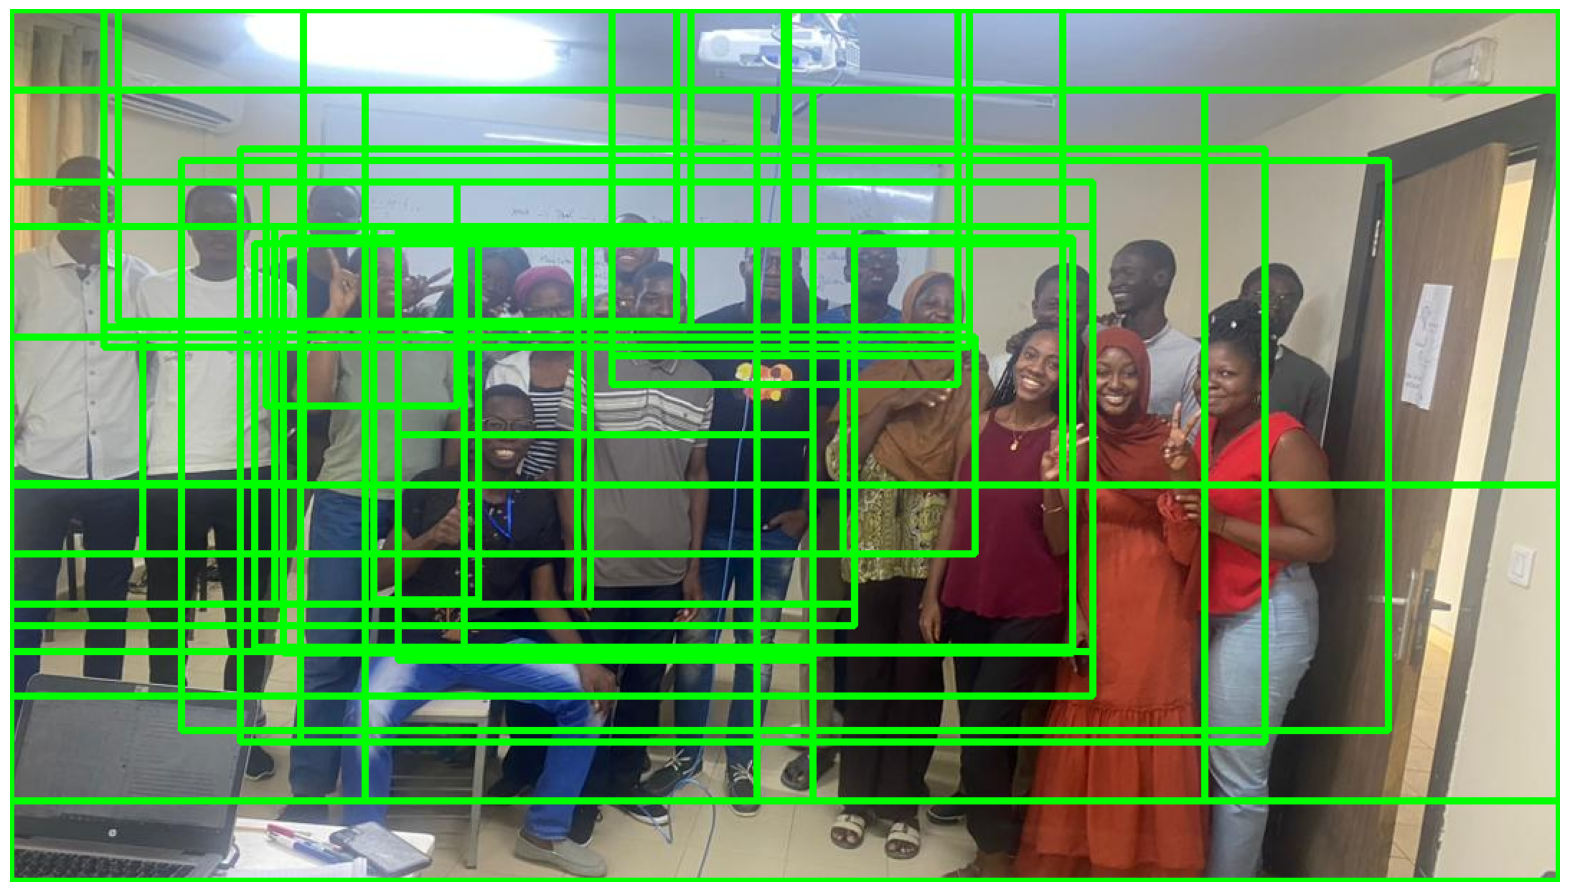

In [ ]:
img = read('/content/pclasse.jpg', 1)
candidates = extract_candidates(img)
show(img, bbs=candidates)

## Download dataset

In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

Saving kaggle.json to kaggle.json
kaggle.json
 97% 356M/367M [00:03<00:00, 121MB/s]
100% 367M/367M [00:03<00:00, 99.6MB/s]


## Preparing the dataset

In [ ]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
DF_RAW.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [ ]:
class OpenImages(Dataset):
  def __init__(self, df, image_folder=IMAGE_ROOT):
     self.root = image_folder
     self.df = df
     self.unique_images = df['ImageID'].unique()

  def __len__(self): return len(self.unique_images)

  def __getitem__(self, ix):
    image_id = self.unique_images[ix]
    image_path = f'{self.root}/{image_id}.jpg'

    # Convert BGR to RGB
    image = cv2.imread(image_path, 1)[...,::-1]
    h, w, _ = image.shape
    df = self.df.copy()
    df = df[df['ImageID'] == image_id]
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
    classes = df['LabelName'].values.tolist()

    return image, boxes, classes, image_path

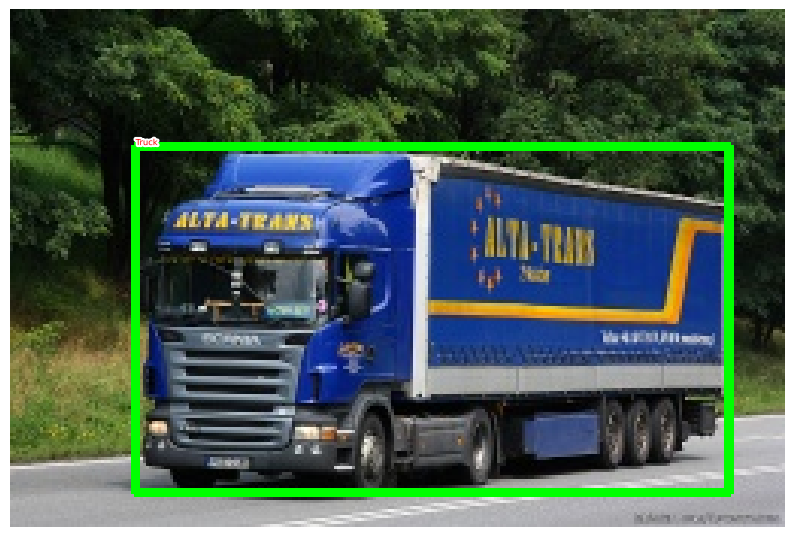

In [ ]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [ ]:
def extract_iou(boxA, boxB, epsilon=1e-5):

  # Calculate the coordinates of the intersection box
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])

  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])

  # Calculate width and heigth corresponding to the intersection area (overlapping region)
  width = (x2 - x1)
  heigth = (y2 - y1)

  # Calculate the area of overlap
  if (width < 0) or (heigth < 0):
    return 0.0

  area_overlap = width * heigth

  # Calculate the combined area corresponding to the two bounding boxes
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap

  # Calculate the IoU
  iou = area_overlap / (area_combined + epsilon)
  return iou

## Fetching region proposals and the ground truth of offset

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
  if ix == N:
    break
  H, W, _ = im.shape
  candidates = extract_candidates(im)
  candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])
  ious, rois, clss, deltas = [], [], [], []
  ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
  for jx, candidate in enumerate(candidates):
    cx, cy, cX, cY = candidate
    candidate_ious = ious[jx]
    best_iou_at = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_at]
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
    if best_iou > 0.3: clss.append(labels[best_iou_at])
    else : clss.append('background')
    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))
  FPATHS.append(fpath)
  IOUS.append(ious)
  ROIS.append(rois)
  CLSS.append(clss)
  DELTAS.append(deltas)
  GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [ ]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

## Creating the training data

In [ ]:
# Define the function to normalize
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# function to preprocess the image
def preprocess_image(img):
  img = torch.tensor(img).permute(2, 0, 1)
  img = normalize(img)

  return img.to(device).float()

# function to the class decode prediction
def decode(_y):
  _, preds = _y.max(-1)
  return preds

# CHAPTER I: Region-based Convolutional Neural Network R-CNN

### Definition of class to preprocess the dataset for R-*CNN*

In [ ]:
class RCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas, gtbbs):
    self.fpaths = fpaths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels = labels
    self.deltas = deltas

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image = cv2.imread(fpath, 1)[...,::-1]
    H, W, _ = image.shape
    sh = np.array([W, H, W, H])
    gtbbs = self.gtbbs[ix]
    rois = self.rois[ix]
    bbs = (np.array(rois) * sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops = [image[y:Y, x:X] for (x, y, X, Y) in bbs]

    return image, crops, bbs, labels, deltas, gtbbs, fpath

  # function which performs the resizing and normalizing of an image of a crop
  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for ix in range(len(batch)):
      image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
      crops = [cv2.resize(crop, (224,224)) for crop in crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas


In [ ]:
n_train = 9*len(FPATHS)//10

train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

## Architecture of Region-based Convolutional Neural Network (R-CNN)

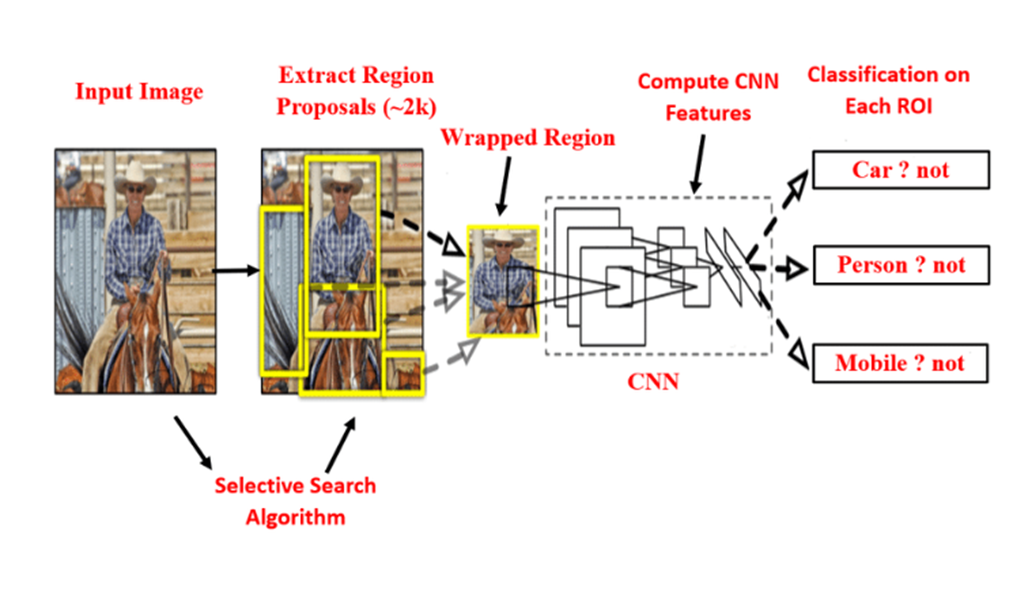

### Using VGG as backbone for our R-CNN architecture

In [ ]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 25088
    self.backbone = vgg_backbone
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
          nn.Linear(feature_dim, 512),
          nn.ReLU(),
          nn.Linear(512, 4),
          nn.Tanh(),
        )
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()

  def forward(self, input):
    feat = self.backbone(input)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

  # function to calculate loss
  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cel(probs, labels)
    ixs, = torch.where(labels != 0)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
        regression_loss = self.sl1(_deltas, deltas)
        return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
        regression_loss = 0
        return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss


## Define the train_batch function

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
  input, clss, deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(input)
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

## Define the validate_batch function

In [ ]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
  input, clss, deltas = inputs
  with torch.no_grad():
    model.eval()
    _clss,_deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    _, _clss = _clss.max(-1)
    accs = clss == _clss
  return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()


## Step of training of RCNN

In [ ]:
# Creation of the object of th rcnn model
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
import time

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]<ipython-input-11-6453b41cbde3>:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  deltas = torch.Tensor(deltas).float().to(device)

1it [00:02,  2.54s/it]

EPOCH: 0.004  trn_loss: 3.744  trn_loc_loss: 1.009  trn_regr_loss: 0.273  trn_acc: 0.444  (2.56s - 2874.04s remaining)


2it [00:03,  1.43s/it]

EPOCH: 0.009  trn_loss: 4.128  trn_loc_loss: 0.872  trn_regr_loss: 0.326  trn_acc: 0.755  (3.21s - 1804.68s remaining)


3it [00:03,  1.02s/it]

EPOCH: 0.013  trn_loss: 4.182  trn_loc_loss: 1.908  trn_regr_loss: 0.227  trn_acc: 0.338  (3.75s - 1403.14s remaining)


4it [00:04,  1.17it/s]

EPOCH: 0.018  trn_loss: 3.603  trn_loc_loss: 0.861  trn_regr_loss: 0.274  trn_acc: 0.516  (4.35s - 1219.92s remaining)


5it [00:04,  1.33it/s]

EPOCH: 0.022  trn_loss: 3.529  trn_loc_loss: 0.915  trn_regr_loss: 0.261  trn_acc: 0.494  (4.91s - 1100.66s remaining)


6it [00:05,  1.46it/s]

EPOCH: 0.027  trn_loss: 5.289  trn_loc_loss: 2.661  trn_regr_loss: 0.263  trn_acc: 0.123  (5.47s - 1020.01s remaining)


7it [00:06,  1.53it/s]

EPOCH: 0.031  trn_loss: 3.042  trn_loc_loss: 0.806  trn_regr_loss: 0.224  trn_acc: 0.761  (6.06s - 967.09s remaining)


8it [00:06,  1.63it/s]

EPOCH: 0.036  trn_loss: 3.514  trn_loc_loss: 0.814  trn_regr_loss: 0.270  trn_acc: 0.714  (6.59s - 920.05s remaining)


9it [00:07,  1.68it/s]

EPOCH: 0.040  trn_loss: 3.510  trn_loc_loss: 1.111  trn_regr_loss: 0.240  trn_acc: 0.453  (7.14s - 885.96s remaining)


10it [00:07,  1.74it/s]

EPOCH: 0.044  trn_loss: 4.817  trn_loc_loss: 1.275  trn_regr_loss: 0.354  trn_acc: 0.618  (7.67s - 855.44s remaining)


11it [00:08,  1.68it/s]

EPOCH: 0.049  trn_loss: 2.937  trn_loc_loss: 0.431  trn_regr_loss: 0.251  trn_acc: 0.914  (8.31s - 841.45s remaining)


12it [00:08,  1.70it/s]

EPOCH: 0.053  trn_loss: 4.469  trn_loc_loss: 0.766  trn_regr_loss: 0.370  trn_acc: 0.688  (8.89s - 824.58s remaining)


13it [00:09,  1.67it/s]

EPOCH: 0.058  trn_loss: 3.653  trn_loc_loss: 0.535  trn_regr_loss: 0.312  trn_acc: 0.800  (9.50s - 812.96s remaining)


14it [00:09,  1.79it/s]

EPOCH: 0.062  trn_loss: 2.137  trn_loc_loss: 0.541  trn_regr_loss: 0.160  trn_acc: 0.771  (9.98s - 791.65s remaining)


15it [00:10,  1.85it/s]

EPOCH: 0.067  trn_loss: 2.636  trn_loc_loss: 0.544  trn_regr_loss: 0.209  trn_acc: 0.803  (10.47s - 774.76s remaining)


16it [00:11,  1.81it/s]

EPOCH: 0.071  trn_loss: 4.315  trn_loc_loss: 2.082  trn_regr_loss: 0.223  trn_acc: 0.318  (11.05s - 765.83s remaining)


17it [00:11,  1.76it/s]

EPOCH: 0.076  trn_loss: 3.720  trn_loc_loss: 0.330  trn_regr_loss: 0.339  trn_acc: 0.934  (11.65s - 759.63s remaining)


18it [00:12,  1.74it/s]

EPOCH: 0.080  trn_loss: 2.959  trn_loc_loss: 1.000  trn_regr_loss: 0.196  trn_acc: 0.615  (12.25s - 753.34s remaining)


19it [00:12,  1.82it/s]

EPOCH: 0.084  trn_loss: 3.414  trn_loc_loss: 1.012  trn_regr_loss: 0.240  trn_acc: 0.699  (12.73s - 741.31s remaining)


20it [00:13,  1.89it/s]

EPOCH: 0.089  trn_loss: 2.880  trn_loc_loss: 0.484  trn_regr_loss: 0.240  trn_acc: 0.800  (13.22s - 730.38s remaining)


21it [00:13,  1.82it/s]

EPOCH: 0.093  trn_loss: 3.270  trn_loc_loss: 0.633  trn_regr_loss: 0.264  trn_acc: 0.696  (13.82s - 726.48s remaining)


22it [00:14,  1.79it/s]

EPOCH: 0.098  trn_loss: 3.248  trn_loc_loss: 1.188  trn_regr_loss: 0.206  trn_acc: 0.552  (14.40s - 721.85s remaining)


23it [00:14,  1.75it/s]

EPOCH: 0.102  trn_loss: 3.534  trn_loc_loss: 0.700  trn_regr_loss: 0.283  trn_acc: 0.609  (15.00s - 718.76s remaining)


24it [00:15,  1.86it/s]

EPOCH: 0.107  trn_loss: 3.323  trn_loc_loss: 0.855  trn_regr_loss: 0.247  trn_acc: 0.676  (15.46s - 709.03s remaining)


25it [00:15,  1.94it/s]

EPOCH: 0.111  trn_loss: 3.596  trn_loc_loss: 0.993  trn_regr_loss: 0.260  trn_acc: 0.643  (15.92s - 700.64s remaining)


26it [00:16,  1.90it/s]

EPOCH: 0.116  trn_loss: 2.109  trn_loc_loss: 0.547  trn_regr_loss: 0.156  trn_acc: 0.889  (16.47s - 696.18s remaining)


27it [00:16,  1.95it/s]

EPOCH: 0.120  trn_loss: 2.390  trn_loc_loss: 0.416  trn_regr_loss: 0.197  trn_acc: 0.836  (16.95s - 689.31s remaining)


28it [00:17,  2.03it/s]

EPOCH: 0.124  trn_loss: 2.997  trn_loc_loss: 0.936  trn_regr_loss: 0.206  trn_acc: 0.652  (17.40s - 681.77s remaining)


29it [00:17,  2.15it/s]

EPOCH: 0.129  trn_loss: 3.372  trn_loc_loss: 1.027  trn_regr_loss: 0.234  trn_acc: 0.492  (17.80s - 672.63s remaining)


30it [00:18,  2.14it/s]

EPOCH: 0.133  trn_loss: 2.686  trn_loc_loss: 0.275  trn_regr_loss: 0.241  trn_acc: 0.972  (18.27s - 666.82s remaining)


31it [00:18,  2.25it/s]

EPOCH: 0.138  trn_loss: 4.182  trn_loc_loss: 1.619  trn_regr_loss: 0.256  trn_acc: 0.667  (18.66s - 658.55s remaining)


32it [00:19,  2.03it/s]

EPOCH: 0.142  trn_loss: 4.051  trn_loc_loss: 1.296  trn_regr_loss: 0.275  trn_acc: 0.448  (19.27s - 658.17s remaining)


33it [00:19,  1.92it/s]

EPOCH: 0.147  trn_loss: 3.254  trn_loc_loss: 1.361  trn_regr_loss: 0.189  trn_acc: 0.338  (19.86s - 657.09s remaining)


34it [00:20,  1.79it/s]

EPOCH: 0.151  trn_loss: 3.398  trn_loc_loss: 1.294  trn_regr_loss: 0.210  trn_acc: 0.451  (20.50s - 657.90s remaining)


35it [00:20,  1.89it/s]

EPOCH: 0.156  trn_loss: 3.184  trn_loc_loss: 0.395  trn_regr_loss: 0.279  trn_acc: 0.887  (20.97s - 652.94s remaining)


36it [00:21,  1.73it/s]

EPOCH: 0.160  trn_loss: 2.897  trn_loc_loss: 0.212  trn_regr_loss: 0.268  trn_acc: 0.968  (21.66s - 655.23s remaining)


37it [00:22,  1.66it/s]

EPOCH: 0.164  trn_loss: 2.147  trn_loc_loss: 0.234  trn_regr_loss: 0.191  trn_acc: 0.928  (22.31s - 656.15s remaining)


38it [00:22,  1.66it/s]

EPOCH: 0.169  trn_loss: 2.967  trn_loc_loss: 0.790  trn_regr_loss: 0.218  trn_acc: 0.729  (22.92s - 655.69s remaining)


39it [00:23,  1.77it/s]

EPOCH: 0.173  trn_loss: 3.065  trn_loc_loss: 1.282  trn_regr_loss: 0.178  trn_acc: 0.625  (23.40s - 651.62s remaining)


40it [00:23,  1.78it/s]

EPOCH: 0.178  trn_loss: 3.128  trn_loc_loss: 0.555  trn_regr_loss: 0.257  trn_acc: 0.747  (23.96s - 649.83s remaining)


41it [00:24,  1.87it/s]

EPOCH: 0.182  trn_loss: 3.407  trn_loc_loss: 1.164  trn_regr_loss: 0.224  trn_acc: 0.629  (24.43s - 645.77s remaining)


42it [00:24,  1.91it/s]

EPOCH: 0.187  trn_loss: 2.536  trn_loc_loss: 0.677  trn_regr_loss: 0.186  trn_acc: 0.688  (24.92s - 642.67s remaining)


43it [00:25,  1.96it/s]

EPOCH: 0.191  trn_loss: 2.834  trn_loc_loss: 0.976  trn_regr_loss: 0.186  trn_acc: 0.556  (25.40s - 639.20s remaining)


44it [00:25,  1.99it/s]

EPOCH: 0.196  trn_loss: 2.363  trn_loc_loss: 0.680  trn_regr_loss: 0.168  trn_acc: 0.688  (25.89s - 636.09s remaining)


45it [00:26,  2.14it/s]

EPOCH: 0.200  trn_loss: 2.490  trn_loc_loss: 0.771  trn_regr_loss: 0.172  trn_acc: 0.596  (26.27s - 630.52s remaining)


46it [00:26,  1.99it/s]

EPOCH: 0.204  trn_loss: 2.332  trn_loc_loss: 0.740  trn_regr_loss: 0.159  trn_acc: 0.700  (26.86s - 629.98s remaining)


47it [00:27,  1.90it/s]

EPOCH: 0.209  trn_loss: 2.580  trn_loc_loss: 0.679  trn_regr_loss: 0.190  trn_acc: 0.644  (27.44s - 629.43s remaining)


48it [00:27,  1.87it/s]

EPOCH: 0.213  trn_loss: 2.137  trn_loc_loss: 0.187  trn_regr_loss: 0.195  trn_acc: 0.963  (27.99s - 628.13s remaining)


49it [00:28,  1.93it/s]

EPOCH: 0.218  trn_loss: 2.143  trn_loc_loss: 0.660  trn_regr_loss: 0.148  trn_acc: 0.770  (28.48s - 625.33s remaining)


50it [00:28,  2.00it/s]

EPOCH: 0.222  trn_loss: 3.881  trn_loc_loss: 1.385  trn_regr_loss: 0.250  trn_acc: 0.551  (28.94s - 622.13s remaining)


51it [00:29,  2.11it/s]

EPOCH: 0.227  trn_loss: 2.392  trn_loc_loss: 0.535  trn_regr_loss: 0.186  trn_acc: 0.750  (29.35s - 617.98s remaining)


52it [00:29,  1.97it/s]

EPOCH: 0.231  trn_loss: 2.501  trn_loc_loss: 0.713  trn_regr_loss: 0.179  trn_acc: 0.682  (29.93s - 617.58s remaining)


53it [00:30,  1.86it/s]

EPOCH: 0.236  trn_loss: 2.239  trn_loc_loss: 0.625  trn_regr_loss: 0.161  trn_acc: 0.804  (30.54s - 617.62s remaining)


54it [00:31,  1.91it/s]

EPOCH: 0.240  trn_loss: 2.589  trn_loc_loss: 0.686  trn_regr_loss: 0.190  trn_acc: 0.684  (31.03s - 615.41s remaining)


55it [00:31,  1.85it/s]

EPOCH: 0.244  trn_loss: 2.346  trn_loc_loss: 0.556  trn_regr_loss: 0.179  trn_acc: 0.744  (31.61s - 614.87s remaining)


56it [00:32,  1.91it/s]

EPOCH: 0.249  trn_loss: 3.611  trn_loc_loss: 1.116  trn_regr_loss: 0.249  trn_acc: 0.533  (32.09s - 612.66s remaining)


57it [00:32,  1.73it/s]

EPOCH: 0.253  trn_loss: 2.477  trn_loc_loss: 0.889  trn_regr_loss: 0.159  trn_acc: 0.663  (32.80s - 614.59s remaining)


58it [00:33,  1.46it/s]

EPOCH: 0.258  trn_loss: 2.594  trn_loc_loss: 0.564  trn_regr_loss: 0.203  trn_acc: 0.765  (33.74s - 620.63s remaining)


59it [00:34,  1.54it/s]

EPOCH: 0.262  trn_loss: 3.583  trn_loc_loss: 1.651  trn_regr_loss: 0.193  trn_acc: 0.522  (34.30s - 619.70s remaining)


60it [00:34,  1.58it/s]

EPOCH: 0.267  trn_loss: 1.958  trn_loc_loss: 0.580  trn_regr_loss: 0.138  trn_acc: 0.708  (34.90s - 619.46s remaining)


61it [00:35,  1.50it/s]

EPOCH: 0.271  trn_loss: 2.960  trn_loc_loss: 0.598  trn_regr_loss: 0.236  trn_acc: 0.822  (35.64s - 621.71s remaining)


62it [00:36,  1.61it/s]

EPOCH: 0.276  trn_loss: 2.586  trn_loc_loss: 0.412  trn_regr_loss: 0.217  trn_acc: 0.865  (36.16s - 619.89s remaining)


63it [00:36,  1.70it/s]

EPOCH: 0.280  trn_loss: 2.409  trn_loc_loss: 0.760  trn_regr_loss: 0.165  trn_acc: 0.649  (36.67s - 618.21s remaining)


64it [00:37,  1.80it/s]

EPOCH: 0.284  trn_loss: 2.796  trn_loc_loss: 0.902  trn_regr_loss: 0.189  trn_acc: 0.776  (37.15s - 615.82s remaining)


65it [00:37,  1.84it/s]

EPOCH: 0.289  trn_loss: 2.423  trn_loc_loss: 0.678  trn_regr_loss: 0.175  trn_acc: 0.608  (37.66s - 614.15s remaining)


66it [00:38,  1.98it/s]

EPOCH: 0.293  trn_loss: 2.909  trn_loc_loss: 0.238  trn_regr_loss: 0.267  trn_acc: 0.937  (38.08s - 611.00s remaining)


67it [00:38,  1.92it/s]

EPOCH: 0.298  trn_loss: 3.215  trn_loc_loss: 0.938  trn_regr_loss: 0.228  trn_acc: 0.580  (38.64s - 610.11s remaining)


68it [00:39,  1.83it/s]

EPOCH: 0.302  trn_loss: 2.632  trn_loc_loss: 0.805  trn_regr_loss: 0.183  trn_acc: 0.787  (39.24s - 609.99s remaining)


69it [00:39,  1.82it/s]

EPOCH: 0.307  trn_loss: 2.420  trn_loc_loss: 0.537  trn_regr_loss: 0.188  trn_acc: 0.744  (39.80s - 609.06s remaining)


70it [00:40,  1.86it/s]

EPOCH: 0.311  trn_loss: 2.630  trn_loc_loss: 0.432  trn_regr_loss: 0.220  trn_acc: 0.821  (40.31s - 607.56s remaining)


71it [00:40,  1.80it/s]

EPOCH: 0.316  trn_loss: 2.038  trn_loc_loss: 0.603  trn_regr_loss: 0.144  trn_acc: 0.789  (40.91s - 607.31s remaining)


72it [00:41,  1.84it/s]

EPOCH: 0.320  trn_loss: 2.288  trn_loc_loss: 0.665  trn_regr_loss: 0.162  trn_acc: 0.747  (41.42s - 605.76s remaining)


73it [00:41,  1.86it/s]

EPOCH: 0.324  trn_loss: 3.141  trn_loc_loss: 1.269  trn_regr_loss: 0.187  trn_acc: 0.475  (41.94s - 604.44s remaining)


74it [00:42,  1.84it/s]

EPOCH: 0.329  trn_loss: 2.394  trn_loc_loss: 0.650  trn_regr_loss: 0.174  trn_acc: 0.691  (42.50s - 603.64s remaining)


75it [00:42,  1.91it/s]

EPOCH: 0.333  trn_loss: 2.966  trn_loc_loss: 1.008  trn_regr_loss: 0.196  trn_acc: 0.414  (42.98s - 601.70s remaining)


76it [00:43,  1.75it/s]

EPOCH: 0.338  trn_loss: 2.466  trn_loc_loss: 0.270  trn_regr_loss: 0.220  trn_acc: 0.910  (43.67s - 602.70s remaining)


77it [00:44,  1.81it/s]

EPOCH: 0.342  trn_loss: 2.588  trn_loc_loss: 1.076  trn_regr_loss: 0.151  trn_acc: 0.545  (44.17s - 601.20s remaining)


78it [00:44,  1.84it/s]

EPOCH: 0.347  trn_loss: 2.554  trn_loc_loss: 0.967  trn_regr_loss: 0.159  trn_acc: 0.633  (44.70s - 599.98s remaining)


79it [00:45,  1.88it/s]

EPOCH: 0.351  trn_loss: 2.500  trn_loc_loss: 0.456  trn_regr_loss: 0.204  trn_acc: 0.857  (45.20s - 598.50s remaining)


80it [00:45,  1.72it/s]

EPOCH: 0.356  trn_loss: 2.375  trn_loc_loss: 0.433  trn_regr_loss: 0.194  trn_acc: 0.841  (45.90s - 599.50s remaining)


81it [00:46,  1.54it/s]

EPOCH: 0.360  trn_loss: 2.700  trn_loc_loss: 0.370  trn_regr_loss: 0.233  trn_acc: 0.772  (46.70s - 601.95s remaining)


82it [00:47,  1.54it/s]

EPOCH: 0.364  trn_loss: 1.939  trn_loc_loss: 0.561  trn_regr_loss: 0.138  trn_acc: 0.747  (47.35s - 602.31s remaining)


83it [00:47,  1.60it/s]

EPOCH: 0.369  trn_loss: 2.565  trn_loc_loss: 0.300  trn_regr_loss: 0.226  trn_acc: 0.867  (47.93s - 601.69s remaining)


84it [00:48,  1.56it/s]

EPOCH: 0.373  trn_loss: 2.787  trn_loc_loss: 0.435  trn_regr_loss: 0.235  trn_acc: 0.821  (48.60s - 602.34s remaining)


85it [00:49,  1.70it/s]

EPOCH: 0.378  trn_loss: 1.956  trn_loc_loss: 0.321  trn_regr_loss: 0.163  trn_acc: 0.870  (49.07s - 600.42s remaining)


86it [00:49,  1.72it/s]

EPOCH: 0.382  trn_loss: 1.805  trn_loc_loss: 0.254  trn_regr_loss: 0.155  trn_acc: 0.902  (49.64s - 599.67s remaining)


87it [00:50,  1.81it/s]

EPOCH: 0.387  trn_loss: 2.509  trn_loc_loss: 0.321  trn_regr_loss: 0.219  trn_acc: 0.873  (50.12s - 597.98s remaining)


88it [00:50,  1.96it/s]

EPOCH: 0.391  trn_loss: 2.250  trn_loc_loss: 0.528  trn_regr_loss: 0.172  trn_acc: 0.774  (50.53s - 595.45s remaining)


89it [00:51,  1.79it/s]

EPOCH: 0.396  trn_loss: 2.872  trn_loc_loss: 1.057  trn_regr_loss: 0.181  trn_acc: 0.639  (51.21s - 596.08s remaining)


90it [00:51,  1.75it/s]

EPOCH: 0.400  trn_loss: 2.885  trn_loc_loss: 0.124  trn_regr_loss: 0.276  trn_acc: 1.000  (51.80s - 595.72s remaining)


91it [00:52,  1.90it/s]

EPOCH: 0.404  trn_loss: 3.046  trn_loc_loss: 0.847  trn_regr_loss: 0.220  trn_acc: 0.623  (52.22s - 593.37s remaining)


92it [00:52,  1.91it/s]

EPOCH: 0.409  trn_loss: 2.254  trn_loc_loss: 0.690  trn_regr_loss: 0.156  trn_acc: 0.753  (52.74s - 592.15s remaining)


93it [00:53,  1.82it/s]

EPOCH: 0.413  trn_loss: 3.199  trn_loc_loss: 0.475  trn_regr_loss: 0.272  trn_acc: 0.846  (53.35s - 592.01s remaining)


94it [00:53,  1.85it/s]

EPOCH: 0.418  trn_loss: 2.011  trn_loc_loss: 0.185  trn_regr_loss: 0.183  trn_acc: 0.900  (53.87s - 590.87s remaining)


95it [00:54,  1.72it/s]

EPOCH: 0.422  trn_loss: 2.862  trn_loc_loss: 0.364  trn_regr_loss: 0.250  trn_acc: 0.869  (54.55s - 591.44s remaining)


96it [00:55,  1.81it/s]

EPOCH: 0.427  trn_loss: 2.306  trn_loc_loss: 0.787  trn_regr_loss: 0.152  trn_acc: 0.606  (55.04s - 589.91s remaining)


97it [00:55,  1.87it/s]

EPOCH: 0.431  trn_loss: 3.089  trn_loc_loss: 1.355  trn_regr_loss: 0.173  trn_acc: 0.472  (55.53s - 588.46s remaining)


98it [00:56,  1.91it/s]

EPOCH: 0.436  trn_loss: 2.597  trn_loc_loss: 1.138  trn_regr_loss: 0.146  trn_acc: 0.528  (56.03s - 587.16s remaining)


99it [00:56,  1.94it/s]

EPOCH: 0.440  trn_loss: 2.088  trn_loc_loss: 0.734  trn_regr_loss: 0.135  trn_acc: 0.662  (56.52s - 585.79s remaining)


100it [00:57,  1.93it/s]

EPOCH: 0.444  trn_loss: 1.882  trn_loc_loss: 0.402  trn_regr_loss: 0.148  trn_acc: 0.922  (57.05s - 584.77s remaining)


101it [00:57,  2.04it/s]

EPOCH: 0.449  trn_loss: 1.515  trn_loc_loss: 0.425  trn_regr_loss: 0.109  trn_acc: 0.871  (57.47s - 582.70s remaining)


102it [00:58,  1.93it/s]

EPOCH: 0.453  trn_loss: 1.713  trn_loc_loss: 0.354  trn_regr_loss: 0.136  trn_acc: 0.867  (58.06s - 582.30s remaining)


103it [00:58,  1.90it/s]

EPOCH: 0.458  trn_loss: 1.531  trn_loc_loss: 0.408  trn_regr_loss: 0.112  trn_acc: 0.843  (58.60s - 581.47s remaining)


104it [00:59,  1.82it/s]

EPOCH: 0.462  trn_loss: 2.039  trn_loc_loss: 0.428  trn_regr_loss: 0.161  trn_acc: 0.831  (59.20s - 581.21s remaining)


105it [00:59,  1.78it/s]

EPOCH: 0.467  trn_loss: 2.317  trn_loc_loss: 0.509  trn_regr_loss: 0.181  trn_acc: 0.782  (59.80s - 580.91s remaining)


106it [01:00,  1.64it/s]

EPOCH: 0.471  trn_loss: 2.612  trn_loc_loss: 0.811  trn_regr_loss: 0.180  trn_acc: 0.688  (60.52s - 581.81s remaining)


107it [01:01,  1.55it/s]

EPOCH: 0.476  trn_loss: 2.190  trn_loc_loss: 1.002  trn_regr_loss: 0.119  trn_acc: 0.611  (61.24s - 582.67s remaining)


108it [01:01,  1.60it/s]

EPOCH: 0.480  trn_loss: 2.450  trn_loc_loss: 0.889  trn_regr_loss: 0.156  trn_acc: 0.659  (61.83s - 582.20s remaining)


109it [01:02,  1.55it/s]

EPOCH: 0.484  trn_loss: 2.182  trn_loc_loss: 0.516  trn_regr_loss: 0.167  trn_acc: 0.822  (62.52s - 582.73s remaining)


110it [01:03,  1.59it/s]

EPOCH: 0.489  trn_loss: 1.914  trn_loc_loss: 0.404  trn_regr_loss: 0.151  trn_acc: 0.843  (63.11s - 582.33s remaining)


111it [01:03,  1.61it/s]

EPOCH: 0.493  trn_loss: 2.619  trn_loc_loss: 0.701  trn_regr_loss: 0.192  trn_acc: 0.736  (63.71s - 582.00s remaining)


112it [01:04,  1.55it/s]

EPOCH: 0.498  trn_loss: 2.514  trn_loc_loss: 0.692  trn_regr_loss: 0.182  trn_acc: 0.757  (64.42s - 582.62s remaining)


113it [01:05,  1.57it/s]

EPOCH: 0.502  trn_loss: 2.368  trn_loc_loss: 0.494  trn_regr_loss: 0.187  trn_acc: 0.812  (65.03s - 582.37s remaining)


114it [01:05,  1.51it/s]

EPOCH: 0.507  trn_loss: 2.223  trn_loc_loss: 0.418  trn_regr_loss: 0.181  trn_acc: 0.816  (65.76s - 583.17s remaining)


115it [01:06,  1.64it/s]

EPOCH: 0.511  trn_loss: 3.015  trn_loc_loss: 0.969  trn_regr_loss: 0.205  trn_acc: 0.710  (66.24s - 581.76s remaining)


116it [01:06,  1.82it/s]

EPOCH: 0.516  trn_loss: 2.231  trn_loc_loss: 0.650  trn_regr_loss: 0.158  trn_acc: 0.661  (66.65s - 579.74s remaining)


117it [01:07,  1.99it/s]

EPOCH: 0.520  trn_loss: 2.391  trn_loc_loss: 0.672  trn_regr_loss: 0.172  trn_acc: 0.714  (67.04s - 577.58s remaining)


118it [01:07,  1.97it/s]

EPOCH: 0.524  trn_loss: 1.841  trn_loc_loss: 0.562  trn_regr_loss: 0.128  trn_acc: 0.833  (67.56s - 576.54s remaining)


119it [01:08,  1.96it/s]

EPOCH: 0.529  trn_loss: 2.734  trn_loc_loss: 0.382  trn_regr_loss: 0.235  trn_acc: 0.870  (68.08s - 575.53s remaining)


120it [01:08,  1.85it/s]

EPOCH: 0.533  trn_loss: 2.342  trn_loc_loss: 0.220  trn_regr_loss: 0.212  trn_acc: 0.955  (68.69s - 575.27s remaining)


121it [01:09,  1.89it/s]

EPOCH: 0.538  trn_loss: 3.902  trn_loc_loss: 1.133  trn_regr_loss: 0.277  trn_acc: 0.587  (69.20s - 574.15s remaining)


122it [01:09,  1.91it/s]

EPOCH: 0.542  trn_loss: 2.637  trn_loc_loss: 0.697  trn_regr_loss: 0.194  trn_acc: 0.693  (69.70s - 573.04s remaining)


123it [01:10,  1.83it/s]

EPOCH: 0.547  trn_loss: 2.974  trn_loc_loss: 1.195  trn_regr_loss: 0.178  trn_acc: 0.573  (70.31s - 572.73s remaining)


124it [01:10,  1.76it/s]

EPOCH: 0.551  trn_loss: 2.555  trn_loc_loss: 0.267  trn_regr_loss: 0.229  trn_acc: 0.957  (70.92s - 572.52s remaining)


125it [01:11,  1.75it/s]

EPOCH: 0.556  trn_loss: 2.638  trn_loc_loss: 0.417  trn_regr_loss: 0.222  trn_acc: 0.812  (71.50s - 572.02s remaining)


126it [01:12,  1.73it/s]

EPOCH: 0.560  trn_loss: 2.156  trn_loc_loss: 0.441  trn_regr_loss: 0.171  trn_acc: 0.810  (72.09s - 571.61s remaining)


127it [01:12,  1.82it/s]

EPOCH: 0.564  trn_loss: 2.794  trn_loc_loss: 0.780  trn_regr_loss: 0.201  trn_acc: 0.661  (72.58s - 570.32s remaining)


128it [01:13,  1.76it/s]

EPOCH: 0.569  trn_loss: 2.229  trn_loc_loss: 0.551  trn_regr_loss: 0.168  trn_acc: 0.787  (73.18s - 570.04s remaining)


129it [01:13,  1.68it/s]

EPOCH: 0.573  trn_loss: 2.260  trn_loc_loss: 0.436  trn_regr_loss: 0.182  trn_acc: 0.841  (73.85s - 570.19s remaining)


130it [01:14,  1.63it/s]

EPOCH: 0.578  trn_loss: 2.442  trn_loc_loss: 0.480  trn_regr_loss: 0.196  trn_acc: 0.802  (74.50s - 570.24s remaining)


131it [01:14,  1.72it/s]

EPOCH: 0.582  trn_loss: 2.088  trn_loc_loss: 0.377  trn_regr_loss: 0.171  trn_acc: 0.851  (75.01s - 569.17s remaining)


132it [01:15,  1.62it/s]

EPOCH: 0.587  trn_loss: 2.027  trn_loc_loss: 0.366  trn_regr_loss: 0.166  trn_acc: 0.869  (75.71s - 569.52s remaining)


133it [01:16,  1.56it/s]

EPOCH: 0.591  trn_loss: 2.349  trn_loc_loss: 0.679  trn_regr_loss: 0.167  trn_acc: 0.693  (76.40s - 569.85s remaining)


134it [01:16,  1.67it/s]

EPOCH: 0.596  trn_loss: 2.175  trn_loc_loss: 0.637  trn_regr_loss: 0.154  trn_acc: 0.784  (76.91s - 568.79s remaining)


135it [01:17,  1.67it/s]

EPOCH: 0.600  trn_loss: 1.860  trn_loc_loss: 0.317  trn_regr_loss: 0.154  trn_acc: 0.966  (77.51s - 568.38s remaining)


136it [01:18,  1.64it/s]

EPOCH: 0.604  trn_loss: 2.274  trn_loc_loss: 0.876  trn_regr_loss: 0.140  trn_acc: 0.768  (78.14s - 568.23s remaining)


137it [01:18,  1.70it/s]

EPOCH: 0.609  trn_loss: 1.900  trn_loc_loss: 0.434  trn_regr_loss: 0.147  trn_acc: 0.810  (78.68s - 567.44s remaining)


138it [01:19,  1.68it/s]

EPOCH: 0.613  trn_loss: 2.638  trn_loc_loss: 0.586  trn_regr_loss: 0.205  trn_acc: 0.736  (79.29s - 567.13s remaining)


139it [01:19,  1.68it/s]

EPOCH: 0.618  trn_loss: 2.250  trn_loc_loss: 0.507  trn_regr_loss: 0.174  trn_acc: 0.837  (79.89s - 566.68s remaining)


140it [01:20,  1.61it/s]

EPOCH: 0.622  trn_loss: 2.643  trn_loc_loss: 0.614  trn_regr_loss: 0.203  trn_acc: 0.735  (80.57s - 566.85s remaining)


141it [01:20,  1.79it/s]

EPOCH: 0.627  trn_loss: 2.749  trn_loc_loss: 0.222  trn_regr_loss: 0.253  trn_acc: 0.938  (80.99s - 565.17s remaining)


142it [01:21,  1.75it/s]

EPOCH: 0.631  trn_loss: 3.249  trn_loc_loss: 0.858  trn_regr_loss: 0.239  trn_acc: 0.600  (81.58s - 564.77s remaining)


143it [01:22,  1.70it/s]

EPOCH: 0.636  trn_loss: 1.725  trn_loc_loss: 0.416  trn_regr_loss: 0.131  trn_acc: 0.785  (82.21s - 564.56s remaining)


144it [01:22,  1.71it/s]

EPOCH: 0.640  trn_loss: 1.872  trn_loc_loss: 0.567  trn_regr_loss: 0.130  trn_acc: 0.793  (82.78s - 563.97s remaining)


145it [01:23,  1.69it/s]

EPOCH: 0.644  trn_loss: 2.510  trn_loc_loss: 0.786  trn_regr_loss: 0.172  trn_acc: 0.703  (83.40s - 563.64s remaining)


146it [01:23,  1.77it/s]

EPOCH: 0.649  trn_loss: 2.287  trn_loc_loss: 0.286  trn_regr_loss: 0.200  trn_acc: 0.900  (83.89s - 562.55s remaining)


147it [01:24,  1.77it/s]

EPOCH: 0.653  trn_loss: 2.080  trn_loc_loss: 0.539  trn_regr_loss: 0.154  trn_acc: 0.778  (84.46s - 561.95s remaining)


148it [01:25,  1.67it/s]

EPOCH: 0.658  trn_loss: 1.976  trn_loc_loss: 0.279  trn_regr_loss: 0.170  trn_acc: 0.915  (85.14s - 562.07s remaining)


149it [01:25,  1.54it/s]

EPOCH: 0.662  trn_loss: 2.559  trn_loc_loss: 0.994  trn_regr_loss: 0.157  trn_acc: 0.598  (85.91s - 562.71s remaining)


150it [01:26,  1.61it/s]

EPOCH: 0.667  trn_loss: 1.860  trn_loc_loss: 0.576  trn_regr_loss: 0.128  trn_acc: 0.809  (86.46s - 561.97s remaining)


151it [01:27,  1.59it/s]

EPOCH: 0.671  trn_loss: 1.943  trn_loc_loss: 0.591  trn_regr_loss: 0.135  trn_acc: 0.720  (87.11s - 561.87s remaining)


152it [01:27,  1.62it/s]

EPOCH: 0.676  trn_loss: 2.084  trn_loc_loss: 0.739  trn_regr_loss: 0.135  trn_acc: 0.564  (87.70s - 561.38s remaining)


153it [01:28,  1.73it/s]

EPOCH: 0.680  trn_loss: 2.397  trn_loc_loss: 0.330  trn_regr_loss: 0.207  trn_acc: 0.881  (88.18s - 560.20s remaining)


154it [01:28,  1.73it/s]

EPOCH: 0.684  trn_loss: 2.675  trn_loc_loss: 0.624  trn_regr_loss: 0.205  trn_acc: 0.824  (88.76s - 559.65s remaining)


155it [01:29,  1.80it/s]

EPOCH: 0.689  trn_loss: 2.917  trn_loc_loss: 1.197  trn_regr_loss: 0.172  trn_acc: 0.583  (89.26s - 558.59s remaining)


156it [01:29,  1.78it/s]

EPOCH: 0.693  trn_loss: 2.160  trn_loc_loss: 0.297  trn_regr_loss: 0.186  trn_acc: 0.874  (89.84s - 558.05s remaining)


157it [01:30,  1.82it/s]

EPOCH: 0.698  trn_loss: 2.287  trn_loc_loss: 0.128  trn_regr_loss: 0.216  trn_acc: 0.961  (90.36s - 557.11s remaining)


158it [01:30,  1.80it/s]

EPOCH: 0.702  trn_loss: 2.084  trn_loc_loss: 0.456  trn_regr_loss: 0.163  trn_acc: 0.704  (90.93s - 556.49s remaining)


159it [01:31,  1.77it/s]

EPOCH: 0.707  trn_loss: 1.872  trn_loc_loss: 0.525  trn_regr_loss: 0.135  trn_acc: 0.765  (91.52s - 556.00s remaining)


160it [01:32,  1.73it/s]

EPOCH: 0.711  trn_loss: 2.697  trn_loc_loss: 0.307  trn_regr_loss: 0.239  trn_acc: 0.920  (92.13s - 555.63s remaining)


161it [01:32,  1.79it/s]

EPOCH: 0.716  trn_loss: 2.622  trn_loc_loss: 0.966  trn_regr_loss: 0.166  trn_acc: 0.532  (92.64s - 554.66s remaining)


162it [01:33,  1.95it/s]

EPOCH: 0.720  trn_loss: 1.748  trn_loc_loss: 0.446  trn_regr_loss: 0.130  trn_acc: 0.836  (93.05s - 553.11s remaining)


163it [01:33,  1.95it/s]

EPOCH: 0.724  trn_loss: 2.633  trn_loc_loss: 0.410  trn_regr_loss: 0.222  trn_acc: 0.853  (93.56s - 552.16s remaining)


164it [01:34,  1.96it/s]

EPOCH: 0.729  trn_loss: 1.667  trn_loc_loss: 0.687  trn_regr_loss: 0.098  trn_acc: 0.708  (94.06s - 551.18s remaining)


165it [01:34,  1.96it/s]

EPOCH: 0.733  trn_loss: 2.338  trn_loc_loss: 0.754  trn_regr_loss: 0.158  trn_acc: 0.610  (94.57s - 550.21s remaining)


166it [01:35,  1.73it/s]

EPOCH: 0.738  trn_loss: 1.694  trn_loc_loss: 0.379  trn_regr_loss: 0.132  trn_acc: 0.870  (95.30s - 550.58s remaining)


167it [01:35,  1.78it/s]

EPOCH: 0.742  trn_loss: 2.118  trn_loc_loss: 0.696  trn_regr_loss: 0.142  trn_acc: 0.740  (95.83s - 549.71s remaining)


168it [01:36,  1.73it/s]

EPOCH: 0.747  trn_loss: 2.431  trn_loc_loss: 0.518  trn_regr_loss: 0.191  trn_acc: 0.767  (96.45s - 549.42s remaining)


169it [01:37,  1.69it/s]

EPOCH: 0.751  trn_loss: 1.973  trn_loc_loss: 0.734  trn_regr_loss: 0.124  trn_acc: 0.787  (97.07s - 549.10s remaining)


170it [01:37,  1.80it/s]

EPOCH: 0.756  trn_loss: 1.699  trn_loc_loss: 0.193  trn_regr_loss: 0.151  trn_acc: 0.985  (97.54s - 547.96s remaining)


171it [01:38,  1.67it/s]

EPOCH: 0.760  trn_loss: 2.339  trn_loc_loss: 0.375  trn_regr_loss: 0.196  trn_acc: 0.914  (98.25s - 548.11s remaining)


172it [01:38,  1.61it/s]

EPOCH: 0.764  trn_loss: 2.370  trn_loc_loss: 0.342  trn_regr_loss: 0.203  trn_acc: 0.854  (98.92s - 548.07s remaining)


173it [01:39,  1.60it/s]

EPOCH: 0.769  trn_loss: 2.025  trn_loc_loss: 0.548  trn_regr_loss: 0.148  trn_acc: 0.637  (99.55s - 547.79s remaining)


174it [01:40,  1.64it/s]

EPOCH: 0.773  trn_loss: 1.821  trn_loc_loss: 0.695  trn_regr_loss: 0.113  trn_acc: 0.704  (100.12s - 547.22s remaining)


175it [01:40,  1.52it/s]

EPOCH: 0.778  trn_loss: 2.169  trn_loc_loss: 0.193  trn_regr_loss: 0.198  trn_acc: 0.959  (100.89s - 547.72s remaining)


176it [01:41,  1.55it/s]

EPOCH: 0.782  trn_loss: 2.878  trn_loc_loss: 0.606  trn_regr_loss: 0.227  trn_acc: 0.819  (101.52s - 547.37s remaining)


177it [01:42,  1.65it/s]

EPOCH: 0.787  trn_loss: 1.617  trn_loc_loss: 0.449  trn_regr_loss: 0.117  trn_acc: 0.824  (102.02s - 546.42s remaining)


178it [01:42,  1.74it/s]

EPOCH: 0.791  trn_loss: 1.612  trn_loc_loss: 0.266  trn_regr_loss: 0.135  trn_acc: 0.934  (102.53s - 545.48s remaining)


179it [01:43,  1.69it/s]

EPOCH: 0.796  trn_loss: 2.229  trn_loc_loss: 0.192  trn_regr_loss: 0.204  trn_acc: 0.968  (103.15s - 545.16s remaining)


180it [01:43,  1.69it/s]

EPOCH: 0.800  trn_loss: 2.161  trn_loc_loss: 0.895  trn_regr_loss: 0.127  trn_acc: 0.709  (103.75s - 544.68s remaining)


181it [01:44,  1.77it/s]

EPOCH: 0.804  trn_loss: 2.522  trn_loc_loss: 0.689  trn_regr_loss: 0.183  trn_acc: 0.680  (104.25s - 543.73s remaining)


182it [01:44,  1.74it/s]

EPOCH: 0.809  trn_loss: 2.309  trn_loc_loss: 0.491  trn_regr_loss: 0.182  trn_acc: 0.770  (104.85s - 543.27s remaining)


183it [01:45,  1.84it/s]

EPOCH: 0.813  trn_loss: 2.884  trn_loc_loss: 0.932  trn_regr_loss: 0.195  trn_acc: 0.682  (105.32s - 542.14s remaining)


184it [01:45,  1.79it/s]

EPOCH: 0.818  trn_loss: 2.057  trn_loc_loss: 0.700  trn_regr_loss: 0.136  trn_acc: 0.716  (105.92s - 541.68s remaining)


185it [01:46,  1.75it/s]

EPOCH: 0.822  trn_loss: 1.986  trn_loc_loss: 0.439  trn_regr_loss: 0.155  trn_acc: 0.854  (106.51s - 541.21s remaining)


186it [01:47,  1.64it/s]

EPOCH: 0.827  trn_loss: 1.946  trn_loc_loss: 0.281  trn_regr_loss: 0.167  trn_acc: 0.796  (107.21s - 541.24s remaining)


187it [01:47,  1.72it/s]

EPOCH: 0.831  trn_loss: 2.556  trn_loc_loss: 0.340  trn_regr_loss: 0.222  trn_acc: 0.827  (107.73s - 540.39s remaining)


188it [01:48,  1.77it/s]

EPOCH: 0.836  trn_loss: 1.597  trn_loc_loss: 0.562  trn_regr_loss: 0.103  trn_acc: 0.705  (108.25s - 539.54s remaining)


189it [01:48,  1.75it/s]

EPOCH: 0.840  trn_loss: 2.319  trn_loc_loss: 0.746  trn_regr_loss: 0.157  trn_acc: 0.735  (108.84s - 539.02s remaining)


190it [01:49,  1.79it/s]

EPOCH: 0.844  trn_loss: 2.257  trn_loc_loss: 0.561  trn_regr_loss: 0.170  trn_acc: 0.709  (109.37s - 538.20s remaining)


191it [01:49,  1.75it/s]

EPOCH: 0.849  trn_loss: 1.743  trn_loc_loss: 0.536  trn_regr_loss: 0.121  trn_acc: 0.736  (109.97s - 537.76s remaining)


192it [01:50,  1.76it/s]

EPOCH: 0.853  trn_loss: 2.234  trn_loc_loss: 0.439  trn_regr_loss: 0.179  trn_acc: 0.817  (110.53s - 537.13s remaining)


193it [01:51,  1.80it/s]

EPOCH: 0.858  trn_loss: 2.739  trn_loc_loss: 1.337  trn_regr_loss: 0.140  trn_acc: 0.443  (111.06s - 536.31s remaining)


194it [01:51,  1.76it/s]

EPOCH: 0.862  trn_loss: 2.433  trn_loc_loss: 0.621  trn_regr_loss: 0.181  trn_acc: 0.740  (111.65s - 535.82s remaining)


195it [01:52,  1.73it/s]

EPOCH: 0.867  trn_loss: 1.794  trn_loc_loss: 0.244  trn_regr_loss: 0.155  trn_acc: 0.947  (112.25s - 535.36s remaining)


196it [01:52,  1.72it/s]

EPOCH: 0.871  trn_loss: 2.951  trn_loc_loss: 0.545  trn_regr_loss: 0.241  trn_acc: 0.811  (112.84s - 534.83s remaining)


197it [01:53,  1.71it/s]

EPOCH: 0.876  trn_loss: 1.942  trn_loc_loss: 0.300  trn_regr_loss: 0.164  trn_acc: 0.850  (113.44s - 534.37s remaining)


198it [01:54,  1.62it/s]

EPOCH: 0.880  trn_loss: 1.994  trn_loc_loss: 0.625  trn_regr_loss: 0.137  trn_acc: 0.714  (114.13s - 534.33s remaining)


199it [01:54,  1.62it/s]

EPOCH: 0.884  trn_loss: 1.540  trn_loc_loss: 0.265  trn_regr_loss: 0.128  trn_acc: 0.860  (114.75s - 533.97s remaining)


200it [01:55,  1.70it/s]

EPOCH: 0.889  trn_loss: 1.846  trn_loc_loss: 0.503  trn_regr_loss: 0.134  trn_acc: 0.795  (115.27s - 533.14s remaining)


201it [01:55,  1.61it/s]

EPOCH: 0.893  trn_loss: 2.039  trn_loc_loss: 0.177  trn_regr_loss: 0.186  trn_acc: 0.960  (115.97s - 533.10s remaining)


202it [01:56,  1.79it/s]

EPOCH: 0.898  trn_loss: 2.540  trn_loc_loss: 1.126  trn_regr_loss: 0.141  trn_acc: 0.597  (116.38s - 531.78s remaining)


203it [01:56,  1.85it/s]

EPOCH: 0.902  trn_loss: 2.466  trn_loc_loss: 0.247  trn_regr_loss: 0.222  trn_acc: 0.903  (116.88s - 530.84s remaining)


204it [01:57,  1.78it/s]

EPOCH: 0.907  trn_loss: 2.385  trn_loc_loss: 0.681  trn_regr_loss: 0.170  trn_acc: 0.722  (117.49s - 530.42s remaining)


205it [01:58,  1.73it/s]

EPOCH: 0.911  trn_loss: 2.538  trn_loc_loss: 0.492  trn_regr_loss: 0.205  trn_acc: 0.800  (118.11s - 530.04s remaining)


206it [01:58,  1.80it/s]

EPOCH: 0.916  trn_loss: 2.614  trn_loc_loss: 0.960  trn_regr_loss: 0.165  trn_acc: 0.653  (118.61s - 529.12s remaining)


207it [01:59,  1.77it/s]

EPOCH: 0.920  trn_loss: 2.921  trn_loc_loss: 0.882  trn_regr_loss: 0.204  trn_acc: 0.667  (119.20s - 528.61s remaining)


208it [01:59,  1.95it/s]

EPOCH: 0.924  trn_loss: 2.126  trn_loc_loss: 1.088  trn_regr_loss: 0.104  trn_acc: 0.491  (119.59s - 527.21s remaining)


209it [02:00,  1.84it/s]

EPOCH: 0.929  trn_loss: 1.582  trn_loc_loss: 0.402  trn_regr_loss: 0.118  trn_acc: 0.888  (120.20s - 526.80s remaining)


210it [02:00,  1.87it/s]

EPOCH: 0.933  trn_loss: 1.680  trn_loc_loss: 0.296  trn_regr_loss: 0.138  trn_acc: 0.848  (120.71s - 525.97s remaining)


211it [02:01,  1.76it/s]

EPOCH: 0.938  trn_loss: 2.536  trn_loc_loss: 0.668  trn_regr_loss: 0.187  trn_acc: 0.833  (121.36s - 525.71s remaining)


212it [02:01,  1.81it/s]

EPOCH: 0.942  trn_loss: 3.971  trn_loc_loss: 1.939  trn_regr_loss: 0.203  trn_acc: 0.333  (121.88s - 524.89s remaining)


213it [02:02,  1.86it/s]

EPOCH: 0.947  trn_loss: 2.135  trn_loc_loss: 0.701  trn_regr_loss: 0.143  trn_acc: 0.699  (122.38s - 524.01s remaining)


214it [02:02,  1.91it/s]

EPOCH: 0.951  trn_loss: 1.926  trn_loc_loss: 0.422  trn_regr_loss: 0.150  trn_acc: 0.847  (122.88s - 523.08s remaining)


215it [02:03,  1.82it/s]

EPOCH: 0.956  trn_loss: 2.649  trn_loc_loss: 0.812  trn_regr_loss: 0.184  trn_acc: 0.802  (123.49s - 522.67s remaining)


216it [02:04,  1.65it/s]

EPOCH: 0.960  trn_loss: 2.571  trn_loc_loss: 0.564  trn_regr_loss: 0.201  trn_acc: 0.694  (124.23s - 522.78s remaining)


217it [02:04,  1.65it/s]

EPOCH: 0.964  trn_loss: 2.115  trn_loc_loss: 0.482  trn_regr_loss: 0.163  trn_acc: 0.711  (124.83s - 522.33s remaining)


218it [02:05,  1.80it/s]

EPOCH: 0.969  trn_loss: 1.948  trn_loc_loss: 0.675  trn_regr_loss: 0.127  trn_acc: 0.700  (125.26s - 521.17s remaining)


219it [02:05,  1.76it/s]

EPOCH: 0.973  trn_loss: 2.263  trn_loc_loss: 0.507  trn_regr_loss: 0.176  trn_acc: 0.868  (125.86s - 520.70s remaining)


220it [02:06,  1.66it/s]

EPOCH: 0.978  trn_loss: 2.155  trn_loc_loss: 0.538  trn_regr_loss: 0.162  trn_acc: 0.786  (126.54s - 520.55s remaining)


221it [02:07,  1.61it/s]

EPOCH: 0.982  trn_loss: 1.645  trn_loc_loss: 0.509  trn_regr_loss: 0.114  trn_acc: 0.774  (127.21s - 520.35s remaining)


222it [02:07,  1.52it/s]

EPOCH: 0.987  trn_loss: 2.420  trn_loc_loss: 0.572  trn_regr_loss: 0.185  trn_acc: 0.727  (127.95s - 520.46s remaining)


223it [02:08,  1.57it/s]

EPOCH: 0.991  trn_loss: 2.235  trn_loc_loss: 0.588  trn_regr_loss: 0.165  trn_acc: 0.741  (128.54s - 519.93s remaining)


224it [02:09,  1.59it/s]

EPOCH: 0.996  trn_loss: 1.617  trn_loc_loss: 0.299  trn_regr_loss: 0.132  trn_acc: 0.910  (129.15s - 519.49s remaining)


225it [02:09,  1.74it/s]

EPOCH: 1.000  trn_loss: 2.031  trn_loc_loss: 0.411  trn_regr_loss: 0.162  trn_acc: 0.859  (129.65s - 518.60s remaining)

EPOCH: 0.960  val_loss: 2.144  val_loc_loss: 0.297  val_regr_loss: 0.185  val_acc: 0.838  (142.64s - 600.29s remaining)

 20%|██        | 1/5 [02:23<09:32, 143.14s/it]

EPOCH: 1.000  val_loss: 1.994  val_loc_loss: 0.614  val_regr_loss: 0.138  val_acc: 0.753  (143.15s - 572.59s remaining)


0it [00:00, ?it/s]
1it [00:00,  1.74it/s]

EPOCH: 1.004  trn_loss: 1.758  trn_loc_loss: 0.361  trn_regr_loss: 0.140  trn_acc: 0.827  (143.73s - 571.72s remaining)


2it [00:01,  1.65it/s]

EPOCH: 1.009  trn_loss: 2.593  trn_loc_loss: 0.374  trn_regr_loss: 0.222  trn_acc: 0.872  (144.36s - 571.07s remaining)


3it [00:01,  1.74it/s]

EPOCH: 1.013  trn_loss: 1.778  trn_loc_loss: 0.375  trn_regr_loss: 0.140  trn_acc: 0.800  (144.89s - 570.03s remaining)


4it [00:02,  1.70it/s]

EPOCH: 1.018  trn_loss: 2.242  trn_loc_loss: 0.448  trn_regr_loss: 0.179  trn_acc: 0.780  (145.50s - 569.30s remaining)


5it [00:02,  1.70it/s]

EPOCH: 1.022  trn_loss: 1.833  trn_loc_loss: 0.443  trn_regr_loss: 0.139  trn_acc: 0.892  (146.09s - 568.47s remaining)


6it [00:03,  1.72it/s]

EPOCH: 1.027  trn_loss: 1.710  trn_loc_loss: 0.146  trn_regr_loss: 0.156  trn_acc: 0.914  (146.66s - 567.59s remaining)


7it [00:04,  1.70it/s]

EPOCH: 1.031  trn_loss: 1.507  trn_loc_loss: 0.169  trn_regr_loss: 0.134  trn_acc: 0.955  (147.26s - 566.82s remaining)


8it [00:04,  1.80it/s]

EPOCH: 1.036  trn_loss: 2.133  trn_loc_loss: 0.804  trn_regr_loss: 0.133  trn_acc: 0.714  (147.75s - 565.63s remaining)


9it [00:05,  1.84it/s]

EPOCH: 1.040  trn_loss: 2.149  trn_loc_loss: 0.359  trn_regr_loss: 0.179  trn_acc: 0.840  (148.26s - 564.53s remaining)


10it [00:05,  1.91it/s]

EPOCH: 1.044  trn_loss: 2.213  trn_loc_loss: 0.215  trn_regr_loss: 0.200  trn_acc: 0.956  (148.74s - 563.31s remaining)


11it [00:06,  1.86it/s]

EPOCH: 1.049  trn_loss: 2.056  trn_loc_loss: 0.162  trn_regr_loss: 0.189  trn_acc: 0.975  (149.31s - 562.45s remaining)


12it [00:06,  1.89it/s]

EPOCH: 1.053  trn_loss: 1.348  trn_loc_loss: 0.248  trn_regr_loss: 0.110  trn_acc: 0.909  (149.82s - 561.35s remaining)


13it [00:07,  1.78it/s]

EPOCH: 1.058  trn_loss: 1.908  trn_loc_loss: 0.119  trn_regr_loss: 0.179  trn_acc: 0.968  (150.46s - 560.75s remaining)


14it [00:07,  1.77it/s]

EPOCH: 1.062  trn_loss: 1.654  trn_loc_loss: 0.137  trn_regr_loss: 0.152  trn_acc: 0.957  (151.03s - 559.88s remaining)


15it [00:08,  1.74it/s]

EPOCH: 1.067  trn_loss: 1.513  trn_loc_loss: 0.218  trn_regr_loss: 0.129  trn_acc: 0.934  (151.62s - 559.11s remaining)


16it [00:09,  1.64it/s]

EPOCH: 1.071  trn_loss: 2.384  trn_loc_loss: 0.668  trn_regr_loss: 0.172  trn_acc: 0.727  (152.32s - 558.72s remaining)


17it [00:09,  1.56it/s]

EPOCH: 1.076  trn_loss: 1.920  trn_loc_loss: 0.085  trn_regr_loss: 0.184  trn_acc: 0.978  (153.03s - 558.37s remaining)


18it [00:10,  1.51it/s]

EPOCH: 1.080  trn_loss: 1.727  trn_loc_loss: 0.315  trn_regr_loss: 0.141  trn_acc: 0.846  (153.74s - 558.02s remaining)


19it [00:11,  1.62it/s]

EPOCH: 1.084  trn_loss: 1.961  trn_loc_loss: 0.405  trn_regr_loss: 0.156  trn_acc: 0.781  (154.25s - 556.95s remaining)


20it [00:11,  1.71it/s]

EPOCH: 1.089  trn_loss: 1.503  trn_loc_loss: 0.207  trn_regr_loss: 0.130  trn_acc: 0.973  (154.76s - 555.89s remaining)


21it [00:12,  1.67it/s]

EPOCH: 1.093  trn_loss: 2.546  trn_loc_loss: 0.781  trn_regr_loss: 0.177  trn_acc: 0.750  (155.40s - 555.27s remaining)


22it [00:12,  1.68it/s]

EPOCH: 1.098  trn_loss: 1.976  trn_loc_loss: 0.476  trn_regr_loss: 0.150  trn_acc: 0.701  (155.99s - 554.48s remaining)


23it [00:13,  1.65it/s]

EPOCH: 1.102  trn_loss: 1.903  trn_loc_loss: 0.174  trn_regr_loss: 0.173  trn_acc: 0.935  (156.61s - 553.82s remaining)


24it [00:13,  1.77it/s]

EPOCH: 1.107  trn_loss: 1.679  trn_loc_loss: 0.416  trn_regr_loss: 0.126  trn_acc: 0.853  (157.09s - 552.65s remaining)


25it [00:14,  1.83it/s]

EPOCH: 1.111  trn_loss: 2.368  trn_loc_loss: 0.682  trn_regr_loss: 0.169  trn_acc: 0.671  (157.59s - 551.57s remaining)


26it [00:15,  1.79it/s]

EPOCH: 1.116  trn_loss: 1.325  trn_loc_loss: 0.275  trn_regr_loss: 0.105  trn_acc: 0.926  (158.17s - 550.77s remaining)


27it [00:15,  1.85it/s]

EPOCH: 1.120  trn_loss: 1.588  trn_loc_loss: 0.209  trn_regr_loss: 0.138  trn_acc: 0.945  (158.67s - 549.69s remaining)


28it [00:15,  1.92it/s]

EPOCH: 1.124  trn_loss: 1.560  trn_loc_loss: 0.315  trn_regr_loss: 0.125  trn_acc: 0.970  (159.14s - 548.51s remaining)


29it [00:16,  2.04it/s]

EPOCH: 1.129  trn_loss: 2.367  trn_loc_loss: 0.640  trn_regr_loss: 0.173  trn_acc: 0.721  (159.56s - 547.16s remaining)


30it [00:16,  2.03it/s]

EPOCH: 1.133  trn_loss: 1.480  trn_loc_loss: 0.073  trn_regr_loss: 0.141  trn_acc: 1.000  (160.06s - 546.10s remaining)


31it [00:17,  2.16it/s]

EPOCH: 1.138  trn_loss: 1.831  trn_loc_loss: 0.346  trn_regr_loss: 0.149  trn_acc: 0.947  (160.46s - 544.68s remaining)


32it [00:17,  1.99it/s]

EPOCH: 1.142  trn_loss: 2.007  trn_loc_loss: 0.315  trn_regr_loss: 0.169  trn_acc: 0.908  (161.05s - 543.95s remaining)


33it [00:18,  1.99it/s]

EPOCH: 1.147  trn_loss: 1.974  trn_loc_loss: 0.452  trn_regr_loss: 0.152  trn_acc: 0.851  (161.56s - 542.91s remaining)


34it [00:18,  1.89it/s]

EPOCH: 1.151  trn_loss: 2.125  trn_loc_loss: 0.630  trn_regr_loss: 0.149  trn_acc: 0.720  (162.14s - 542.15s remaining)


35it [00:19,  2.03it/s]

EPOCH: 1.156  trn_loss: 2.192  trn_loc_loss: 0.256  trn_regr_loss: 0.194  trn_acc: 0.887  (162.56s - 540.81s remaining)


36it [00:20,  1.88it/s]

EPOCH: 1.160  trn_loss: 1.775  trn_loc_loss: 0.130  trn_regr_loss: 0.165  trn_acc: 1.000  (163.18s - 540.17s remaining)


37it [00:20,  1.83it/s]

EPOCH: 1.164  trn_loss: 1.556  trn_loc_loss: 0.176  trn_regr_loss: 0.138  trn_acc: 0.904  (163.76s - 539.41s remaining)


38it [00:21,  1.67it/s]

EPOCH: 1.169  trn_loss: 1.876  trn_loc_loss: 0.428  trn_regr_loss: 0.145  trn_acc: 0.865  (164.47s - 539.07s remaining)


39it [00:21,  1.68it/s]

EPOCH: 1.173  trn_loss: 1.160  trn_loc_loss: 0.157  trn_regr_loss: 0.100  trn_acc: 0.958  (165.06s - 538.32s remaining)


40it [00:22,  1.62it/s]

EPOCH: 1.178  trn_loss: 2.124  trn_loc_loss: 0.336  trn_regr_loss: 0.179  trn_acc: 0.843  (165.73s - 537.84s remaining)


41it [00:23,  1.66it/s]

EPOCH: 1.182  trn_loss: 2.089  trn_loc_loss: 0.373  trn_regr_loss: 0.172  trn_acc: 0.814  (166.30s - 537.05s remaining)


42it [00:23,  1.65it/s]

EPOCH: 1.187  trn_loss: 1.481  trn_loc_loss: 0.344  trn_regr_loss: 0.114  trn_acc: 0.896  (166.91s - 536.37s remaining)


43it [00:24,  1.74it/s]

EPOCH: 1.191  trn_loss: 1.583  trn_loc_loss: 0.445  trn_regr_loss: 0.114  trn_acc: 0.806  (167.42s - 535.36s remaining)


44it [00:24,  1.79it/s]

EPOCH: 1.196  trn_loss: 1.504  trn_loc_loss: 0.338  trn_regr_loss: 0.117  trn_acc: 0.896  (167.93s - 534.39s remaining)


45it [00:25,  1.96it/s]

EPOCH: 1.200  trn_loss: 1.733  trn_loc_loss: 0.766  trn_regr_loss: 0.097  trn_acc: 0.667  (168.34s - 533.06s remaining)


46it [00:25,  1.83it/s]

EPOCH: 1.204  trn_loss: 1.532  trn_loc_loss: 0.439  trn_regr_loss: 0.109  trn_acc: 0.811  (168.96s - 532.46s remaining)


47it [00:26,  1.76it/s]

EPOCH: 1.209  trn_loss: 1.873  trn_loc_loss: 0.597  trn_regr_loss: 0.128  trn_acc: 0.756  (169.58s - 531.82s remaining)


48it [00:27,  1.76it/s]

EPOCH: 1.213  trn_loss: 1.339  trn_loc_loss: 0.103  trn_regr_loss: 0.124  trn_acc: 0.963  (170.15s - 531.02s remaining)


49it [00:27,  1.82it/s]

EPOCH: 1.218  trn_loss: 1.269  trn_loc_loss: 0.454  trn_regr_loss: 0.081  trn_acc: 0.757  (170.66s - 530.04s remaining)


50it [00:27,  1.89it/s]

EPOCH: 1.222  trn_loss: 2.597  trn_loc_loss: 0.739  trn_regr_loss: 0.186  trn_acc: 0.710  (171.14s - 528.98s remaining)


51it [00:28,  2.00it/s]

EPOCH: 1.227  trn_loss: 1.820  trn_loc_loss: 0.457  trn_regr_loss: 0.136  trn_acc: 0.781  (171.57s - 527.76s remaining)


52it [00:29,  1.88it/s]

EPOCH: 1.231  trn_loss: 1.725  trn_loc_loss: 0.295  trn_regr_loss: 0.143  trn_acc: 0.920  (172.18s - 527.11s remaining)


53it [00:29,  1.77it/s]

EPOCH: 1.236  trn_loss: 1.354  trn_loc_loss: 0.307  trn_regr_loss: 0.105  trn_acc: 0.870  (172.82s - 526.54s remaining)


54it [00:30,  1.81it/s]

EPOCH: 1.240  trn_loss: 1.777  trn_loc_loss: 0.331  trn_regr_loss: 0.145  trn_acc: 0.829  (173.35s - 525.63s remaining)


55it [00:30,  1.74it/s]

EPOCH: 1.244  trn_loss: 1.445  trn_loc_loss: 0.350  trn_regr_loss: 0.110  trn_acc: 0.922  (173.97s - 525.03s remaining)


56it [00:31,  1.80it/s]

EPOCH: 1.249  trn_loss: 2.172  trn_loc_loss: 0.423  trn_regr_loss: 0.175  trn_acc: 0.840  (174.48s - 524.08s remaining)


57it [00:31,  1.72it/s]

EPOCH: 1.253  trn_loss: 1.290  trn_loc_loss: 0.229  trn_regr_loss: 0.106  trn_acc: 0.989  (175.13s - 523.51s remaining)


58it [00:32,  1.63it/s]

EPOCH: 1.258  trn_loss: 1.687  trn_loc_loss: 0.401  trn_regr_loss: 0.129  trn_acc: 0.806  (175.81s - 523.09s remaining)


59it [00:33,  1.74it/s]

EPOCH: 1.262  trn_loss: 1.714  trn_loc_loss: 0.480  trn_regr_loss: 0.123  trn_acc: 0.851  (176.30s - 522.07s remaining)


60it [00:33,  1.80it/s]

EPOCH: 1.267  trn_loss: 1.440  trn_loc_loss: 0.242  trn_regr_loss: 0.120  trn_acc: 0.958  (176.81s - 521.12s remaining)


61it [00:34,  1.58it/s]

EPOCH: 1.271  trn_loss: 1.885  trn_loc_loss: 0.238  trn_regr_loss: 0.165  trn_acc: 0.901  (177.62s - 521.05s remaining)


62it [00:35,  1.61it/s]

EPOCH: 1.276  trn_loss: 1.570  trn_loc_loss: 0.195  trn_regr_loss: 0.138  trn_acc: 0.986  (178.21s - 520.36s remaining)


63it [00:35,  1.61it/s]

EPOCH: 1.280  trn_loss: 1.879  trn_loc_loss: 0.249  trn_regr_loss: 0.163  trn_acc: 0.909  (178.83s - 519.73s remaining)


64it [00:36,  1.67it/s]

EPOCH: 1.284  trn_loss: 1.802  trn_loc_loss: 0.453  trn_regr_loss: 0.135  trn_acc: 0.821  (179.38s - 518.90s remaining)


65it [00:36,  1.67it/s]

EPOCH: 1.289  trn_loss: 1.504  trn_loc_loss: 0.310  trn_regr_loss: 0.119  trn_acc: 0.848  (179.98s - 518.22s remaining)


66it [00:37,  1.81it/s]

EPOCH: 1.293  trn_loss: 2.172  trn_loc_loss: 0.095  trn_regr_loss: 0.208  trn_acc: 0.984  (180.43s - 517.10s remaining)


67it [00:37,  1.78it/s]

EPOCH: 1.298  trn_loss: 2.311  trn_loc_loss: 0.265  trn_regr_loss: 0.205  trn_acc: 0.914  (181.01s - 516.37s remaining)


68it [00:38,  1.73it/s]

EPOCH: 1.302  trn_loss: 1.683  trn_loc_loss: 0.320  trn_regr_loss: 0.136  trn_acc: 0.910  (181.63s - 515.75s remaining)


69it [00:39,  1.71it/s]

EPOCH: 1.307  trn_loss: 1.859  trn_loc_loss: 0.402  trn_regr_loss: 0.146  trn_acc: 0.902  (182.23s - 515.08s remaining)


70it [00:39,  1.75it/s]

EPOCH: 1.311  trn_loss: 1.854  trn_loc_loss: 0.181  trn_regr_loss: 0.167  trn_acc: 0.974  (182.77s - 514.24s remaining)


71it [00:40,  1.69it/s]

EPOCH: 1.316  trn_loss: 1.302  trn_loc_loss: 0.350  trn_regr_loss: 0.095  trn_acc: 0.900  (183.40s - 513.65s remaining)


72it [00:40,  1.74it/s]

EPOCH: 1.320  trn_loss: 1.487  trn_loc_loss: 0.342  trn_regr_loss: 0.114  trn_acc: 0.886  (183.94s - 512.81s remaining)


73it [00:41,  1.77it/s]

EPOCH: 1.324  trn_loss: 2.120  trn_loc_loss: 0.575  trn_regr_loss: 0.154  trn_acc: 0.787  (184.48s - 511.97s remaining)


74it [00:41,  1.75it/s]

EPOCH: 1.329  trn_loss: 1.582  trn_loc_loss: 0.378  trn_regr_loss: 0.120  trn_acc: 0.864  (185.07s - 511.25s remaining)


75it [00:42,  1.82it/s]

EPOCH: 1.333  trn_loss: 1.705  trn_loc_loss: 0.232  trn_regr_loss: 0.147  trn_acc: 0.971  (185.57s - 510.31s remaining)


76it [00:43,  1.68it/s]

EPOCH: 1.338  trn_loss: 2.101  trn_loc_loss: 0.438  trn_regr_loss: 0.166  trn_acc: 0.890  (186.27s - 509.92s remaining)


77it [00:43,  1.74it/s]

EPOCH: 1.342  trn_loss: 2.043  trn_loc_loss: 0.454  trn_regr_loss: 0.159  trn_acc: 0.831  (186.79s - 509.04s remaining)


78it [00:44,  1.77it/s]

EPOCH: 1.347  trn_loss: 1.457  trn_loc_loss: 0.319  trn_regr_loss: 0.114  trn_acc: 0.759  (187.34s - 508.22s remaining)


79it [00:44,  1.81it/s]

EPOCH: 1.351  trn_loss: 1.890  trn_loc_loss: 0.363  trn_regr_loss: 0.153  trn_acc: 0.883  (187.87s - 507.36s remaining)


80it [00:45,  1.73it/s]

EPOCH: 1.356  trn_loss: 1.440  trn_loc_loss: 0.266  trn_regr_loss: 0.117  trn_acc: 0.898  (188.50s - 506.78s remaining)


81it [00:46,  1.62it/s]

EPOCH: 1.360  trn_loss: 1.781  trn_loc_loss: 0.199  trn_regr_loss: 0.158  trn_acc: 0.970  (189.20s - 506.40s remaining)


82it [00:46,  1.65it/s]

EPOCH: 1.364  trn_loss: 1.636  trn_loc_loss: 0.458  trn_regr_loss: 0.118  trn_acc: 0.807  (189.79s - 505.70s remaining)


83it [00:47,  1.71it/s]

EPOCH: 1.369  trn_loss: 1.986  trn_loc_loss: 0.154  trn_regr_loss: 0.183  trn_acc: 0.947  (190.32s - 504.85s remaining)


84it [00:47,  1.58it/s]

EPOCH: 1.373  trn_loss: 2.015  trn_loc_loss: 0.181  trn_regr_loss: 0.183  trn_acc: 0.979  (191.07s - 504.56s remaining)


85it [00:48,  1.63it/s]

EPOCH: 1.378  trn_loss: 1.538  trn_loc_loss: 0.307  trn_regr_loss: 0.123  trn_acc: 0.870  (191.64s - 503.83s remaining)


86it [00:49,  1.59it/s]

EPOCH: 1.382  trn_loss: 1.339  trn_loc_loss: 0.125  trn_regr_loss: 0.121  trn_acc: 0.951  (192.30s - 503.33s remaining)


87it [00:49,  1.64it/s]

EPOCH: 1.387  trn_loss: 1.696  trn_loc_loss: 0.147  trn_regr_loss: 0.155  trn_acc: 0.972  (192.86s - 502.55s remaining)


88it [00:50,  1.75it/s]

EPOCH: 1.391  trn_loss: 1.151  trn_loc_loss: 0.188  trn_regr_loss: 0.096  trn_acc: 0.952  (193.35s - 501.60s remaining)


89it [00:50,  1.64it/s]

EPOCH: 1.396  trn_loss: 1.734  trn_loc_loss: 0.639  trn_regr_loss: 0.109  trn_acc: 0.670  (194.05s - 501.18s remaining)


90it [00:51,  1.64it/s]

EPOCH: 1.400  trn_loss: 2.194  trn_loc_loss: 0.087  trn_regr_loss: 0.211  trn_acc: 1.000  (194.66s - 500.56s remaining)


91it [00:51,  1.80it/s]

EPOCH: 1.404  trn_loss: 1.896  trn_loc_loss: 0.276  trn_regr_loss: 0.162  trn_acc: 0.902  (195.09s - 499.44s remaining)


92it [00:52,  1.82it/s]

EPOCH: 1.409  trn_loss: 1.482  trn_loc_loss: 0.339  trn_regr_loss: 0.114  trn_acc: 0.857  (195.62s - 498.62s remaining)


93it [00:53,  1.75it/s]

EPOCH: 1.413  trn_loss: 2.324  trn_loc_loss: 0.273  trn_regr_loss: 0.205  trn_acc: 0.890  (196.24s - 498.01s remaining)


94it [00:53,  1.77it/s]

EPOCH: 1.418  trn_loss: 1.542  trn_loc_loss: 0.112  trn_regr_loss: 0.143  trn_acc: 0.938  (196.79s - 497.22s remaining)


95it [00:54,  1.66it/s]

EPOCH: 1.422  trn_loss: 2.276  trn_loc_loss: 0.150  trn_regr_loss: 0.213  trn_acc: 0.970  (197.49s - 496.80s remaining)


96it [00:54,  1.76it/s]

EPOCH: 1.427  trn_loss: 1.608  trn_loc_loss: 0.537  trn_regr_loss: 0.107  trn_acc: 0.712  (197.97s - 495.84s remaining)


97it [00:55,  1.82it/s]

EPOCH: 1.431  trn_loss: 1.821  trn_loc_loss: 0.590  trn_regr_loss: 0.123  trn_acc: 0.694  (198.47s - 494.95s remaining)


98it [00:55,  1.87it/s]

EPOCH: 1.436  trn_loss: 1.373  trn_loc_loss: 0.544  trn_regr_loss: 0.083  trn_acc: 0.722  (198.98s - 494.06s remaining)


99it [00:56,  1.89it/s]

EPOCH: 1.440  trn_loss: 1.341  trn_loc_loss: 0.364  trn_regr_loss: 0.098  trn_acc: 0.865  (199.49s - 493.18s remaining)


100it [00:56,  1.90it/s]

EPOCH: 1.444  trn_loss: 1.258  trn_loc_loss: 0.199  trn_regr_loss: 0.106  trn_acc: 0.896  (200.01s - 492.34s remaining)


101it [00:57,  2.01it/s]

EPOCH: 1.449  trn_loss: 1.068  trn_loc_loss: 0.244  trn_regr_loss: 0.082  trn_acc: 0.919  (200.44s - 491.26s remaining)


102it [00:57,  1.91it/s]

EPOCH: 1.453  trn_loss: 1.443  trn_loc_loss: 0.222  trn_regr_loss: 0.122  trn_acc: 0.928  (201.02s - 490.57s remaining)


103it [00:58,  1.94it/s]

EPOCH: 1.458  trn_loss: 1.241  trn_loc_loss: 0.233  trn_regr_loss: 0.101  trn_acc: 0.900  (201.52s - 489.67s remaining)


104it [00:58,  1.94it/s]

EPOCH: 1.462  trn_loss: 1.433  trn_loc_loss: 0.277  trn_regr_loss: 0.116  trn_acc: 0.909  (202.04s - 488.83s remaining)


105it [00:59,  1.92it/s]

EPOCH: 1.467  trn_loss: 1.708  trn_loc_loss: 0.340  trn_regr_loss: 0.137  trn_acc: 0.859  (202.58s - 488.02s remaining)


106it [01:00,  1.79it/s]

EPOCH: 1.471  trn_loss: 1.629  trn_loc_loss: 0.446  trn_regr_loss: 0.118  trn_acc: 0.823  (203.22s - 487.47s remaining)


107it [01:00,  1.63it/s]

EPOCH: 1.476  trn_loss: 1.225  trn_loc_loss: 0.326  trn_regr_loss: 0.090  trn_acc: 0.916  (203.96s - 487.18s remaining)


108it [01:01,  1.58it/s]

EPOCH: 1.480  trn_loss: 1.398  trn_loc_loss: 0.236  trn_regr_loss: 0.116  trn_acc: 0.918  (204.64s - 486.72s remaining)


109it [01:02,  1.45it/s]

EPOCH: 1.484  trn_loss: 1.845  trn_loc_loss: 0.345  trn_regr_loss: 0.150  trn_acc: 0.921  (205.46s - 486.58s remaining)


110it [01:03,  1.44it/s]

EPOCH: 1.489  trn_loss: 1.506  trn_loc_loss: 0.306  trn_regr_loss: 0.120  trn_acc: 0.854  (206.17s - 486.19s remaining)


111it [01:03,  1.43it/s]

EPOCH: 1.493  trn_loss: 1.618  trn_loc_loss: 0.408  trn_regr_loss: 0.121  trn_acc: 0.828  (206.87s - 485.78s remaining)


112it [01:04,  1.41it/s]

EPOCH: 1.498  trn_loss: 2.026  trn_loc_loss: 0.465  trn_regr_loss: 0.156  trn_acc: 0.785  (207.60s - 485.44s remaining)


113it [01:05,  1.47it/s]

EPOCH: 1.502  trn_loss: 1.621  trn_loc_loss: 0.300  trn_regr_loss: 0.132  trn_acc: 0.929  (208.23s - 484.84s remaining)


114it [01:05,  1.45it/s]

EPOCH: 1.507  trn_loss: 1.515  trn_loc_loss: 0.223  trn_regr_loss: 0.129  trn_acc: 0.942  (208.94s - 484.44s remaining)


115it [01:06,  1.58it/s]

EPOCH: 1.511  trn_loss: 1.689  trn_loc_loss: 0.375  trn_regr_loss: 0.131  trn_acc: 0.884  (209.43s - 483.55s remaining)


116it [01:06,  1.75it/s]

EPOCH: 1.516  trn_loss: 1.772  trn_loc_loss: 0.493  trn_regr_loss: 0.128  trn_acc: 0.758  (209.86s - 482.49s remaining)


117it [01:07,  1.92it/s]

EPOCH: 1.520  trn_loss: 1.498  trn_loc_loss: 0.236  trn_regr_loss: 0.126  trn_acc: 0.875  (210.27s - 481.40s remaining)


118it [01:07,  1.91it/s]

EPOCH: 1.524  trn_loss: 1.401  trn_loc_loss: 0.369  trn_regr_loss: 0.103  trn_acc: 0.833  (210.80s - 480.59s remaining)


119it [01:08,  1.91it/s]

EPOCH: 1.529  trn_loss: 2.010  trn_loc_loss: 0.317  trn_regr_loss: 0.169  trn_acc: 0.896  (211.32s - 479.76s remaining)


120it [01:08,  1.81it/s]

EPOCH: 1.533  trn_loss: 1.786  trn_loc_loss: 0.154  trn_regr_loss: 0.163  trn_acc: 0.944  (211.94s - 479.16s remaining)


121it [01:09,  1.85it/s]

EPOCH: 1.538  trn_loss: 2.437  trn_loc_loss: 0.324  trn_regr_loss: 0.211  trn_acc: 0.880  (212.45s - 478.32s remaining)


122it [01:09,  1.87it/s]

EPOCH: 1.542  trn_loss: 1.777  trn_loc_loss: 0.392  trn_regr_loss: 0.139  trn_acc: 0.853  (212.98s - 477.51s remaining)


123it [01:10,  1.78it/s]

EPOCH: 1.547  trn_loss: 1.652  trn_loc_loss: 0.394  trn_regr_loss: 0.126  trn_acc: 0.876  (213.60s - 476.91s remaining)


124it [01:11,  1.71it/s]

EPOCH: 1.551  trn_loss: 2.122  trn_loc_loss: 0.169  trn_regr_loss: 0.195  trn_acc: 0.957  (214.24s - 476.35s remaining)


125it [01:11,  1.69it/s]

EPOCH: 1.556  trn_loss: 1.826  trn_loc_loss: 0.223  trn_regr_loss: 0.160  trn_acc: 0.941  (214.84s - 475.72s remaining)


126it [01:12,  1.73it/s]

EPOCH: 1.560  trn_loss: 1.706  trn_loc_loss: 0.320  trn_regr_loss: 0.139  trn_acc: 0.848  (215.39s - 474.95s remaining)


127it [01:12,  1.89it/s]

EPOCH: 1.564  trn_loss: 1.675  trn_loc_loss: 0.294  trn_regr_loss: 0.138  trn_acc: 0.915  (215.80s - 473.90s remaining)


128it [01:13,  1.87it/s]

EPOCH: 1.569  trn_loss: 1.608  trn_loc_loss: 0.336  trn_regr_loss: 0.127  trn_acc: 0.863  (216.35s - 473.15s remaining)


129it [01:13,  1.79it/s]

EPOCH: 1.573  trn_loss: 1.647  trn_loc_loss: 0.376  trn_regr_loss: 0.127  trn_acc: 0.866  (216.96s - 472.53s remaining)


130it [01:14,  1.70it/s]

EPOCH: 1.578  trn_loss: 1.714  trn_loc_loss: 0.311  trn_regr_loss: 0.140  trn_acc: 0.864  (217.63s - 472.03s remaining)


131it [01:15,  1.71it/s]

EPOCH: 1.582  trn_loss: 1.737  trn_loc_loss: 0.263  trn_regr_loss: 0.147  trn_acc: 0.946  (218.20s - 471.33s remaining)


132it [01:15,  1.54it/s]

EPOCH: 1.587  trn_loss: 1.405  trn_loc_loss: 0.225  trn_regr_loss: 0.118  trn_acc: 0.848  (219.00s - 471.13s remaining)


133it [01:16,  1.43it/s]

EPOCH: 1.591  trn_loss: 1.821  trn_loc_loss: 0.491  trn_regr_loss: 0.133  trn_acc: 0.792  (219.82s - 470.96s remaining)


134it [01:17,  1.52it/s]

EPOCH: 1.596  trn_loss: 1.607  trn_loc_loss: 0.393  trn_regr_loss: 0.121  trn_acc: 0.878  (220.38s - 470.23s remaining)


135it [01:17,  1.54it/s]

EPOCH: 1.600  trn_loss: 1.360  trn_loc_loss: 0.251  trn_regr_loss: 0.111  trn_acc: 0.966  (221.00s - 469.63s remaining)


136it [01:18,  1.55it/s]

EPOCH: 1.604  trn_loss: 1.434  trn_loc_loss: 0.455  trn_regr_loss: 0.098  trn_acc: 0.842  (221.64s - 469.07s remaining)


137it [01:19,  1.64it/s]

EPOCH: 1.609  trn_loss: 1.338  trn_loc_loss: 0.259  trn_regr_loss: 0.108  trn_acc: 0.937  (222.17s - 468.28s remaining)


138it [01:19,  1.62it/s]

EPOCH: 1.613  trn_loss: 2.034  trn_loc_loss: 0.237  trn_regr_loss: 0.180  trn_acc: 0.956  (222.80s - 467.70s remaining)


139it [01:20,  1.63it/s]

EPOCH: 1.618  trn_loss: 1.667  trn_loc_loss: 0.412  trn_regr_loss: 0.125  trn_acc: 0.919  (223.41s - 467.07s remaining)


140it [01:20,  1.56it/s]

EPOCH: 1.622  trn_loss: 2.008  trn_loc_loss: 0.322  trn_regr_loss: 0.169  trn_acc: 0.837  (224.11s - 466.64s remaining)


141it [01:21,  1.72it/s]

EPOCH: 1.627  trn_loss: 2.000  trn_loc_loss: 0.162  trn_regr_loss: 0.184  trn_acc: 0.938  (224.56s - 465.68s remaining)


142it [01:22,  1.68it/s]

EPOCH: 1.631  trn_loss: 2.294  trn_loc_loss: 0.491  trn_regr_loss: 0.180  trn_acc: 0.867  (225.18s - 465.08s remaining)


143it [01:22,  1.64it/s]

EPOCH: 1.636  trn_loss: 1.136  trn_loc_loss: 0.199  trn_regr_loss: 0.094  trn_acc: 0.914  (225.82s - 464.54s remaining)


144it [01:23,  1.65it/s]

EPOCH: 1.640  trn_loss: 1.166  trn_loc_loss: 0.266  trn_regr_loss: 0.090  trn_acc: 0.927  (226.42s - 463.89s remaining)


145it [01:23,  1.64it/s]

EPOCH: 1.644  trn_loss: 1.788  trn_loc_loss: 0.472  trn_regr_loss: 0.132  trn_acc: 0.791  (227.05s - 463.30s remaining)


146it [01:24,  1.73it/s]

EPOCH: 1.649  trn_loss: 1.914  trn_loc_loss: 0.182  trn_regr_loss: 0.173  trn_acc: 0.943  (227.54s - 462.45s remaining)


147it [01:24,  1.73it/s]

EPOCH: 1.653  trn_loss: 1.469  trn_loc_loss: 0.296  trn_regr_loss: 0.117  trn_acc: 0.877  (228.13s - 461.77s remaining)


148it [01:25,  1.72it/s]

EPOCH: 1.658  trn_loss: 1.591  trn_loc_loss: 0.208  trn_regr_loss: 0.138  trn_acc: 0.927  (228.71s - 461.10s remaining)


149it [01:26,  1.63it/s]

EPOCH: 1.662  trn_loss: 1.696  trn_loc_loss: 0.495  trn_regr_loss: 0.120  trn_acc: 0.753  (229.40s - 460.65s remaining)


150it [01:26,  1.72it/s]

EPOCH: 1.667  trn_loss: 1.452  trn_loc_loss: 0.468  trn_regr_loss: 0.098  trn_acc: 0.868  (229.90s - 459.81s remaining)


151it [01:27,  1.66it/s]

EPOCH: 1.671  trn_loss: 1.208  trn_loc_loss: 0.258  trn_regr_loss: 0.095  trn_acc: 0.927  (230.56s - 459.27s remaining)


152it [01:28,  1.65it/s]

EPOCH: 1.676  trn_loss: 1.360  trn_loc_loss: 0.231  trn_regr_loss: 0.113  trn_acc: 0.897  (231.17s - 458.66s remaining)


153it [01:28,  1.70it/s]

EPOCH: 1.680  trn_loss: 1.502  trn_loc_loss: 0.127  trn_regr_loss: 0.137  trn_acc: 0.970  (231.71s - 457.91s remaining)


154it [01:29,  1.62it/s]

EPOCH: 1.684  trn_loss: 1.854  trn_loc_loss: 0.324  trn_regr_loss: 0.153  trn_acc: 0.871  (232.40s - 457.44s remaining)


155it [01:29,  1.65it/s]

EPOCH: 1.689  trn_loss: 1.541  trn_loc_loss: 0.255  trn_regr_loss: 0.129  trn_acc: 0.931  (232.98s - 456.77s remaining)


156it [01:30,  1.59it/s]

EPOCH: 1.693  trn_loss: 1.736  trn_loc_loss: 0.415  trn_regr_loss: 0.132  trn_acc: 0.747  (233.67s - 456.29s remaining)


157it [01:31,  1.67it/s]

EPOCH: 1.698  trn_loss: 1.802  trn_loc_loss: 0.114  trn_regr_loss: 0.169  trn_acc: 0.961  (234.19s - 455.51s remaining)


158it [01:31,  1.68it/s]

EPOCH: 1.702  trn_loss: 1.493  trn_loc_loss: 0.339  trn_regr_loss: 0.115  trn_acc: 0.864  (234.78s - 454.84s remaining)


159it [01:32,  1.68it/s]

EPOCH: 1.707  trn_loss: 1.252  trn_loc_loss: 0.238  trn_regr_loss: 0.101  trn_acc: 0.894  (235.38s - 454.20s remaining)


160it [01:32,  1.67it/s]

EPOCH: 1.711  trn_loss: 2.066  trn_loc_loss: 0.216  trn_regr_loss: 0.185  trn_acc: 0.966  (235.98s - 453.58s remaining)


161it [01:33,  1.73it/s]

EPOCH: 1.716  trn_loss: 1.842  trn_loc_loss: 0.530  trn_regr_loss: 0.131  trn_acc: 0.792  (236.52s - 452.81s remaining)


162it [01:33,  1.86it/s]

EPOCH: 1.720  trn_loss: 1.185  trn_loc_loss: 0.286  trn_regr_loss: 0.090  trn_acc: 0.934  (236.95s - 451.86s remaining)


163it [01:34,  1.88it/s]

EPOCH: 1.724  trn_loss: 1.862  trn_loc_loss: 0.294  trn_regr_loss: 0.157  trn_acc: 0.920  (237.47s - 451.07s remaining)


164it [01:34,  1.90it/s]

EPOCH: 1.729  trn_loss: 1.019  trn_loc_loss: 0.393  trn_regr_loss: 0.063  trn_acc: 0.819  (237.98s - 450.27s remaining)


165it [01:35,  1.91it/s]

EPOCH: 1.733  trn_loss: 1.924  trn_loc_loss: 0.583  trn_regr_loss: 0.134  trn_acc: 0.779  (238.50s - 449.48s remaining)


166it [01:36,  1.69it/s]

EPOCH: 1.738  trn_loss: 1.507  trn_loc_loss: 0.247  trn_regr_loss: 0.126  trn_acc: 0.917  (239.25s - 449.13s remaining)


167it [01:36,  1.75it/s]

EPOCH: 1.742  trn_loss: 1.327  trn_loc_loss: 0.354  trn_regr_loss: 0.097  trn_acc: 0.818  (239.77s - 448.35s remaining)


168it [01:37,  1.71it/s]

EPOCH: 1.747  trn_loss: 1.702  trn_loc_loss: 0.199  trn_regr_loss: 0.150  trn_acc: 0.944  (240.39s - 447.75s remaining)


169it [01:37,  1.67it/s]

EPOCH: 1.751  trn_loss: 1.227  trn_loc_loss: 0.315  trn_regr_loss: 0.091  trn_acc: 0.888  (241.02s - 447.17s remaining)


170it [01:38,  1.77it/s]

EPOCH: 1.756  trn_loss: 1.223  trn_loc_loss: 0.141  trn_regr_loss: 0.108  trn_acc: 0.985  (241.51s - 446.33s remaining)


171it [01:38,  1.70it/s]

EPOCH: 1.760  trn_loss: 1.938  trn_loc_loss: 0.303  trn_regr_loss: 0.164  trn_acc: 0.892  (242.15s - 445.77s remaining)


172it [01:39,  1.69it/s]

EPOCH: 1.764  trn_loss: 1.928  trn_loc_loss: 0.281  trn_regr_loss: 0.165  trn_acc: 0.902  (242.74s - 445.13s remaining)


173it [01:40,  1.72it/s]

EPOCH: 1.769  trn_loss: 1.440  trn_loc_loss: 0.285  trn_regr_loss: 0.115  trn_acc: 0.838  (243.30s - 444.43s remaining)


174it [01:40,  1.73it/s]

EPOCH: 1.773  trn_loss: 1.239  trn_loc_loss: 0.379  trn_regr_loss: 0.086  trn_acc: 0.901  (243.88s - 443.75s remaining)


175it [01:41,  1.55it/s]

EPOCH: 1.778  trn_loss: 1.806  trn_loc_loss: 0.133  trn_regr_loss: 0.167  trn_acc: 0.980  (244.67s - 443.47s remaining)


176it [01:42,  1.48it/s]

EPOCH: 1.782  trn_loss: 2.059  trn_loc_loss: 0.377  trn_regr_loss: 0.168  trn_acc: 0.840  (245.42s - 443.09s remaining)


177it [01:42,  1.52it/s]

EPOCH: 1.787  trn_loss: 1.264  trn_loc_loss: 0.288  trn_regr_loss: 0.098  trn_acc: 0.851  (246.04s - 442.50s remaining)


178it [01:43,  1.56it/s]

EPOCH: 1.791  trn_loss: 1.279  trn_loc_loss: 0.183  trn_regr_loss: 0.110  trn_acc: 0.961  (246.64s - 441.87s remaining)


179it [01:44,  1.54it/s]

EPOCH: 1.796  trn_loss: 1.586  trn_loc_loss: 0.123  trn_regr_loss: 0.146  trn_acc: 0.968  (247.31s - 441.36s remaining)


180it [01:44,  1.57it/s]

EPOCH: 1.800  trn_loss: 1.471  trn_loc_loss: 0.509  trn_regr_loss: 0.096  trn_acc: 0.849  (247.91s - 440.73s remaining)


181it [01:45,  1.65it/s]

EPOCH: 1.804  trn_loss: 1.856  trn_loc_loss: 0.339  trn_regr_loss: 0.152  trn_acc: 0.893  (248.45s - 439.98s remaining)


182it [01:45,  1.65it/s]

EPOCH: 1.809  trn_loss: 1.791  trn_loc_loss: 0.320  trn_regr_loss: 0.147  trn_acc: 0.805  (249.06s - 439.37s remaining)


183it [01:46,  1.75it/s]

EPOCH: 1.813  trn_loss: 2.252  trn_loc_loss: 0.651  trn_regr_loss: 0.160  trn_acc: 0.848  (249.54s - 438.54s remaining)


184it [01:47,  1.70it/s]

EPOCH: 1.818  trn_loss: 1.380  trn_loc_loss: 0.283  trn_regr_loss: 0.110  trn_acc: 0.841  (250.17s - 437.95s remaining)


185it [01:47,  1.67it/s]

EPOCH: 1.822  trn_loss: 1.475  trn_loc_loss: 0.198  trn_regr_loss: 0.128  trn_acc: 0.921  (250.79s - 437.35s remaining)


186it [01:48,  1.59it/s]

EPOCH: 1.827  trn_loss: 1.367  trn_loc_loss: 0.202  trn_regr_loss: 0.116  trn_acc: 0.929  (251.49s - 436.90s remaining)


187it [01:48,  1.67it/s]

EPOCH: 1.831  trn_loss: 1.800  trn_loc_loss: 0.188  trn_regr_loss: 0.161  trn_acc: 0.973  (252.02s - 436.14s remaining)


188it [01:49,  1.72it/s]

EPOCH: 1.836  trn_loss: 1.123  trn_loc_loss: 0.421  trn_regr_loss: 0.070  trn_acc: 0.821  (252.56s - 435.40s remaining)


189it [01:50,  1.71it/s]

EPOCH: 1.840  trn_loss: 1.372  trn_loc_loss: 0.205  trn_regr_loss: 0.117  trn_acc: 0.952  (253.15s - 434.76s remaining)


190it [01:50,  1.75it/s]

EPOCH: 1.844  trn_loss: 1.411  trn_loc_loss: 0.231  trn_regr_loss: 0.118  trn_acc: 0.987  (253.70s - 434.04s remaining)


191it [01:51,  1.71it/s]

EPOCH: 1.849  trn_loss: 1.107  trn_loc_loss: 0.224  trn_regr_loss: 0.088  trn_acc: 0.920  (254.31s - 433.43s remaining)


192it [01:51,  1.70it/s]

EPOCH: 1.853  trn_loss: 1.822  trn_loc_loss: 0.360  trn_regr_loss: 0.146  trn_acc: 0.817  (254.91s - 432.79s remaining)


193it [01:52,  1.74it/s]

EPOCH: 1.858  trn_loss: 1.554  trn_loc_loss: 0.514  trn_regr_loss: 0.104  trn_acc: 0.785  (255.46s - 432.07s remaining)


194it [01:52,  1.78it/s]

EPOCH: 1.862  trn_loss: 1.513  trn_loc_loss: 0.169  trn_regr_loss: 0.134  trn_acc: 0.974  (255.99s - 431.33s remaining)


195it [01:53,  1.82it/s]

EPOCH: 1.867  trn_loss: 1.220  trn_loc_loss: 0.133  trn_regr_loss: 0.109  trn_acc: 0.973  (256.50s - 430.56s remaining)


196it [01:53,  1.86it/s]

EPOCH: 1.871  trn_loss: 2.082  trn_loc_loss: 0.372  trn_regr_loss: 0.171  trn_acc: 0.946  (257.02s - 429.79s remaining)


197it [01:54,  1.77it/s]

EPOCH: 1.876  trn_loss: 1.561  trn_loc_loss: 0.180  trn_regr_loss: 0.138  trn_acc: 0.875  (257.65s - 429.21s remaining)


198it [01:55,  1.66it/s]

EPOCH: 1.880  trn_loss: 1.204  trn_loc_loss: 0.300  trn_regr_loss: 0.090  trn_acc: 0.905  (258.33s - 428.72s remaining)


199it [01:55,  1.56it/s]

EPOCH: 1.884  trn_loss: 1.146  trn_loc_loss: 0.173  trn_regr_loss: 0.097  trn_acc: 0.914  (259.06s - 428.30s remaining)


200it [01:56,  1.59it/s]

EPOCH: 1.889  trn_loss: 1.557  trn_loc_loss: 0.329  trn_regr_loss: 0.123  trn_acc: 0.846  (259.66s - 427.68s remaining)


201it [01:57,  1.48it/s]

EPOCH: 1.893  trn_loss: 1.328  trn_loc_loss: 0.109  trn_regr_loss: 0.122  trn_acc: 0.990  (260.45s - 427.36s remaining)


202it [01:57,  1.66it/s]

EPOCH: 1.898  trn_loss: 1.811  trn_loc_loss: 0.603  trn_regr_loss: 0.121  trn_acc: 0.629  (260.88s - 426.44s remaining)


203it [01:58,  1.75it/s]

EPOCH: 1.902  trn_loss: 1.715  trn_loc_loss: 0.156  trn_regr_loss: 0.156  trn_acc: 0.986  (261.38s - 425.66s remaining)


204it [01:58,  1.70it/s]

EPOCH: 1.907  trn_loss: 1.872  trn_loc_loss: 0.410  trn_regr_loss: 0.146  trn_acc: 0.867  (262.01s - 425.08s remaining)


205it [01:59,  1.67it/s]

EPOCH: 1.911  trn_loss: 2.054  trn_loc_loss: 0.252  trn_regr_loss: 0.180  trn_acc: 0.878  (262.63s - 424.48s remaining)


206it [01:59,  1.76it/s]

EPOCH: 1.916  trn_loss: 1.499  trn_loc_loss: 0.304  trn_regr_loss: 0.120  trn_acc: 0.861  (263.13s - 423.69s remaining)


207it [02:00,  1.74it/s]

EPOCH: 1.920  trn_loss: 2.039  trn_loc_loss: 0.365  trn_regr_loss: 0.167  trn_acc: 0.881  (263.72s - 423.05s remaining)


208it [02:00,  1.92it/s]

EPOCH: 1.924  trn_loss: 1.368  trn_loc_loss: 0.465  trn_regr_loss: 0.090  trn_acc: 0.836  (264.12s - 422.10s remaining)


209it [02:01,  1.82it/s]

EPOCH: 1.929  trn_loss: 1.166  trn_loc_loss: 0.306  trn_regr_loss: 0.086  trn_acc: 0.888  (264.73s - 421.50s remaining)


210it [02:02,  1.83it/s]

EPOCH: 1.933  trn_loss: 1.489  trn_loc_loss: 0.221  trn_regr_loss: 0.127  trn_acc: 0.924  (265.27s - 420.77s remaining)


211it [02:02,  1.74it/s]

EPOCH: 1.938  trn_loss: 2.163  trn_loc_loss: 0.538  trn_regr_loss: 0.163  trn_acc: 0.844  (265.91s - 420.21s remaining)


212it [02:03,  1.78it/s]

EPOCH: 1.942  trn_loss: 2.411  trn_loc_loss: 0.935  trn_regr_loss: 0.148  trn_acc: 0.474  (266.44s - 419.47s remaining)


213it [02:03,  1.83it/s]

EPOCH: 1.947  trn_loss: 1.328  trn_loc_loss: 0.315  trn_regr_loss: 0.101  trn_acc: 0.808  (266.95s - 418.71s remaining)


214it [02:04,  1.86it/s]

EPOCH: 1.951  trn_loss: 1.133  trn_loc_loss: 0.196  trn_regr_loss: 0.094  trn_acc: 0.958  (267.47s - 417.95s remaining)


215it [02:05,  1.70it/s]

EPOCH: 1.956  trn_loss: 1.832  trn_loc_loss: 0.430  trn_regr_loss: 0.140  trn_acc: 0.835  (268.17s - 417.49s remaining)


216it [02:05,  1.51it/s]

EPOCH: 1.960  trn_loss: 1.802  trn_loc_loss: 0.152  trn_regr_loss: 0.165  trn_acc: 0.954  (269.00s - 417.23s remaining)


217it [02:06,  1.62it/s]

EPOCH: 1.964  trn_loss: 1.639  trn_loc_loss: 0.323  trn_regr_loss: 0.132  trn_acc: 0.803  (269.52s - 416.48s remaining)


218it [02:06,  1.83it/s]

EPOCH: 1.969  trn_loss: 1.321  trn_loc_loss: 0.181  trn_regr_loss: 0.114  trn_acc: 0.940  (269.90s - 415.51s remaining)


219it [02:07,  1.85it/s]

EPOCH: 1.973  trn_loss: 1.570  trn_loc_loss: 0.089  trn_regr_loss: 0.148  trn_acc: 0.947  (270.42s - 414.77s remaining)


220it [02:07,  1.73it/s]

EPOCH: 1.978  trn_loss: 1.365  trn_loc_loss: 0.237  trn_regr_loss: 0.113  trn_acc: 0.940  (271.09s - 414.25s remaining)


221it [02:08,  1.64it/s]

EPOCH: 1.982  trn_loss: 1.201  trn_loc_loss: 0.278  trn_regr_loss: 0.092  trn_acc: 0.869  (271.78s - 413.76s remaining)


222it [02:09,  1.46it/s]

EPOCH: 1.987  trn_loss: 1.625  trn_loc_loss: 0.301  trn_regr_loss: 0.132  trn_acc: 0.855  (272.63s - 413.52s remaining)


223it [02:10,  1.45it/s]

EPOCH: 1.991  trn_loss: 1.832  trn_loc_loss: 0.456  trn_regr_loss: 0.138  trn_acc: 0.859  (273.34s - 413.07s remaining)


224it [02:10,  1.47it/s]

EPOCH: 1.996  trn_loss: 1.224  trn_loc_loss: 0.210  trn_regr_loss: 0.101  trn_acc: 0.944  (273.99s - 412.52s remaining)


225it [02:11,  1.71it/s]

EPOCH: 2.000  trn_loss: 1.528  trn_loc_loss: 0.344  trn_regr_loss: 0.118  trn_acc: 0.915  (274.48s - 411.73s remaining)

EPOCH: 1.960  val_loss: 1.960  val_loc_loss: 0.280  val_regr_loss: 0.168  val_acc: 0.851  (287.66s - 446.16s remaining)

 40%|████      | 2/5 [04:48<07:12, 144.24s/it]

EPOCH: 2.000  val_loss: 1.846  val_loc_loss: 0.558  val_regr_loss: 0.129  val_acc: 0.753  (288.17s - 432.25s remaining)


0it [00:00, ?it/s]
1it [00:00,  1.66it/s]

EPOCH: 2.004  trn_loss: 1.307  trn_loc_loss: 0.233  trn_regr_loss: 0.107  trn_acc: 0.926  (288.77s - 431.56s remaining)


2it [00:01,  1.59it/s]

EPOCH: 2.009  trn_loss: 2.107  trn_loc_loss: 0.290  trn_regr_loss: 0.182  trn_acc: 0.915  (289.42s - 430.93s remaining)


3it [00:01,  1.70it/s]

EPOCH: 2.013  trn_loss: 1.301  trn_loc_loss: 0.188  trn_regr_loss: 0.111  trn_acc: 0.950  (289.96s - 430.14s remaining)


4it [00:02,  1.64it/s]

EPOCH: 2.018  trn_loss: 1.512  trn_loc_loss: 0.356  trn_regr_loss: 0.116  trn_acc: 0.791  (290.61s - 429.51s remaining)


5it [00:03,  1.66it/s]

EPOCH: 2.022  trn_loss: 1.357  trn_loc_loss: 0.277  trn_regr_loss: 0.108  trn_acc: 0.904  (291.20s - 428.80s remaining)


6it [00:03,  1.67it/s]

EPOCH: 2.027  trn_loss: 1.093  trn_loc_loss: 0.114  trn_regr_loss: 0.098  trn_acc: 0.914  (291.79s - 428.08s remaining)


7it [00:04,  1.65it/s]

EPOCH: 2.031  trn_loss: 1.176  trn_loc_loss: 0.107  trn_regr_loss: 0.107  trn_acc: 0.989  (292.41s - 427.41s remaining)


8it [00:04,  1.74it/s]

EPOCH: 2.036  trn_loss: 1.629  trn_loc_loss: 0.471  trn_regr_loss: 0.116  trn_acc: 0.786  (292.92s - 426.58s remaining)


9it [00:05,  1.79it/s]

EPOCH: 2.040  trn_loss: 1.625  trn_loc_loss: 0.244  trn_regr_loss: 0.138  trn_acc: 0.960  (293.44s - 425.78s remaining)


10it [00:05,  1.84it/s]

EPOCH: 2.044  trn_loss: 1.633  trn_loc_loss: 0.171  trn_regr_loss: 0.146  trn_acc: 0.971  (293.95s - 424.94s remaining)


11it [00:06,  1.80it/s]

EPOCH: 2.049  trn_loss: 1.712  trn_loc_loss: 0.137  trn_regr_loss: 0.158  trn_acc: 0.975  (294.53s - 424.23s remaining)


12it [00:06,  1.80it/s]

EPOCH: 2.053  trn_loss: 1.113  trn_loc_loss: 0.192  trn_regr_loss: 0.092  trn_acc: 0.935  (295.08s - 423.46s remaining)


13it [00:07,  1.71it/s]

EPOCH: 2.058  trn_loss: 1.481  trn_loc_loss: 0.100  trn_regr_loss: 0.138  trn_acc: 0.968  (295.74s - 422.85s remaining)


14it [00:08,  1.78it/s]

EPOCH: 2.062  trn_loss: 0.938  trn_loc_loss: 0.137  trn_regr_loss: 0.080  trn_acc: 0.957  (296.25s - 422.03s remaining)


15it [00:08,  1.82it/s]

EPOCH: 2.067  trn_loss: 1.189  trn_loc_loss: 0.185  trn_regr_loss: 0.100  trn_acc: 0.961  (296.77s - 421.22s remaining)


16it [00:09,  1.66it/s]

EPOCH: 2.071  trn_loss: 1.610  trn_loc_loss: 0.281  trn_regr_loss: 0.133  trn_acc: 0.909  (297.50s - 420.71s remaining)


17it [00:10,  1.55it/s]

EPOCH: 2.076  trn_loss: 1.354  trn_loc_loss: 0.069  trn_regr_loss: 0.129  trn_acc: 0.989  (298.25s - 420.23s remaining)


18it [00:10,  1.50it/s]

EPOCH: 2.080  trn_loss: 1.225  trn_loc_loss: 0.189  trn_regr_loss: 0.104  trn_acc: 0.978  (298.96s - 419.69s remaining)


19it [00:11,  1.55it/s]

EPOCH: 2.084  trn_loss: 1.489  trn_loc_loss: 0.211  trn_regr_loss: 0.128  trn_acc: 0.986  (299.55s - 418.99s remaining)


20it [00:11,  1.60it/s]

EPOCH: 2.089  trn_loss: 1.062  trn_loc_loss: 0.155  trn_regr_loss: 0.091  trn_acc: 0.973  (300.13s - 418.27s remaining)


21it [00:12,  1.59it/s]

EPOCH: 2.093  trn_loss: 1.793  trn_loc_loss: 0.416  trn_regr_loss: 0.138  trn_acc: 0.870  (300.77s - 417.63s remaining)


22it [00:13,  1.60it/s]

EPOCH: 2.098  trn_loss: 1.329  trn_loc_loss: 0.295  trn_regr_loss: 0.103  trn_acc: 0.897  (301.39s - 416.97s remaining)


23it [00:13,  1.59it/s]

EPOCH: 2.102  trn_loss: 1.573  trn_loc_loss: 0.163  trn_regr_loss: 0.141  trn_acc: 0.946  (302.03s - 416.33s remaining)


24it [00:14,  1.70it/s]

EPOCH: 2.107  trn_loss: 1.192  trn_loc_loss: 0.285  trn_regr_loss: 0.091  trn_acc: 0.956  (302.52s - 415.49s remaining)


25it [00:14,  1.77it/s]

EPOCH: 2.111  trn_loss: 1.706  trn_loc_loss: 0.284  trn_regr_loss: 0.142  trn_acc: 0.929  (303.03s - 414.67s remaining)


26it [00:15,  1.75it/s]

EPOCH: 2.116  trn_loss: 0.924  trn_loc_loss: 0.150  trn_regr_loss: 0.077  trn_acc: 0.951  (303.61s - 413.96s remaining)


27it [00:15,  1.81it/s]

EPOCH: 2.120  trn_loss: 1.180  trn_loc_loss: 0.136  trn_regr_loss: 0.104  trn_acc: 0.973  (304.13s - 413.15s remaining)


28it [00:16,  1.88it/s]

EPOCH: 2.124  trn_loss: 1.223  trn_loc_loss: 0.225  trn_regr_loss: 0.100  trn_acc: 0.924  (304.61s - 412.31s remaining)


29it [00:16,  2.00it/s]

EPOCH: 2.129  trn_loss: 1.794  trn_loc_loss: 0.451  trn_regr_loss: 0.134  trn_acc: 0.754  (305.04s - 411.39s remaining)


30it [00:17,  1.99it/s]

EPOCH: 2.133  trn_loss: 1.017  trn_loc_loss: 0.060  trn_regr_loss: 0.096  trn_acc: 1.000  (305.54s - 410.57s remaining)


31it [00:17,  2.12it/s]

EPOCH: 2.138  trn_loss: 1.473  trn_loc_loss: 0.261  trn_regr_loss: 0.121  trn_acc: 0.947  (305.94s - 409.62s remaining)


32it [00:18,  1.93it/s]

EPOCH: 2.142  trn_loss: 1.654  trn_loc_loss: 0.239  trn_regr_loss: 0.142  trn_acc: 0.931  (306.57s - 408.97s remaining)


33it [00:18,  1.93it/s]

EPOCH: 2.147  trn_loss: 1.254  trn_loc_loss: 0.366  trn_regr_loss: 0.089  trn_acc: 0.878  (307.09s - 408.18s remaining)


34it [00:19,  1.85it/s]

EPOCH: 2.151  trn_loss: 1.718  trn_loc_loss: 0.441  trn_regr_loss: 0.128  trn_acc: 0.854  (307.68s - 407.49s remaining)


35it [00:19,  1.97it/s]

EPOCH: 2.156  trn_loss: 1.806  trn_loc_loss: 0.187  trn_regr_loss: 0.162  trn_acc: 0.935  (308.11s - 406.58s remaining)


36it [00:20,  1.82it/s]

EPOCH: 2.160  trn_loss: 1.286  trn_loc_loss: 0.068  trn_regr_loss: 0.122  trn_acc: 1.000  (308.76s - 405.96s remaining)


37it [00:21,  1.78it/s]

EPOCH: 2.164  trn_loss: 1.129  trn_loc_loss: 0.134  trn_regr_loss: 0.099  trn_acc: 0.952  (309.35s - 405.27s remaining)


38it [00:21,  1.70it/s]

EPOCH: 2.169  trn_loss: 1.600  trn_loc_loss: 0.351  trn_regr_loss: 0.125  trn_acc: 0.896  (310.01s - 404.66s remaining)


39it [00:22,  1.68it/s]

EPOCH: 2.173  trn_loss: 1.038  trn_loc_loss: 0.167  trn_regr_loss: 0.087  trn_acc: 0.944  (310.62s - 403.99s remaining)


40it [00:23,  1.61it/s]

EPOCH: 2.178  trn_loss: 1.512  trn_loc_loss: 0.213  trn_regr_loss: 0.130  trn_acc: 0.892  (311.30s - 403.42s remaining)


41it [00:23,  1.65it/s]

EPOCH: 2.182  trn_loss: 1.338  trn_loc_loss: 0.231  trn_regr_loss: 0.111  trn_acc: 0.929  (311.87s - 402.70s remaining)


42it [00:24,  1.65it/s]

EPOCH: 2.187  trn_loss: 1.110  trn_loc_loss: 0.242  trn_regr_loss: 0.087  trn_acc: 0.883  (312.47s - 402.02s remaining)


43it [00:24,  1.66it/s]

EPOCH: 2.191  trn_loss: 1.134  trn_loc_loss: 0.343  trn_regr_loss: 0.079  trn_acc: 0.889  (313.06s - 401.33s remaining)


44it [00:25,  1.65it/s]

EPOCH: 2.196  trn_loss: 1.126  trn_loc_loss: 0.215  trn_regr_loss: 0.091  trn_acc: 0.909  (313.68s - 400.67s remaining)


45it [00:25,  1.83it/s]

EPOCH: 2.200  trn_loss: 1.381  trn_loc_loss: 0.556  trn_regr_loss: 0.083  trn_acc: 0.772  (314.09s - 399.75s remaining)


46it [00:26,  1.75it/s]

EPOCH: 2.204  trn_loss: 1.147  trn_loc_loss: 0.252  trn_regr_loss: 0.089  trn_acc: 0.933  (314.72s - 399.10s remaining)


47it [00:27,  1.71it/s]

EPOCH: 2.209  trn_loss: 1.520  trn_loc_loss: 0.467  trn_regr_loss: 0.105  trn_acc: 0.756  (315.34s - 398.45s remaining)


48it [00:27,  1.70it/s]

EPOCH: 2.213  trn_loss: 1.192  trn_loc_loss: 0.095  trn_regr_loss: 0.110  trn_acc: 0.963  (315.93s - 397.77s remaining)


49it [00:28,  1.76it/s]

EPOCH: 2.218  trn_loss: 1.067  trn_loc_loss: 0.350  trn_regr_loss: 0.072  trn_acc: 0.865  (316.45s - 396.99s remaining)


50it [00:28,  1.83it/s]

EPOCH: 2.222  trn_loss: 1.692  trn_loc_loss: 0.486  trn_regr_loss: 0.121  trn_acc: 0.768  (316.95s - 396.18s remaining)


51it [00:29,  1.95it/s]

EPOCH: 2.227  trn_loss: 1.003  trn_loc_loss: 0.269  trn_regr_loss: 0.073  trn_acc: 0.922  (317.38s - 395.30s remaining)


52it [00:29,  1.83it/s]

EPOCH: 2.231  trn_loss: 1.293  trn_loc_loss: 0.217  trn_regr_loss: 0.108  trn_acc: 0.943  (318.00s - 394.65s remaining)


53it [00:30,  1.74it/s]

EPOCH: 2.236  trn_loss: 0.899  trn_loc_loss: 0.194  trn_regr_loss: 0.071  trn_acc: 0.924  (318.64s - 394.02s remaining)


54it [00:30,  1.79it/s]

EPOCH: 2.240  trn_loss: 1.426  trn_loc_loss: 0.225  trn_regr_loss: 0.120  trn_acc: 0.934  (319.16s - 393.25s remaining)


55it [00:31,  1.72it/s]

EPOCH: 2.244  trn_loss: 1.148  trn_loc_loss: 0.230  trn_regr_loss: 0.092  trn_acc: 0.956  (319.80s - 392.62s remaining)


56it [00:32,  1.77it/s]

EPOCH: 2.249  trn_loss: 1.811  trn_loc_loss: 0.346  trn_regr_loss: 0.147  trn_acc: 0.880  (320.33s - 391.86s remaining)


57it [00:32,  1.68it/s]

EPOCH: 2.253  trn_loss: 0.954  trn_loc_loss: 0.120  trn_regr_loss: 0.083  trn_acc: 1.000  (320.99s - 391.26s remaining)


58it [00:33,  1.59it/s]

EPOCH: 2.258  trn_loss: 1.244  trn_loc_loss: 0.258  trn_regr_loss: 0.099  trn_acc: 0.918  (321.70s - 390.72s remaining)


59it [00:34,  1.70it/s]

EPOCH: 2.262  trn_loss: 1.307  trn_loc_loss: 0.358  trn_regr_loss: 0.095  trn_acc: 0.851  (322.19s - 389.92s remaining)


60it [00:34,  1.76it/s]

EPOCH: 2.267  trn_loss: 1.065  trn_loc_loss: 0.152  trn_regr_loss: 0.091  trn_acc: 0.986  (322.71s - 389.15s remaining)


61it [00:35,  1.64it/s]

EPOCH: 2.271  trn_loss: 1.683  trn_loc_loss: 0.158  trn_regr_loss: 0.153  trn_acc: 0.970  (323.42s - 388.61s remaining)


62it [00:35,  1.64it/s]

EPOCH: 2.276  trn_loss: 1.231  trn_loc_loss: 0.174  trn_regr_loss: 0.106  trn_acc: 0.986  (324.03s - 387.95s remaining)


63it [00:36,  1.63it/s]

EPOCH: 2.280  trn_loss: 1.248  trn_loc_loss: 0.200  trn_regr_loss: 0.105  trn_acc: 0.935  (324.65s - 387.31s remaining)


64it [00:37,  1.67it/s]

EPOCH: 2.284  trn_loss: 1.550  trn_loc_loss: 0.376  trn_regr_loss: 0.117  trn_acc: 0.851  (325.22s - 386.59s remaining)


65it [00:37,  1.64it/s]

EPOCH: 2.289  trn_loss: 1.213  trn_loc_loss: 0.254  trn_regr_loss: 0.096  trn_acc: 0.937  (325.85s - 385.96s remaining)


66it [00:38,  1.73it/s]

EPOCH: 2.293  trn_loss: 1.712  trn_loc_loss: 0.082  trn_regr_loss: 0.163  trn_acc: 0.984  (326.35s - 385.17s remaining)


67it [00:38,  1.66it/s]

EPOCH: 2.298  trn_loss: 1.740  trn_loc_loss: 0.165  trn_regr_loss: 0.158  trn_acc: 0.975  (327.02s - 384.58s remaining)


68it [00:39,  1.64it/s]

EPOCH: 2.302  trn_loss: 1.167  trn_loc_loss: 0.227  trn_regr_loss: 0.094  trn_acc: 0.933  (327.64s - 383.93s remaining)


69it [00:40,  1.65it/s]

EPOCH: 2.307  trn_loss: 1.388  trn_loc_loss: 0.327  trn_regr_loss: 0.106  trn_acc: 0.866  (328.24s - 383.26s remaining)


70it [00:40,  1.70it/s]

EPOCH: 2.311  trn_loss: 1.407  trn_loc_loss: 0.145  trn_regr_loss: 0.126  trn_acc: 0.974  (328.79s - 382.53s remaining)


71it [00:41,  1.66it/s]

EPOCH: 2.316  trn_loss: 1.106  trn_loc_loss: 0.270  trn_regr_loss: 0.084  trn_acc: 0.900  (329.42s - 381.90s remaining)


72it [00:41,  1.71it/s]

EPOCH: 2.320  trn_loss: 1.098  trn_loc_loss: 0.202  trn_regr_loss: 0.090  trn_acc: 0.962  (329.96s - 381.16s remaining)


73it [00:42,  1.76it/s]

EPOCH: 2.324  trn_loss: 1.664  trn_loc_loss: 0.400  trn_regr_loss: 0.126  trn_acc: 0.850  (330.50s - 380.42s remaining)


74it [00:42,  1.74it/s]

EPOCH: 2.329  trn_loss: 1.332  trn_loc_loss: 0.266  trn_regr_loss: 0.107  trn_acc: 0.951  (331.08s - 379.73s remaining)


75it [00:43,  1.81it/s]

EPOCH: 2.333  trn_loss: 1.088  trn_loc_loss: 0.154  trn_regr_loss: 0.093  trn_acc: 0.986  (331.58s - 378.95s remaining)


76it [00:44,  1.67it/s]

EPOCH: 2.338  trn_loss: 1.688  trn_loc_loss: 0.351  trn_regr_loss: 0.134  trn_acc: 0.890  (332.29s - 378.41s remaining)


77it [00:44,  1.72it/s]

EPOCH: 2.342  trn_loss: 1.622  trn_loc_loss: 0.374  trn_regr_loss: 0.125  trn_acc: 0.844  (332.83s - 377.67s remaining)


78it [00:45,  1.76it/s]

EPOCH: 2.347  trn_loss: 0.875  trn_loc_loss: 0.196  trn_regr_loss: 0.068  trn_acc: 0.924  (333.37s - 376.94s remaining)


79it [00:45,  1.80it/s]

EPOCH: 2.351  trn_loss: 1.333  trn_loc_loss: 0.214  trn_regr_loss: 0.112  trn_acc: 0.948  (333.90s - 376.19s remaining)


80it [00:46,  1.73it/s]

EPOCH: 2.356  trn_loss: 1.200  trn_loc_loss: 0.208  trn_regr_loss: 0.099  trn_acc: 0.909  (334.53s - 375.55s remaining)


81it [00:47,  1.61it/s]

EPOCH: 2.360  trn_loss: 1.455  trn_loc_loss: 0.147  trn_regr_loss: 0.131  trn_acc: 0.980  (335.24s - 375.02s remaining)


82it [00:47,  1.64it/s]

EPOCH: 2.364  trn_loss: 1.265  trn_loc_loss: 0.302  trn_regr_loss: 0.096  trn_acc: 0.867  (335.83s - 374.34s remaining)


83it [00:48,  1.71it/s]

EPOCH: 2.369  trn_loss: 1.650  trn_loc_loss: 0.121  trn_regr_loss: 0.153  trn_acc: 0.960  (336.35s - 373.58s remaining)


84it [00:48,  1.66it/s]

EPOCH: 2.373  trn_loss: 1.745  trn_loc_loss: 0.114  trn_regr_loss: 0.163  trn_acc: 0.989  (337.00s - 372.97s remaining)


85it [00:49,  1.68it/s]

EPOCH: 2.378  trn_loss: 1.220  trn_loc_loss: 0.260  trn_regr_loss: 0.096  trn_acc: 0.928  (337.58s - 372.28s remaining)


86it [00:50,  1.62it/s]

EPOCH: 2.382  trn_loss: 1.044  trn_loc_loss: 0.094  trn_regr_loss: 0.095  trn_acc: 0.963  (338.25s - 371.69s remaining)


87it [00:50,  1.64it/s]

EPOCH: 2.387  trn_loss: 1.320  trn_loc_loss: 0.115  trn_regr_loss: 0.120  trn_acc: 0.986  (338.84s - 371.02s remaining)


88it [00:51,  1.74it/s]

EPOCH: 2.391  trn_loss: 0.885  trn_loc_loss: 0.149  trn_regr_loss: 0.074  trn_acc: 0.984  (339.34s - 370.24s remaining)


89it [00:51,  1.57it/s]

EPOCH: 2.396  trn_loss: 1.304  trn_loc_loss: 0.358  trn_regr_loss: 0.095  trn_acc: 0.876  (340.12s - 369.77s remaining)


90it [00:52,  1.57it/s]

EPOCH: 2.400  trn_loss: 1.775  trn_loc_loss: 0.085  trn_regr_loss: 0.169  trn_acc: 1.000  (340.75s - 369.15s remaining)


91it [00:53,  1.74it/s]

EPOCH: 2.404  trn_loss: 1.489  trn_loc_loss: 0.275  trn_regr_loss: 0.121  trn_acc: 0.902  (341.18s - 368.30s remaining)


92it [00:53,  1.76it/s]

EPOCH: 2.409  trn_loss: 1.078  trn_loc_loss: 0.202  trn_regr_loss: 0.088  trn_acc: 0.922  (341.73s - 367.58s remaining)


93it [00:54,  1.71it/s]

EPOCH: 2.413  trn_loss: 1.786  trn_loc_loss: 0.181  trn_regr_loss: 0.160  trn_acc: 0.912  (342.36s - 366.95s remaining)


94it [00:54,  1.74it/s]

EPOCH: 2.418  trn_loss: 1.280  trn_loc_loss: 0.088  trn_regr_loss: 0.119  trn_acc: 0.963  (342.91s - 366.23s remaining)


95it [00:55,  1.63it/s]

EPOCH: 2.422  trn_loss: 1.932  trn_loc_loss: 0.136  trn_regr_loss: 0.180  trn_acc: 0.970  (343.61s - 365.68s remaining)


96it [00:55,  1.74it/s]

EPOCH: 2.427  trn_loss: 1.155  trn_loc_loss: 0.413  trn_regr_loss: 0.074  trn_acc: 0.818  (344.10s - 364.90s remaining)


97it [00:56,  1.80it/s]

EPOCH: 2.431  trn_loss: 1.448  trn_loc_loss: 0.395  trn_regr_loss: 0.105  trn_acc: 0.861  (344.61s - 364.14s remaining)


98it [00:56,  1.84it/s]

EPOCH: 2.436  trn_loss: 0.999  trn_loc_loss: 0.355  trn_regr_loss: 0.064  trn_acc: 0.944  (345.12s - 363.38s remaining)


99it [00:57,  1.87it/s]

EPOCH: 2.440  trn_loss: 0.992  trn_loc_loss: 0.289  trn_regr_loss: 0.070  trn_acc: 0.905  (345.64s - 362.64s remaining)


100it [00:58,  1.87it/s]

EPOCH: 2.444  trn_loss: 1.156  trn_loc_loss: 0.154  trn_regr_loss: 0.100  trn_acc: 0.974  (346.17s - 361.91s remaining)


101it [00:58,  1.98it/s]

EPOCH: 2.449  trn_loss: 0.853  trn_loc_loss: 0.191  trn_regr_loss: 0.066  trn_acc: 0.919  (346.61s - 361.07s remaining)


102it [00:59,  1.88it/s]

EPOCH: 2.453  trn_loss: 1.057  trn_loc_loss: 0.121  trn_regr_loss: 0.094  trn_acc: 0.988  (347.20s - 360.41s remaining)


103it [00:59,  1.91it/s]

EPOCH: 2.458  trn_loss: 0.696  trn_loc_loss: 0.172  trn_regr_loss: 0.052  trn_acc: 0.957  (347.71s - 359.66s remaining)


104it [01:00,  1.90it/s]

EPOCH: 2.462  trn_loss: 1.275  trn_loc_loss: 0.221  trn_regr_loss: 0.105  trn_acc: 0.896  (348.24s - 358.92s remaining)


105it [01:00,  1.90it/s]

EPOCH: 2.467  trn_loss: 1.398  trn_loc_loss: 0.278  trn_regr_loss: 0.112  trn_acc: 0.923  (348.77s - 358.19s remaining)


106it [01:01,  1.76it/s]

EPOCH: 2.471  trn_loss: 1.328  trn_loc_loss: 0.378  trn_regr_loss: 0.095  trn_acc: 0.885  (349.43s - 357.60s remaining)


107it [01:01,  1.68it/s]

EPOCH: 2.476  trn_loss: 1.117  trn_loc_loss: 0.255  trn_regr_loss: 0.086  trn_acc: 0.926  (350.09s - 357.00s remaining)


108it [01:02,  1.65it/s]

EPOCH: 2.480  trn_loss: 1.048  trn_loc_loss: 0.190  trn_regr_loss: 0.086  trn_acc: 0.941  (350.72s - 356.37s remaining)


109it [01:03,  1.49it/s]

EPOCH: 2.484  trn_loss: 1.240  trn_loc_loss: 0.217  trn_regr_loss: 0.102  trn_acc: 0.921  (351.53s - 355.94s remaining)


110it [01:04,  1.46it/s]

EPOCH: 2.489  trn_loss: 1.097  trn_loc_loss: 0.219  trn_regr_loss: 0.088  trn_acc: 0.910  (352.25s - 355.40s remaining)


111it [01:04,  1.45it/s]

EPOCH: 2.493  trn_loss: 1.254  trn_loc_loss: 0.313  trn_regr_loss: 0.094  trn_acc: 0.839  (352.95s - 354.84s remaining)


112it [01:05,  1.35it/s]

EPOCH: 2.498  trn_loss: 1.356  trn_loc_loss: 0.286  trn_regr_loss: 0.107  trn_acc: 0.879  (353.82s - 354.45s remaining)


113it [01:06,  1.43it/s]

EPOCH: 2.502  trn_loss: 1.252  trn_loc_loss: 0.208  trn_regr_loss: 0.104  trn_acc: 0.929  (354.42s - 353.79s remaining)


114it [01:06,  1.42it/s]

EPOCH: 2.507  trn_loss: 1.134  trn_loc_loss: 0.141  trn_regr_loss: 0.099  trn_acc: 0.981  (355.14s - 353.25s remaining)


115it [01:07,  1.55it/s]

EPOCH: 2.511  trn_loss: 1.389  trn_loc_loss: 0.243  trn_regr_loss: 0.115  trn_acc: 0.928  (355.64s - 352.49s remaining)


116it [01:07,  1.72it/s]

EPOCH: 2.516  trn_loss: 1.448  trn_loc_loss: 0.392  trn_regr_loss: 0.106  trn_acc: 0.839  (356.08s - 351.68s remaining)


117it [01:08,  1.89it/s]

EPOCH: 2.520  trn_loss: 0.825  trn_loc_loss: 0.133  trn_regr_loss: 0.069  trn_acc: 0.946  (356.48s - 350.82s remaining)


118it [01:08,  1.89it/s]

EPOCH: 2.524  trn_loss: 1.027  trn_loc_loss: 0.250  trn_regr_loss: 0.078  trn_acc: 0.949  (357.01s - 350.10s remaining)


119it [01:09,  1.89it/s]

EPOCH: 2.529  trn_loss: 1.729  trn_loc_loss: 0.258  trn_regr_loss: 0.147  trn_acc: 0.922  (357.54s - 349.37s remaining)


120it [01:10,  1.79it/s]

EPOCH: 2.533  trn_loss: 1.295  trn_loc_loss: 0.127  trn_regr_loss: 0.117  trn_acc: 0.944  (358.17s - 348.75s remaining)


121it [01:10,  1.82it/s]

EPOCH: 2.538  trn_loss: 2.048  trn_loc_loss: 0.256  trn_regr_loss: 0.179  trn_acc: 0.920  (358.69s - 348.01s remaining)


122it [01:11,  1.84it/s]

EPOCH: 2.542  trn_loss: 1.337  trn_loc_loss: 0.266  trn_regr_loss: 0.107  trn_acc: 0.907  (359.22s - 347.29s remaining)


123it [01:11,  1.75it/s]

EPOCH: 2.547  trn_loss: 1.250  trn_loc_loss: 0.252  trn_regr_loss: 0.100  trn_acc: 0.933  (359.86s - 346.67s remaining)


124it [01:12,  1.68it/s]

EPOCH: 2.551  trn_loss: 1.751  trn_loc_loss: 0.128  trn_regr_loss: 0.162  trn_acc: 0.989  (360.51s - 346.06s remaining)


125it [01:12,  1.68it/s]

EPOCH: 2.556  trn_loss: 1.532  trn_loc_loss: 0.181  trn_regr_loss: 0.135  trn_acc: 0.941  (361.10s - 345.40s remaining)


126it [01:13,  1.74it/s]

EPOCH: 2.560  trn_loss: 1.364  trn_loc_loss: 0.260  trn_regr_loss: 0.110  trn_acc: 0.886  (361.64s - 344.68s remaining)


127it [01:13,  1.90it/s]

EPOCH: 2.564  trn_loss: 1.232  trn_loc_loss: 0.203  trn_regr_loss: 0.103  trn_acc: 0.915  (362.05s - 343.85s remaining)


128it [01:14,  1.88it/s]

EPOCH: 2.569  trn_loss: 1.362  trn_loc_loss: 0.274  trn_regr_loss: 0.109  trn_acc: 0.863  (362.59s - 343.14s remaining)


129it [01:15,  1.82it/s]

EPOCH: 2.573  trn_loss: 1.298  trn_loc_loss: 0.255  trn_regr_loss: 0.104  trn_acc: 0.915  (363.18s - 342.48s remaining)


130it [01:15,  1.78it/s]

EPOCH: 2.578  trn_loss: 1.280  trn_loc_loss: 0.250  trn_regr_loss: 0.103  trn_acc: 0.864  (363.77s - 341.82s remaining)


131it [01:16,  1.76it/s]

EPOCH: 2.582  trn_loss: 1.509  trn_loc_loss: 0.230  trn_regr_loss: 0.128  trn_acc: 0.946  (364.36s - 341.15s remaining)


132it [01:17,  1.56it/s]

EPOCH: 2.587  trn_loss: 0.872  trn_loc_loss: 0.155  trn_regr_loss: 0.072  trn_acc: 0.980  (365.17s - 340.70s remaining)


133it [01:17,  1.46it/s]

EPOCH: 2.591  trn_loss: 1.307  trn_loc_loss: 0.356  trn_regr_loss: 0.095  trn_acc: 0.871  (365.96s - 340.22s remaining)


134it [01:18,  1.53it/s]

EPOCH: 2.596  trn_loss: 1.274  trn_loc_loss: 0.291  trn_regr_loss: 0.098  trn_acc: 0.919  (366.53s - 339.55s remaining)


135it [01:19,  1.49it/s]

EPOCH: 2.600  trn_loss: 1.114  trn_loc_loss: 0.206  trn_regr_loss: 0.091  trn_acc: 0.966  (367.25s - 339.00s remaining)


136it [01:19,  1.50it/s]

EPOCH: 2.604  trn_loss: 1.037  trn_loc_loss: 0.228  trn_regr_loss: 0.081  trn_acc: 0.895  (367.91s - 338.40s remaining)


137it [01:20,  1.57it/s]

EPOCH: 2.609  trn_loss: 1.136  trn_loc_loss: 0.228  trn_regr_loss: 0.091  trn_acc: 0.962  (368.47s - 337.71s remaining)


138it [01:20,  1.57it/s]

EPOCH: 2.613  trn_loss: 1.674  trn_loc_loss: 0.200  trn_regr_loss: 0.147  trn_acc: 0.978  (369.11s - 337.09s remaining)


139it [01:21,  1.59it/s]

EPOCH: 2.618  trn_loss: 1.336  trn_loc_loss: 0.341  trn_regr_loss: 0.100  trn_acc: 0.930  (369.72s - 336.45s remaining)


140it [01:22,  1.54it/s]

EPOCH: 2.622  trn_loss: 1.658  trn_loc_loss: 0.222  trn_regr_loss: 0.144  trn_acc: 0.929  (370.42s - 335.89s remaining)


141it [01:22,  1.70it/s]

EPOCH: 2.627  trn_loss: 1.761  trn_loc_loss: 0.113  trn_regr_loss: 0.165  trn_acc: 0.984  (370.86s - 335.09s remaining)


142it [01:23,  1.67it/s]

EPOCH: 2.631  trn_loss: 1.917  trn_loc_loss: 0.336  trn_regr_loss: 0.158  trn_acc: 0.900  (371.49s - 334.46s remaining)


143it [01:23,  1.63it/s]

EPOCH: 2.636  trn_loss: 0.944  trn_loc_loss: 0.140  trn_regr_loss: 0.080  trn_acc: 0.978  (372.14s - 333.85s remaining)


144it [01:24,  1.63it/s]

EPOCH: 2.640  trn_loss: 0.920  trn_loc_loss: 0.194  trn_regr_loss: 0.073  trn_acc: 0.927  (372.74s - 333.21s remaining)


145it [01:25,  1.61it/s]

EPOCH: 2.644  trn_loss: 1.359  trn_loc_loss: 0.356  trn_regr_loss: 0.100  trn_acc: 0.868  (373.38s - 332.59s remaining)


146it [01:25,  1.70it/s]

EPOCH: 2.649  trn_loss: 1.538  trn_loc_loss: 0.114  trn_regr_loss: 0.142  trn_acc: 0.957  (373.89s - 331.86s remaining)


147it [01:26,  1.71it/s]

EPOCH: 2.653  trn_loss: 1.202  trn_loc_loss: 0.223  trn_regr_loss: 0.098  trn_acc: 0.914  (374.47s - 331.19s remaining)


148it [01:26,  1.69it/s]

EPOCH: 2.658  trn_loss: 1.402  trn_loc_loss: 0.172  trn_regr_loss: 0.123  trn_acc: 0.927  (375.07s - 330.54s remaining)


149it [01:27,  1.61it/s]

EPOCH: 2.662  trn_loss: 1.477  trn_loc_loss: 0.362  trn_regr_loss: 0.111  trn_acc: 0.887  (375.76s - 329.97s remaining)


150it [01:28,  1.72it/s]

EPOCH: 2.667  trn_loss: 1.275  trn_loc_loss: 0.409  trn_regr_loss: 0.087  trn_acc: 0.868  (376.26s - 329.23s remaining)


151it [01:28,  1.69it/s]

EPOCH: 2.671  trn_loss: 1.000  trn_loc_loss: 0.215  trn_regr_loss: 0.079  trn_acc: 0.927  (376.87s - 328.59s remaining)


152it [01:29,  1.69it/s]

EPOCH: 2.676  trn_loss: 0.898  trn_loc_loss: 0.140  trn_regr_loss: 0.076  trn_acc: 0.974  (377.46s - 327.93s remaining)


153it [01:29,  1.71it/s]

EPOCH: 2.680  trn_loss: 1.281  trn_loc_loss: 0.099  trn_regr_loss: 0.118  trn_acc: 0.970  (378.03s - 327.25s remaining)


154it [01:30,  1.62it/s]

EPOCH: 2.684  trn_loss: 1.609  trn_loc_loss: 0.210  trn_regr_loss: 0.140  trn_acc: 0.918  (378.72s - 326.68s remaining)


155it [01:31,  1.65it/s]

EPOCH: 2.689  trn_loss: 1.314  trn_loc_loss: 0.208  trn_regr_loss: 0.111  trn_acc: 0.958  (379.30s - 326.01s remaining)


156it [01:31,  1.57it/s]

EPOCH: 2.693  trn_loss: 1.335  trn_loc_loss: 0.236  trn_regr_loss: 0.110  trn_acc: 0.908  (380.01s - 325.46s remaining)


157it [01:32,  1.60it/s]

EPOCH: 2.698  trn_loss: 1.449  trn_loc_loss: 0.094  trn_regr_loss: 0.136  trn_acc: 0.987  (380.61s - 324.80s remaining)


158it [01:33,  1.63it/s]

EPOCH: 2.702  trn_loss: 1.066  trn_loc_loss: 0.266  trn_regr_loss: 0.080  trn_acc: 0.889  (381.20s - 324.14s remaining)


159it [01:33,  1.63it/s]

EPOCH: 2.707  trn_loss: 1.007  trn_loc_loss: 0.131  trn_regr_loss: 0.088  trn_acc: 0.965  (381.81s - 323.51s remaining)


160it [01:34,  1.62it/s]

EPOCH: 2.711  trn_loss: 1.530  trn_loc_loss: 0.191  trn_regr_loss: 0.134  trn_acc: 0.966  (382.44s - 322.88s remaining)


161it [01:34,  1.68it/s]

EPOCH: 2.716  trn_loss: 1.320  trn_loc_loss: 0.387  trn_regr_loss: 0.093  trn_acc: 0.831  (382.98s - 322.18s remaining)


162it [01:35,  1.83it/s]

EPOCH: 2.720  trn_loss: 0.964  trn_loc_loss: 0.163  trn_regr_loss: 0.080  trn_acc: 0.984  (383.41s - 321.39s remaining)


163it [01:35,  1.84it/s]

EPOCH: 2.724  trn_loss: 1.453  trn_loc_loss: 0.200  trn_regr_loss: 0.125  trn_acc: 0.960  (383.95s - 320.69s remaining)


164it [01:36,  1.87it/s]

EPOCH: 2.729  trn_loss: 0.925  trn_loc_loss: 0.288  trn_regr_loss: 0.064  trn_acc: 0.889  (384.46s - 319.97s remaining)


165it [01:36,  1.87it/s]

EPOCH: 2.733  trn_loss: 1.600  trn_loc_loss: 0.505  trn_regr_loss: 0.110  trn_acc: 0.818  (385.00s - 319.27s remaining)


166it [01:37,  1.67it/s]

EPOCH: 2.738  trn_loss: 1.061  trn_loc_loss: 0.212  trn_regr_loss: 0.085  trn_acc: 0.935  (385.75s - 318.75s remaining)


167it [01:38,  1.72it/s]

EPOCH: 2.742  trn_loss: 0.979  trn_loc_loss: 0.240  trn_regr_loss: 0.074  trn_acc: 0.948  (386.29s - 318.05s remaining)


168it [01:38,  1.68it/s]

EPOCH: 2.747  trn_loss: 1.323  trn_loc_loss: 0.145  trn_regr_loss: 0.118  trn_acc: 0.967  (386.92s - 317.43s remaining)


169it [01:39,  1.65it/s]

EPOCH: 2.751  trn_loss: 1.125  trn_loc_loss: 0.197  trn_regr_loss: 0.093  trn_acc: 0.933  (387.55s - 316.80s remaining)


170it [01:39,  1.73it/s]

EPOCH: 2.756  trn_loss: 0.868  trn_loc_loss: 0.123  trn_regr_loss: 0.075  trn_acc: 0.985  (388.06s - 316.08s remaining)


171it [01:40,  1.67it/s]

EPOCH: 2.760  trn_loss: 1.714  trn_loc_loss: 0.258  trn_regr_loss: 0.146  trn_acc: 0.892  (388.71s - 315.47s remaining)


172it [01:41,  1.66it/s]

EPOCH: 2.764  trn_loss: 1.616  trn_loc_loss: 0.254  trn_regr_loss: 0.136  trn_acc: 0.927  (389.32s - 314.84s remaining)


173it [01:41,  1.71it/s]

EPOCH: 2.769  trn_loss: 1.076  trn_loc_loss: 0.231  trn_regr_loss: 0.084  trn_acc: 0.925  (389.86s - 314.14s remaining)


174it [01:42,  1.78it/s]

EPOCH: 2.773  trn_loss: 1.021  trn_loc_loss: 0.291  trn_regr_loss: 0.073  trn_acc: 0.887  (390.37s - 313.42s remaining)


175it [01:43,  1.58it/s]

EPOCH: 2.778  trn_loss: 1.475  trn_loc_loss: 0.105  trn_regr_loss: 0.137  trn_acc: 0.980  (391.17s - 312.94s remaining)


176it [01:43,  1.53it/s]

EPOCH: 2.782  trn_loss: 1.667  trn_loc_loss: 0.278  trn_regr_loss: 0.139  trn_acc: 0.872  (391.88s - 312.37s remaining)


177it [01:44,  1.59it/s]

EPOCH: 2.787  trn_loss: 1.071  trn_loc_loss: 0.224  trn_regr_loss: 0.085  trn_acc: 0.959  (392.45s - 311.71s remaining)


178it [01:44,  1.61it/s]

EPOCH: 2.791  trn_loss: 1.095  trn_loc_loss: 0.146  trn_regr_loss: 0.095  trn_acc: 0.974  (393.05s - 311.06s remaining)


179it [01:45,  1.53it/s]

EPOCH: 2.796  trn_loss: 1.102  trn_loc_loss: 0.100  trn_regr_loss: 0.100  trn_acc: 0.968  (393.78s - 310.51s remaining)


180it [01:46,  1.56it/s]

EPOCH: 2.800  trn_loss: 1.106  trn_loc_loss: 0.325  trn_regr_loss: 0.078  trn_acc: 0.849  (394.39s - 309.88s remaining)


181it [01:46,  1.65it/s]

EPOCH: 2.804  trn_loss: 1.462  trn_loc_loss: 0.296  trn_regr_loss: 0.117  trn_acc: 0.893  (394.92s - 309.18s remaining)


182it [01:47,  1.63it/s]

EPOCH: 2.809  trn_loss: 1.399  trn_loc_loss: 0.257  trn_regr_loss: 0.114  trn_acc: 0.897  (395.55s - 308.55s remaining)


183it [01:47,  1.73it/s]

EPOCH: 2.813  trn_loss: 1.836  trn_loc_loss: 0.479  trn_regr_loss: 0.136  trn_acc: 0.848  (396.04s - 307.82s remaining)


184it [01:48,  1.70it/s]

EPOCH: 2.818  trn_loss: 0.904  trn_loc_loss: 0.196  trn_regr_loss: 0.071  trn_acc: 0.966  (396.66s - 307.19s remaining)


185it [01:49,  1.67it/s]

EPOCH: 2.822  trn_loss: 1.114  trn_loc_loss: 0.150  trn_regr_loss: 0.096  trn_acc: 0.955  (397.28s - 306.56s remaining)


186it [01:49,  1.59it/s]

EPOCH: 2.827  trn_loss: 1.074  trn_loc_loss: 0.157  trn_regr_loss: 0.092  trn_acc: 0.939  (397.98s - 305.99s remaining)


187it [01:50,  1.66it/s]

EPOCH: 2.831  trn_loss: 1.514  trn_loc_loss: 0.146  trn_regr_loss: 0.137  trn_acc: 0.973  (398.51s - 305.30s remaining)


188it [01:50,  1.72it/s]

EPOCH: 2.836  trn_loss: 0.916  trn_loc_loss: 0.321  trn_regr_loss: 0.059  trn_acc: 0.910  (399.04s - 304.60s remaining)


189it [01:51,  1.70it/s]

EPOCH: 2.840  trn_loss: 1.112  trn_loc_loss: 0.191  trn_regr_loss: 0.092  trn_acc: 0.952  (399.65s - 303.96s remaining)


190it [01:52,  1.74it/s]

EPOCH: 2.844  trn_loss: 1.076  trn_loc_loss: 0.192  trn_regr_loss: 0.088  trn_acc: 0.987  (400.19s - 303.27s remaining)


191it [01:52,  1.71it/s]

EPOCH: 2.849  trn_loss: 0.880  trn_loc_loss: 0.165  trn_regr_loss: 0.071  trn_acc: 0.977  (400.80s - 302.63s remaining)


192it [01:53,  1.71it/s]

EPOCH: 2.853  trn_loss: 1.664  trn_loc_loss: 0.283  trn_regr_loss: 0.138  trn_acc: 0.890  (401.39s - 301.98s remaining)


193it [01:53,  1.75it/s]

EPOCH: 2.858  trn_loss: 1.200  trn_loc_loss: 0.386  trn_regr_loss: 0.081  trn_acc: 0.810  (401.93s - 301.29s remaining)


194it [01:54,  1.78it/s]

EPOCH: 2.862  trn_loss: 1.186  trn_loc_loss: 0.136  trn_regr_loss: 0.105  trn_acc: 0.974  (402.47s - 300.60s remaining)


195it [01:54,  1.81it/s]

EPOCH: 2.867  trn_loss: 0.950  trn_loc_loss: 0.102  trn_regr_loss: 0.085  trn_acc: 0.973  (403.00s - 299.90s remaining)


196it [01:55,  1.84it/s]

EPOCH: 2.871  trn_loss: 1.504  trn_loc_loss: 0.290  trn_regr_loss: 0.121  trn_acc: 0.959  (403.52s - 299.21s remaining)


197it [01:55,  1.81it/s]

EPOCH: 2.876  trn_loss: 1.217  trn_loc_loss: 0.132  trn_regr_loss: 0.108  trn_acc: 0.975  (404.09s - 298.54s remaining)


198it [01:56,  1.69it/s]

EPOCH: 2.880  trn_loss: 1.039  trn_loc_loss: 0.228  trn_regr_loss: 0.081  trn_acc: 0.952  (404.77s - 297.96s remaining)


199it [01:57,  1.59it/s]

EPOCH: 2.884  trn_loss: 0.954  trn_loc_loss: 0.146  trn_regr_loss: 0.081  trn_acc: 0.946  (405.49s - 297.40s remaining)


200it [01:57,  1.61it/s]

EPOCH: 2.889  trn_loss: 0.956  trn_loc_loss: 0.258  trn_regr_loss: 0.070  trn_acc: 0.872  (406.09s - 296.76s remaining)


201it [01:58,  1.48it/s]

EPOCH: 2.893  trn_loss: 1.075  trn_loc_loss: 0.085  trn_regr_loss: 0.099  trn_acc: 0.990  (406.90s - 296.27s remaining)


202it [01:59,  1.61it/s]

EPOCH: 2.898  trn_loss: 1.379  trn_loc_loss: 0.416  trn_regr_loss: 0.096  trn_acc: 0.823  (407.40s - 295.55s remaining)


203it [01:59,  1.69it/s]

EPOCH: 2.902  trn_loss: 1.289  trn_loc_loss: 0.114  trn_regr_loss: 0.117  trn_acc: 1.000  (407.92s - 294.85s remaining)


204it [02:00,  1.66it/s]

EPOCH: 2.907  trn_loss: 1.288  trn_loc_loss: 0.290  trn_regr_loss: 0.100  trn_acc: 0.867  (408.54s - 294.22s remaining)


205it [02:00,  1.64it/s]

EPOCH: 2.911  trn_loss: 1.736  trn_loc_loss: 0.170  trn_regr_loss: 0.157  trn_acc: 0.933  (409.17s - 293.60s remaining)


206it [02:01,  1.73it/s]

EPOCH: 2.916  trn_loss: 1.067  trn_loc_loss: 0.202  trn_regr_loss: 0.086  trn_acc: 0.986  (409.68s - 292.89s remaining)


207it [02:02,  1.71it/s]

EPOCH: 2.920  trn_loss: 1.770  trn_loc_loss: 0.222  trn_regr_loss: 0.155  trn_acc: 0.929  (410.28s - 292.25s remaining)


208it [02:02,  1.88it/s]

EPOCH: 2.924  trn_loss: 1.014  trn_loc_loss: 0.288  trn_regr_loss: 0.073  trn_acc: 0.909  (410.69s - 291.48s remaining)


209it [02:03,  1.78it/s]

EPOCH: 2.929  trn_loss: 0.960  trn_loc_loss: 0.267  trn_regr_loss: 0.069  trn_acc: 0.921  (411.32s - 290.86s remaining)


210it [02:03,  1.79it/s]

EPOCH: 2.933  trn_loss: 1.161  trn_loc_loss: 0.174  trn_regr_loss: 0.099  trn_acc: 0.962  (411.87s - 290.18s remaining)


211it [02:04,  1.70it/s]

EPOCH: 2.938  trn_loss: 1.825  trn_loc_loss: 0.477  trn_regr_loss: 0.135  trn_acc: 0.844  (412.52s - 289.58s remaining)


212it [02:04,  1.75it/s]

EPOCH: 2.942  trn_loss: 1.707  trn_loc_loss: 0.512  trn_regr_loss: 0.120  trn_acc: 0.795  (413.06s - 288.89s remaining)


213it [02:05,  1.80it/s]

EPOCH: 2.947  trn_loss: 1.016  trn_loc_loss: 0.192  trn_regr_loss: 0.082  trn_acc: 0.932  (413.58s - 288.19s remaining)


214it [02:05,  1.82it/s]

EPOCH: 2.951  trn_loss: 0.969  trn_loc_loss: 0.154  trn_regr_loss: 0.081  trn_acc: 0.958  (414.11s - 287.51s remaining)


215it [02:06,  1.74it/s]

EPOCH: 2.956  trn_loss: 1.534  trn_loc_loss: 0.261  trn_regr_loss: 0.127  trn_acc: 0.978  (414.74s - 286.89s remaining)


216it [02:07,  1.60it/s]

EPOCH: 2.960  trn_loss: 1.589  trn_loc_loss: 0.140  trn_regr_loss: 0.145  trn_acc: 0.954  (415.49s - 286.35s remaining)


217it [02:07,  1.67it/s]

EPOCH: 2.964  trn_loss: 1.460  trn_loc_loss: 0.240  trn_regr_loss: 0.122  trn_acc: 0.895  (416.02s - 285.66s remaining)


218it [02:08,  1.87it/s]

EPOCH: 2.969  trn_loss: 0.981  trn_loc_loss: 0.135  trn_regr_loss: 0.085  trn_acc: 0.960  (416.41s - 284.88s remaining)


219it [02:08,  1.87it/s]

EPOCH: 2.973  trn_loss: 1.131  trn_loc_loss: 0.053  trn_regr_loss: 0.108  trn_acc: 0.987  (416.94s - 284.19s remaining)


220it [02:09,  1.81it/s]

EPOCH: 2.978  trn_loss: 1.028  trn_loc_loss: 0.190  trn_regr_loss: 0.084  trn_acc: 0.952  (417.54s - 283.55s remaining)


221it [02:10,  1.69it/s]

EPOCH: 2.982  trn_loss: 0.946  trn_loc_loss: 0.190  trn_regr_loss: 0.076  trn_acc: 0.952  (418.23s - 282.97s remaining)


222it [02:10,  1.50it/s]

EPOCH: 2.987  trn_loss: 1.208  trn_loc_loss: 0.194  trn_regr_loss: 0.101  trn_acc: 0.918  (419.07s - 282.50s remaining)


223it [02:11,  1.49it/s]

EPOCH: 2.991  trn_loss: 1.487  trn_loc_loss: 0.403  trn_regr_loss: 0.108  trn_acc: 0.871  (419.75s - 281.91s remaining)


224it [02:12,  1.46it/s]

EPOCH: 2.996  trn_loss: 1.020  trn_loc_loss: 0.171  trn_regr_loss: 0.085  trn_acc: 0.944  (420.47s - 281.35s remaining)


225it [02:12,  1.69it/s]

EPOCH: 3.000  trn_loss: 1.168  trn_loc_loss: 0.284  trn_regr_loss: 0.088  trn_acc: 0.915  (420.99s - 280.66s remaining)

EPOCH: 2.960  val_loss: 1.968  val_loc_loss: 0.274  val_regr_loss: 0.169  val_acc: 0.797  (434.32s - 299.33s remaining)

 60%|██████    | 3/5 [07:14<04:50, 145.36s/it]

EPOCH: 3.000  val_loss: 1.798  val_loc_loss: 0.548  val_regr_loss: 0.125  val_acc: 0.753  (434.85s - 289.90s remaining)


0it [00:00, ?it/s]
1it [00:00,  1.65it/s]

EPOCH: 3.004  trn_loss: 1.013  trn_loc_loss: 0.193  trn_regr_loss: 0.082  trn_acc: 0.938  (435.46s - 289.23s remaining)


2it [00:01,  1.58it/s]

EPOCH: 3.009  trn_loss: 1.841  trn_loc_loss: 0.261  trn_regr_loss: 0.158  trn_acc: 0.926  (436.11s - 288.60s remaining)


3it [00:01,  1.68it/s]

EPOCH: 3.013  trn_loss: 0.980  trn_loc_loss: 0.124  trn_regr_loss: 0.086  trn_acc: 0.950  (436.66s - 287.89s remaining)


4it [00:02,  1.63it/s]

EPOCH: 3.018  trn_loss: 1.209  trn_loc_loss: 0.278  trn_regr_loss: 0.093  trn_acc: 0.835  (437.31s - 287.24s remaining)


5it [00:03,  1.64it/s]

EPOCH: 3.022  trn_loss: 0.964  trn_loc_loss: 0.203  trn_regr_loss: 0.076  trn_acc: 0.904  (437.91s - 286.57s remaining)


6it [00:03,  1.66it/s]

EPOCH: 3.027  trn_loss: 0.800  trn_loc_loss: 0.084  trn_regr_loss: 0.072  trn_acc: 1.000  (438.50s - 285.89s remaining)


7it [00:04,  1.62it/s]

EPOCH: 3.031  trn_loss: 0.963  trn_loc_loss: 0.090  trn_regr_loss: 0.087  trn_acc: 1.000  (439.14s - 285.25s remaining)


8it [00:04,  1.72it/s]

EPOCH: 3.036  trn_loss: 1.191  trn_loc_loss: 0.302  trn_regr_loss: 0.089  trn_acc: 0.886  (439.65s - 284.52s remaining)


9it [00:05,  1.77it/s]

EPOCH: 3.040  trn_loss: 1.442  trn_loc_loss: 0.185  trn_regr_loss: 0.126  trn_acc: 0.973  (440.17s - 283.80s remaining)


10it [00:05,  1.84it/s]

EPOCH: 3.044  trn_loss: 1.500  trn_loc_loss: 0.142  trn_regr_loss: 0.136  trn_acc: 1.000  (440.67s - 283.06s remaining)


11it [00:06,  1.79it/s]

EPOCH: 3.049  trn_loss: 1.379  trn_loc_loss: 0.114  trn_regr_loss: 0.126  trn_acc: 0.975  (441.27s - 282.38s remaining)


12it [00:06,  1.81it/s]

EPOCH: 3.053  trn_loss: 0.886  trn_loc_loss: 0.157  trn_regr_loss: 0.073  trn_acc: 0.961  (441.81s - 281.68s remaining)


13it [00:07,  1.71it/s]

EPOCH: 3.058  trn_loss: 1.236  trn_loc_loss: 0.070  trn_regr_loss: 0.117  trn_acc: 0.958  (442.47s - 281.05s remaining)


14it [00:08,  1.77it/s]

EPOCH: 3.062  trn_loss: 0.756  trn_loc_loss: 0.125  trn_regr_loss: 0.063  trn_acc: 0.971  (442.98s - 280.32s remaining)


15it [00:08,  1.80it/s]

EPOCH: 3.067  trn_loss: 1.060  trn_loc_loss: 0.164  trn_regr_loss: 0.090  trn_acc: 0.961  (443.52s - 279.61s remaining)


16it [00:09,  1.70it/s]

EPOCH: 3.071  trn_loss: 1.254  trn_loc_loss: 0.228  trn_regr_loss: 0.103  trn_acc: 0.920  (444.18s - 278.98s remaining)


17it [00:10,  1.58it/s]

EPOCH: 3.076  trn_loss: 0.993  trn_loc_loss: 0.059  trn_regr_loss: 0.093  trn_acc: 1.000  (444.92s - 278.40s remaining)


18it [00:10,  1.52it/s]

EPOCH: 3.080  trn_loss: 1.062  trn_loc_loss: 0.174  trn_regr_loss: 0.089  trn_acc: 0.978  (445.64s - 277.80s remaining)


19it [00:11,  1.56it/s]

EPOCH: 3.084  trn_loss: 1.158  trn_loc_loss: 0.171  trn_regr_loss: 0.099  trn_acc: 0.986  (446.23s - 277.13s remaining)


20it [00:11,  1.58it/s]

EPOCH: 3.089  trn_loss: 0.912  trn_loc_loss: 0.134  trn_regr_loss: 0.078  trn_acc: 0.973  (446.85s - 276.47s remaining)


21it [00:12,  1.52it/s]

EPOCH: 3.093  trn_loss: 1.472  trn_loc_loss: 0.311  trn_regr_loss: 0.116  trn_acc: 0.891  (447.57s - 275.87s remaining)


22it [00:13,  1.54it/s]

EPOCH: 3.098  trn_loss: 1.097  trn_loc_loss: 0.208  trn_regr_loss: 0.089  trn_acc: 0.966  (448.20s - 275.22s remaining)


23it [00:14,  1.53it/s]

EPOCH: 3.102  trn_loss: 1.182  trn_loc_loss: 0.143  trn_regr_loss: 0.104  trn_acc: 0.957  (448.86s - 274.59s remaining)


24it [00:14,  1.64it/s]

EPOCH: 3.107  trn_loss: 0.967  trn_loc_loss: 0.225  trn_regr_loss: 0.074  trn_acc: 0.956  (449.37s - 273.86s remaining)


25it [00:15,  1.72it/s]

EPOCH: 3.111  trn_loss: 1.375  trn_loc_loss: 0.244  trn_regr_loss: 0.113  trn_acc: 0.929  (449.88s - 273.14s remaining)


26it [00:15,  1.69it/s]

EPOCH: 3.116  trn_loss: 0.891  trn_loc_loss: 0.125  trn_regr_loss: 0.077  trn_acc: 0.963  (450.49s - 272.48s remaining)


27it [00:16,  1.76it/s]

EPOCH: 3.120  trn_loss: 0.982  trn_loc_loss: 0.121  trn_regr_loss: 0.086  trn_acc: 0.973  (451.01s - 271.77s remaining)


28it [00:16,  1.83it/s]

EPOCH: 3.124  trn_loss: 1.083  trn_loc_loss: 0.197  trn_regr_loss: 0.089  trn_acc: 0.970  (451.51s - 271.03s remaining)


29it [00:17,  1.96it/s]

EPOCH: 3.129  trn_loss: 1.547  trn_loc_loss: 0.356  trn_regr_loss: 0.119  trn_acc: 0.836  (451.93s - 270.26s remaining)


30it [00:17,  1.94it/s]

EPOCH: 3.133  trn_loss: 0.824  trn_loc_loss: 0.055  trn_regr_loss: 0.077  trn_acc: 1.000  (452.46s - 269.55s remaining)


31it [00:18,  2.07it/s]

EPOCH: 3.138  trn_loss: 1.097  trn_loc_loss: 0.205  trn_regr_loss: 0.089  trn_acc: 0.947  (452.87s - 268.77s remaining)


32it [00:18,  1.88it/s]

EPOCH: 3.142  trn_loss: 1.455  trn_loc_loss: 0.204  trn_regr_loss: 0.125  trn_acc: 0.954  (453.52s - 268.13s remaining)


33it [00:19,  1.87it/s]

EPOCH: 3.147  trn_loss: 1.052  trn_loc_loss: 0.314  trn_regr_loss: 0.074  trn_acc: 0.892  (454.05s - 267.43s remaining)


34it [00:19,  1.80it/s]

EPOCH: 3.151  trn_loss: 1.449  trn_loc_loss: 0.373  trn_regr_loss: 0.108  trn_acc: 0.854  (454.66s - 266.77s remaining)


35it [00:20,  1.92it/s]

EPOCH: 3.156  trn_loss: 1.437  trn_loc_loss: 0.162  trn_regr_loss: 0.128  trn_acc: 0.952  (455.10s - 266.01s remaining)


36it [00:20,  1.78it/s]

EPOCH: 3.160  trn_loss: 1.002  trn_loc_loss: 0.054  trn_regr_loss: 0.095  trn_acc: 1.000  (455.76s - 265.38s remaining)


37it [00:21,  1.74it/s]

EPOCH: 3.164  trn_loss: 0.977  trn_loc_loss: 0.117  trn_regr_loss: 0.086  trn_acc: 0.952  (456.36s - 264.72s remaining)


38it [00:22,  1.66it/s]

EPOCH: 3.169  trn_loss: 1.278  trn_loc_loss: 0.296  trn_regr_loss: 0.098  trn_acc: 0.896  (457.03s - 264.09s remaining)


39it [00:22,  1.67it/s]

EPOCH: 3.173  trn_loss: 0.922  trn_loc_loss: 0.141  trn_regr_loss: 0.078  trn_acc: 0.944  (457.62s - 263.42s remaining)


40it [00:23,  1.60it/s]

EPOCH: 3.178  trn_loss: 1.177  trn_loc_loss: 0.169  trn_regr_loss: 0.101  trn_acc: 0.952  (458.31s - 262.81s remaining)


41it [00:24,  1.63it/s]

EPOCH: 3.182  trn_loss: 1.244  trn_loc_loss: 0.206  trn_regr_loss: 0.104  trn_acc: 0.929  (458.89s - 262.13s remaining)


42it [00:24,  1.61it/s]

EPOCH: 3.187  trn_loss: 0.852  trn_loc_loss: 0.192  trn_regr_loss: 0.066  trn_acc: 0.909  (459.53s - 261.49s remaining)


43it [00:25,  1.62it/s]

EPOCH: 3.191  trn_loss: 0.997  trn_loc_loss: 0.265  trn_regr_loss: 0.073  trn_acc: 0.931  (460.15s - 260.83s remaining)


44it [00:25,  1.61it/s]

EPOCH: 3.196  trn_loss: 1.005  trn_loc_loss: 0.161  trn_regr_loss: 0.084  trn_acc: 0.987  (460.78s - 260.19s remaining)


45it [00:26,  1.78it/s]

EPOCH: 3.200  trn_loss: 1.094  trn_loc_loss: 0.430  trn_regr_loss: 0.066  trn_acc: 0.825  (461.20s - 259.43s remaining)


46it [00:27,  1.69it/s]

EPOCH: 3.204  trn_loss: 0.957  trn_loc_loss: 0.176  trn_regr_loss: 0.078  trn_acc: 0.978  (461.86s - 258.80s remaining)


47it [00:27,  1.64it/s]

EPOCH: 3.209  trn_loss: 1.266  trn_loc_loss: 0.388  trn_regr_loss: 0.088  trn_acc: 0.822  (462.51s - 258.16s remaining)


48it [00:28,  1.65it/s]

EPOCH: 3.213  trn_loss: 1.075  trn_loc_loss: 0.082  trn_regr_loss: 0.099  trn_acc: 0.963  (463.11s - 257.50s remaining)


49it [00:28,  1.71it/s]

EPOCH: 3.218  trn_loss: 0.880  trn_loc_loss: 0.292  trn_regr_loss: 0.059  trn_acc: 0.892  (463.65s - 256.80s remaining)


50it [00:29,  1.78it/s]

EPOCH: 3.222  trn_loss: 1.381  trn_loc_loss: 0.351  trn_regr_loss: 0.103  trn_acc: 0.884  (464.15s - 256.08s remaining)


51it [00:29,  1.91it/s]

EPOCH: 3.227  trn_loss: 0.835  trn_loc_loss: 0.218  trn_regr_loss: 0.062  trn_acc: 0.938  (464.59s - 255.33s remaining)


52it [00:30,  1.78it/s]

EPOCH: 3.231  trn_loss: 1.092  trn_loc_loss: 0.178  trn_regr_loss: 0.091  trn_acc: 0.989  (465.24s - 254.70s remaining)


53it [00:31,  1.69it/s]

EPOCH: 3.236  trn_loss: 0.803  trn_loc_loss: 0.153  trn_regr_loss: 0.065  trn_acc: 0.946  (465.90s - 254.07s remaining)


54it [00:31,  1.73it/s]

EPOCH: 3.240  trn_loss: 1.165  trn_loc_loss: 0.180  trn_regr_loss: 0.099  trn_acc: 0.934  (466.44s - 253.38s remaining)


55it [00:32,  1.67it/s]

EPOCH: 3.244  trn_loss: 0.930  trn_loc_loss: 0.175  trn_regr_loss: 0.075  trn_acc: 0.956  (467.09s - 252.74s remaining)


56it [00:32,  1.72it/s]

EPOCH: 3.249  trn_loss: 1.493  trn_loc_loss: 0.272  trn_regr_loss: 0.122  trn_acc: 0.947  (467.63s - 252.05s remaining)


57it [00:33,  1.65it/s]

EPOCH: 3.253  trn_loss: 0.778  trn_loc_loss: 0.095  trn_regr_loss: 0.068  trn_acc: 1.000  (468.30s - 251.42s remaining)


58it [00:34,  1.55it/s]

EPOCH: 3.258  trn_loss: 1.215  trn_loc_loss: 0.211  trn_regr_loss: 0.100  trn_acc: 0.908  (469.04s - 250.84s remaining)


59it [00:34,  1.66it/s]

EPOCH: 3.262  trn_loss: 1.094  trn_loc_loss: 0.298  trn_regr_loss: 0.080  trn_acc: 0.896  (469.54s - 250.12s remaining)


60it [00:35,  1.71it/s]

EPOCH: 3.267  trn_loss: 0.895  trn_loc_loss: 0.123  trn_regr_loss: 0.077  trn_acc: 0.986  (470.08s - 249.43s remaining)


61it [00:35,  1.58it/s]

EPOCH: 3.271  trn_loss: 1.370  trn_loc_loss: 0.130  trn_regr_loss: 0.124  trn_acc: 0.970  (470.82s - 248.85s remaining)


62it [00:36,  1.60it/s]

EPOCH: 3.276  trn_loss: 1.021  trn_loc_loss: 0.155  trn_regr_loss: 0.087  trn_acc: 0.986  (471.44s - 248.19s remaining)


63it [00:37,  1.59it/s]

EPOCH: 3.280  trn_loss: 1.057  trn_loc_loss: 0.163  trn_regr_loss: 0.089  trn_acc: 0.948  (472.07s - 247.55s remaining)


64it [00:37,  1.63it/s]

EPOCH: 3.284  trn_loss: 1.299  trn_loc_loss: 0.328  trn_regr_loss: 0.097  trn_acc: 0.866  (472.65s - 246.88s remaining)


65it [00:38,  1.61it/s]

EPOCH: 3.289  trn_loss: 1.214  trn_loc_loss: 0.218  trn_regr_loss: 0.100  trn_acc: 0.937  (473.29s - 246.24s remaining)


66it [00:38,  1.70it/s]

EPOCH: 3.293  trn_loss: 1.604  trn_loc_loss: 0.075  trn_regr_loss: 0.153  trn_acc: 0.984  (473.80s - 245.53s remaining)


67it [00:39,  1.63it/s]

EPOCH: 3.298  trn_loss: 1.428  trn_loc_loss: 0.124  trn_regr_loss: 0.130  trn_acc: 0.975  (474.48s - 244.91s remaining)


68it [00:40,  1.60it/s]

EPOCH: 3.302  trn_loss: 0.945  trn_loc_loss: 0.188  trn_regr_loss: 0.076  trn_acc: 0.955  (475.13s - 244.28s remaining)


69it [00:40,  1.62it/s]

EPOCH: 3.307  trn_loss: 1.221  trn_loc_loss: 0.282  trn_regr_loss: 0.094  trn_acc: 0.878  (475.73s - 243.62s remaining)


70it [00:41,  1.65it/s]

EPOCH: 3.311  trn_loss: 1.225  trn_loc_loss: 0.120  trn_regr_loss: 0.110  trn_acc: 0.974  (476.30s - 242.95s remaining)


71it [00:42,  1.62it/s]

EPOCH: 3.316  trn_loss: 0.978  trn_loc_loss: 0.216  trn_regr_loss: 0.076  trn_acc: 0.922  (476.94s - 242.31s remaining)


72it [00:42,  1.67it/s]

EPOCH: 3.320  trn_loss: 0.868  trn_loc_loss: 0.164  trn_regr_loss: 0.070  trn_acc: 0.962  (477.50s - 241.63s remaining)


73it [00:43,  1.70it/s]

EPOCH: 3.324  trn_loss: 1.425  trn_loc_loss: 0.307  trn_regr_loss: 0.112  trn_acc: 0.875  (478.06s - 240.95s remaining)


74it [00:43,  1.69it/s]

EPOCH: 3.329  trn_loss: 1.004  trn_loc_loss: 0.209  trn_regr_loss: 0.080  trn_acc: 0.951  (478.66s - 240.29s remaining)


75it [00:44,  1.76it/s]

EPOCH: 3.333  trn_loss: 1.043  trn_loc_loss: 0.123  trn_regr_loss: 0.092  trn_acc: 0.986  (479.18s - 239.59s remaining)


76it [00:45,  1.62it/s]

EPOCH: 3.338  trn_loss: 1.357  trn_loc_loss: 0.285  trn_regr_loss: 0.107  trn_acc: 0.900  (479.91s - 238.99s remaining)


77it [00:45,  1.67it/s]

EPOCH: 3.342  trn_loss: 1.352  trn_loc_loss: 0.318  trn_regr_loss: 0.103  trn_acc: 0.883  (480.47s - 238.32s remaining)


78it [00:46,  1.71it/s]

EPOCH: 3.347  trn_loss: 0.773  trn_loc_loss: 0.152  trn_regr_loss: 0.062  trn_acc: 0.962  (481.01s - 237.63s remaining)


79it [00:46,  1.75it/s]

EPOCH: 3.351  trn_loss: 1.259  trn_loc_loss: 0.170  trn_regr_loss: 0.109  trn_acc: 0.948  (481.55s - 236.94s remaining)


80it [00:47,  1.69it/s]

EPOCH: 3.356  trn_loss: 0.972  trn_loc_loss: 0.169  trn_regr_loss: 0.080  trn_acc: 0.932  (482.19s - 236.31s remaining)


81it [00:48,  1.57it/s]

EPOCH: 3.360  trn_loss: 1.204  trn_loc_loss: 0.139  trn_regr_loss: 0.107  trn_acc: 0.960  (482.93s - 235.72s remaining)


82it [00:48,  1.57it/s]

EPOCH: 3.364  trn_loss: 0.990  trn_loc_loss: 0.223  trn_regr_loss: 0.077  trn_acc: 0.940  (483.57s - 235.08s remaining)


83it [00:49,  1.65it/s]

EPOCH: 3.369  trn_loss: 1.378  trn_loc_loss: 0.102  trn_regr_loss: 0.128  trn_acc: 0.987  (484.11s - 234.39s remaining)


84it [00:50,  1.54it/s]

EPOCH: 3.373  trn_loss: 1.527  trn_loc_loss: 0.082  trn_regr_loss: 0.144  trn_acc: 1.000  (484.86s - 233.81s remaining)


85it [00:50,  1.59it/s]

EPOCH: 3.378  trn_loss: 1.030  trn_loc_loss: 0.236  trn_regr_loss: 0.079  trn_acc: 0.928  (485.44s - 233.14s remaining)


86it [00:51,  1.56it/s]

EPOCH: 3.382  trn_loss: 0.828  trn_loc_loss: 0.080  trn_regr_loss: 0.075  trn_acc: 0.963  (486.11s - 232.52s remaining)


87it [00:51,  1.61it/s]

EPOCH: 3.387  trn_loss: 1.065  trn_loc_loss: 0.102  trn_regr_loss: 0.096  trn_acc: 0.986  (486.69s - 231.85s remaining)


88it [00:52,  1.70it/s]

EPOCH: 3.391  trn_loss: 0.775  trn_loc_loss: 0.116  trn_regr_loss: 0.066  trn_acc: 0.984  (487.20s - 231.15s remaining)


89it [00:53,  1.54it/s]

EPOCH: 3.396  trn_loss: 1.111  trn_loc_loss: 0.290  trn_regr_loss: 0.082  trn_acc: 0.876  (488.00s - 230.58s remaining)


90it [00:53,  1.55it/s]

EPOCH: 3.400  trn_loss: 1.530  trn_loc_loss: 0.074  trn_regr_loss: 0.146  trn_acc: 1.000  (488.62s - 229.94s remaining)


91it [00:54,  1.72it/s]

EPOCH: 3.404  trn_loss: 1.156  trn_loc_loss: 0.219  trn_regr_loss: 0.094  trn_acc: 0.951  (489.05s - 229.20s remaining)


92it [00:54,  1.76it/s]

EPOCH: 3.409  trn_loss: 1.060  trn_loc_loss: 0.162  trn_regr_loss: 0.090  trn_acc: 0.948  (489.60s - 228.52s remaining)


93it [00:55,  1.69it/s]

EPOCH: 3.413  trn_loss: 1.338  trn_loc_loss: 0.135  trn_regr_loss: 0.120  trn_acc: 0.923  (490.25s - 227.89s remaining)


94it [00:55,  1.71it/s]

EPOCH: 3.418  trn_loss: 1.039  trn_loc_loss: 0.067  trn_regr_loss: 0.097  trn_acc: 1.000  (490.81s - 227.21s remaining)


95it [00:56,  1.60it/s]

EPOCH: 3.422  trn_loss: 1.615  trn_loc_loss: 0.108  trn_regr_loss: 0.151  trn_acc: 0.990  (491.53s - 226.62s remaining)


96it [00:57,  1.70it/s]

EPOCH: 3.427  trn_loss: 1.092  trn_loc_loss: 0.333  trn_regr_loss: 0.076  trn_acc: 0.879  (492.03s - 225.91s remaining)


97it [00:57,  1.76it/s]

EPOCH: 3.431  trn_loss: 1.215  trn_loc_loss: 0.284  trn_regr_loss: 0.093  trn_acc: 0.875  (492.55s - 225.22s remaining)


98it [00:58,  1.80it/s]

EPOCH: 3.436  trn_loss: 0.894  trn_loc_loss: 0.279  trn_regr_loss: 0.061  trn_acc: 0.972  (493.08s - 224.53s remaining)


99it [00:58,  1.82it/s]

EPOCH: 3.440  trn_loss: 0.982  trn_loc_loss: 0.237  trn_regr_loss: 0.074  trn_acc: 0.959  (493.61s - 223.85s remaining)


100it [00:59,  1.83it/s]

EPOCH: 3.444  trn_loss: 1.003  trn_loc_loss: 0.127  trn_regr_loss: 0.088  trn_acc: 0.974  (494.15s - 223.17s remaining)


101it [00:59,  1.95it/s]

EPOCH: 3.449  trn_loss: 0.721  trn_loc_loss: 0.157  trn_regr_loss: 0.056  trn_acc: 0.952  (494.58s - 222.44s remaining)


102it [01:00,  1.85it/s]

EPOCH: 3.453  trn_loss: 0.835  trn_loc_loss: 0.092  trn_regr_loss: 0.074  trn_acc: 0.988  (495.19s - 221.78s remaining)


103it [01:00,  1.88it/s]

EPOCH: 3.458  trn_loss: 0.693  trn_loc_loss: 0.144  trn_regr_loss: 0.055  trn_acc: 0.957  (495.70s - 221.09s remaining)


104it [01:01,  1.87it/s]

EPOCH: 3.462  trn_loss: 1.022  trn_loc_loss: 0.181  trn_regr_loss: 0.084  trn_acc: 0.935  (496.24s - 220.41s remaining)


105it [01:01,  1.87it/s]

EPOCH: 3.467  trn_loss: 1.136  trn_loc_loss: 0.235  trn_regr_loss: 0.090  trn_acc: 0.936  (496.78s - 219.73s remaining)


106it [01:02,  1.74it/s]

EPOCH: 3.471  trn_loss: 1.146  trn_loc_loss: 0.344  trn_regr_loss: 0.080  trn_acc: 0.896  (497.45s - 219.11s remaining)


107it [01:03,  1.59it/s]

EPOCH: 3.476  trn_loss: 0.832  trn_loc_loss: 0.216  trn_regr_loss: 0.062  trn_acc: 0.926  (498.20s - 218.52s remaining)


108it [01:04,  1.54it/s]

EPOCH: 3.480  trn_loss: 0.934  trn_loc_loss: 0.158  trn_regr_loss: 0.078  trn_acc: 0.941  (498.90s - 217.91s remaining)


109it [01:04,  1.42it/s]

EPOCH: 3.484  trn_loss: 1.037  trn_loc_loss: 0.169  trn_regr_loss: 0.087  trn_acc: 0.970  (499.73s - 217.36s remaining)


110it [01:05,  1.41it/s]

EPOCH: 3.489  trn_loss: 1.056  trn_loc_loss: 0.177  trn_regr_loss: 0.088  trn_acc: 0.966  (500.45s - 216.75s remaining)


111it [01:06,  1.41it/s]

EPOCH: 3.493  trn_loss: 1.053  trn_loc_loss: 0.261  trn_regr_loss: 0.079  trn_acc: 0.897  (501.16s - 216.15s remaining)


112it [01:07,  1.39it/s]

EPOCH: 3.498  trn_loss: 1.216  trn_loc_loss: 0.229  trn_regr_loss: 0.099  trn_acc: 0.916  (501.91s - 215.56s remaining)


113it [01:07,  1.44it/s]

EPOCH: 3.502  trn_loss: 1.081  trn_loc_loss: 0.163  trn_regr_loss: 0.092  trn_acc: 0.941  (502.54s - 214.92s remaining)


114it [01:08,  1.41it/s]

EPOCH: 3.507  trn_loss: 1.018  trn_loc_loss: 0.111  trn_regr_loss: 0.091  trn_acc: 0.981  (503.29s - 214.33s remaining)


115it [01:08,  1.53it/s]

EPOCH: 3.511  trn_loss: 1.140  trn_loc_loss: 0.181  trn_regr_loss: 0.096  trn_acc: 0.957  (503.81s - 213.64s remaining)


116it [01:09,  1.69it/s]

EPOCH: 3.516  trn_loss: 1.181  trn_loc_loss: 0.325  trn_regr_loss: 0.086  trn_acc: 0.887  (504.26s - 212.92s remaining)


117it [01:09,  1.86it/s]

EPOCH: 3.520  trn_loss: 1.200  trn_loc_loss: 0.098  trn_regr_loss: 0.110  trn_acc: 1.000  (504.67s - 212.19s remaining)


118it [01:10,  1.84it/s]

EPOCH: 3.524  trn_loss: 0.959  trn_loc_loss: 0.206  trn_regr_loss: 0.075  trn_acc: 0.974  (505.22s - 211.52s remaining)


119it [01:10,  1.84it/s]

EPOCH: 3.529  trn_loss: 1.417  trn_loc_loss: 0.221  trn_regr_loss: 0.120  trn_acc: 0.935  (505.77s - 210.84s remaining)


120it [01:11,  1.73it/s]

EPOCH: 3.533  trn_loss: 1.091  trn_loc_loss: 0.107  trn_regr_loss: 0.098  trn_acc: 0.944  (506.43s - 210.22s remaining)


121it [01:12,  1.78it/s]

EPOCH: 3.538  trn_loss: 1.624  trn_loc_loss: 0.208  trn_regr_loss: 0.142  trn_acc: 0.947  (506.96s - 209.53s remaining)


122it [01:12,  1.80it/s]

EPOCH: 3.542  trn_loss: 1.083  trn_loc_loss: 0.214  trn_regr_loss: 0.087  trn_acc: 0.920  (507.49s - 208.85s remaining)


123it [01:13,  1.73it/s]

EPOCH: 3.547  trn_loss: 1.026  trn_loc_loss: 0.180  trn_regr_loss: 0.085  trn_acc: 0.989  (508.13s - 208.22s remaining)


124it [01:13,  1.67it/s]

EPOCH: 3.551  trn_loss: 1.527  trn_loc_loss: 0.113  trn_regr_loss: 0.141  trn_acc: 0.989  (508.77s - 207.58s remaining)


125it [01:14,  1.65it/s]

EPOCH: 3.556  trn_loss: 1.277  trn_loc_loss: 0.150  trn_regr_loss: 0.113  trn_acc: 0.941  (509.39s - 206.94s remaining)


126it [01:15,  1.70it/s]

EPOCH: 3.560  trn_loss: 1.131  trn_loc_loss: 0.218  trn_regr_loss: 0.091  trn_acc: 0.937  (509.94s - 206.27s remaining)


127it [01:15,  1.85it/s]

EPOCH: 3.564  trn_loss: 0.910  trn_loc_loss: 0.151  trn_regr_loss: 0.076  trn_acc: 0.932  (510.37s - 205.55s remaining)


128it [01:16,  1.84it/s]

EPOCH: 3.569  trn_loss: 1.148  trn_loc_loss: 0.234  trn_regr_loss: 0.091  trn_acc: 0.875  (510.92s - 204.88s remaining)


129it [01:16,  1.70it/s]

EPOCH: 3.573  trn_loss: 1.114  trn_loc_loss: 0.201  trn_regr_loss: 0.091  trn_acc: 0.951  (511.61s - 204.26s remaining)


130it [01:17,  1.59it/s]

EPOCH: 3.578  trn_loss: 1.094  trn_loc_loss: 0.215  trn_regr_loss: 0.088  trn_acc: 0.901  (512.34s - 203.66s remaining)


131it [01:18,  1.61it/s]

EPOCH: 3.582  trn_loss: 1.272  trn_loc_loss: 0.204  trn_regr_loss: 0.107  trn_acc: 0.946  (512.93s - 203.01s remaining)


132it [01:18,  1.46it/s]

EPOCH: 3.587  trn_loss: 0.913  trn_loc_loss: 0.120  trn_regr_loss: 0.079  trn_acc: 0.980  (513.76s - 202.45s remaining)


133it [01:19,  1.37it/s]

EPOCH: 3.591  trn_loss: 1.128  trn_loc_loss: 0.279  trn_regr_loss: 0.085  trn_acc: 0.901  (514.60s - 201.89s remaining)


134it [01:20,  1.50it/s]

EPOCH: 3.596  trn_loss: 1.057  trn_loc_loss: 0.237  trn_regr_loss: 0.082  trn_acc: 0.919  (515.13s - 201.21s remaining)


135it [01:20,  1.51it/s]

EPOCH: 3.600  trn_loss: 1.025  trn_loc_loss: 0.174  trn_regr_loss: 0.085  trn_acc: 0.966  (515.78s - 200.58s remaining)


136it [01:21,  1.51it/s]

EPOCH: 3.604  trn_loss: 0.896  trn_loc_loss: 0.164  trn_regr_loss: 0.073  trn_acc: 0.958  (516.44s - 199.95s remaining)


137it [01:22,  1.59it/s]

EPOCH: 3.609  trn_loss: 0.953  trn_loc_loss: 0.172  trn_regr_loss: 0.078  trn_acc: 0.975  (516.99s - 199.28s remaining)


138it [01:22,  1.58it/s]

EPOCH: 3.613  trn_loss: 1.538  trn_loc_loss: 0.170  trn_regr_loss: 0.137  trn_acc: 0.978  (517.63s - 198.65s remaining)


139it [01:23,  1.58it/s]

EPOCH: 3.618  trn_loss: 1.316  trn_loc_loss: 0.286  trn_regr_loss: 0.103  trn_acc: 0.930  (518.26s - 198.01s remaining)


140it [01:24,  1.51it/s]

EPOCH: 3.622  trn_loss: 1.421  trn_loc_loss: 0.180  trn_regr_loss: 0.124  trn_acc: 0.939  (518.99s - 197.41s remaining)


141it [01:24,  1.67it/s]

EPOCH: 3.627  trn_loss: 1.460  trn_loc_loss: 0.091  trn_regr_loss: 0.137  trn_acc: 0.984  (519.44s - 196.70s remaining)


142it [01:25,  1.62it/s]

EPOCH: 3.631  trn_loss: 1.634  trn_loc_loss: 0.270  trn_regr_loss: 0.136  trn_acc: 0.922  (520.10s - 196.07s remaining)


143it [01:25,  1.59it/s]

EPOCH: 3.636  trn_loss: 0.808  trn_loc_loss: 0.122  trn_regr_loss: 0.069  trn_acc: 0.968  (520.75s - 195.44s remaining)


144it [01:26,  1.61it/s]

EPOCH: 3.640  trn_loss: 0.830  trn_loc_loss: 0.161  trn_regr_loss: 0.067  trn_acc: 0.963  (521.36s - 194.79s remaining)


145it [01:27,  1.58it/s]

EPOCH: 3.644  trn_loss: 1.350  trn_loc_loss: 0.289  trn_regr_loss: 0.106  trn_acc: 0.901  (522.01s - 194.16s remaining)


146it [01:27,  1.67it/s]

EPOCH: 3.649  trn_loss: 1.346  trn_loc_loss: 0.084  trn_regr_loss: 0.126  trn_acc: 0.986  (522.54s - 193.48s remaining)


147it [01:28,  1.68it/s]

EPOCH: 3.653  trn_loss: 1.059  trn_loc_loss: 0.179  trn_regr_loss: 0.088  trn_acc: 0.951  (523.13s - 192.83s remaining)


148it [01:28,  1.66it/s]

EPOCH: 3.658  trn_loss: 1.189  trn_loc_loss: 0.148  trn_regr_loss: 0.104  trn_acc: 0.927  (523.74s - 192.19s remaining)


149it [01:29,  1.58it/s]

EPOCH: 3.662  trn_loss: 1.153  trn_loc_loss: 0.288  trn_regr_loss: 0.087  trn_acc: 0.928  (524.45s - 191.58s remaining)


150it [01:30,  1.61it/s]

EPOCH: 3.667  trn_loss: 1.097  trn_loc_loss: 0.355  trn_regr_loss: 0.074  trn_acc: 0.912  (525.04s - 190.92s remaining)


151it [01:30,  1.56it/s]

EPOCH: 3.671  trn_loss: 0.793  trn_loc_loss: 0.189  trn_regr_loss: 0.060  trn_acc: 0.927  (525.72s - 190.30s remaining)


152it [01:31,  1.58it/s]

EPOCH: 3.676  trn_loss: 0.860  trn_loc_loss: 0.109  trn_regr_loss: 0.075  trn_acc: 0.974  (526.34s - 189.66s remaining)


153it [01:32,  1.63it/s]

EPOCH: 3.680  trn_loss: 0.974  trn_loc_loss: 0.080  trn_regr_loss: 0.089  trn_acc: 0.985  (526.91s - 189.00s remaining)


154it [01:32,  1.55it/s]

EPOCH: 3.684  trn_loss: 1.322  trn_loc_loss: 0.156  trn_regr_loss: 0.117  trn_acc: 0.988  (527.63s - 188.39s remaining)


155it [01:33,  1.58it/s]

EPOCH: 3.689  trn_loss: 1.071  trn_loc_loss: 0.184  trn_regr_loss: 0.089  trn_acc: 0.958  (528.23s - 187.75s remaining)


156it [01:34,  1.58it/s]

EPOCH: 3.693  trn_loss: 1.074  trn_loc_loss: 0.185  trn_regr_loss: 0.089  trn_acc: 0.977  (528.87s - 187.11s remaining)


157it [01:34,  1.65it/s]

EPOCH: 3.698  trn_loss: 1.301  trn_loc_loss: 0.084  trn_regr_loss: 0.122  trn_acc: 0.987  (529.41s - 186.44s remaining)


158it [01:35,  1.66it/s]

EPOCH: 3.702  trn_loss: 1.045  trn_loc_loss: 0.232  trn_regr_loss: 0.081  trn_acc: 0.951  (530.00s - 185.79s remaining)


159it [01:35,  1.64it/s]

EPOCH: 3.707  trn_loss: 0.830  trn_loc_loss: 0.098  trn_regr_loss: 0.073  trn_acc: 0.965  (530.63s - 185.15s remaining)


160it [01:36,  1.61it/s]

EPOCH: 3.711  trn_loss: 1.224  trn_loc_loss: 0.173  trn_regr_loss: 0.105  trn_acc: 0.966  (531.27s - 184.51s remaining)


161it [01:36,  1.67it/s]

EPOCH: 3.716  trn_loss: 1.229  trn_loc_loss: 0.317  trn_regr_loss: 0.091  trn_acc: 0.844  (531.82s - 183.85s remaining)


162it [01:37,  1.82it/s]

EPOCH: 3.720  trn_loss: 0.945  trn_loc_loss: 0.119  trn_regr_loss: 0.083  trn_acc: 0.984  (532.26s - 183.14s remaining)


163it [01:37,  1.82it/s]

EPOCH: 3.724  trn_loss: 1.260  trn_loc_loss: 0.158  trn_regr_loss: 0.110  trn_acc: 0.973  (532.81s - 182.48s remaining)


164it [01:38,  1.83it/s]

EPOCH: 3.729  trn_loss: 0.729  trn_loc_loss: 0.238  trn_regr_loss: 0.049  trn_acc: 0.889  (533.35s - 181.81s remaining)


165it [01:39,  1.83it/s]

EPOCH: 3.733  trn_loss: 1.378  trn_loc_loss: 0.433  trn_regr_loss: 0.094  trn_acc: 0.818  (533.89s - 181.14s remaining)


166it [01:39,  1.63it/s]

EPOCH: 3.738  trn_loss: 1.122  trn_loc_loss: 0.190  trn_regr_loss: 0.093  trn_acc: 0.944  (534.67s - 180.55s remaining)


167it [01:40,  1.68it/s]

EPOCH: 3.742  trn_loss: 0.905  trn_loc_loss: 0.182  trn_regr_loss: 0.072  trn_acc: 0.961  (535.22s - 179.89s remaining)


168it [01:41,  1.64it/s]

EPOCH: 3.747  trn_loss: 1.204  trn_loc_loss: 0.122  trn_regr_loss: 0.108  trn_acc: 0.967  (535.86s - 179.25s remaining)


169it [01:41,  1.61it/s]

EPOCH: 3.751  trn_loss: 0.797  trn_loc_loss: 0.150  trn_regr_loss: 0.065  trn_acc: 0.989  (536.50s - 178.62s remaining)


170it [01:42,  1.71it/s]

EPOCH: 3.756  trn_loss: 0.733  trn_loc_loss: 0.105  trn_regr_loss: 0.063  trn_acc: 0.985  (537.00s - 177.94s remaining)


171it [01:42,  1.64it/s]

EPOCH: 3.760  trn_loss: 1.463  trn_loc_loss: 0.218  trn_regr_loss: 0.125  trn_acc: 0.892  (537.67s - 177.32s remaining)


172it [01:43,  1.64it/s]

EPOCH: 3.764  trn_loss: 1.485  trn_loc_loss: 0.230  trn_regr_loss: 0.125  trn_acc: 0.939  (538.27s - 176.67s remaining)


173it [01:44,  1.63it/s]

EPOCH: 3.769  trn_loss: 1.018  trn_loc_loss: 0.194  trn_regr_loss: 0.082  trn_acc: 0.950  (538.90s - 176.03s remaining)


174it [01:44,  1.64it/s]

EPOCH: 3.773  trn_loss: 0.856  trn_loc_loss: 0.247  trn_regr_loss: 0.061  trn_acc: 0.901  (539.50s - 175.39s remaining)


175it [01:45,  1.49it/s]

EPOCH: 3.778  trn_loss: 1.251  trn_loc_loss: 0.094  trn_regr_loss: 0.116  trn_acc: 0.980  (540.32s - 174.81s remaining)


176it [01:46,  1.45it/s]

EPOCH: 3.782  trn_loss: 1.393  trn_loc_loss: 0.222  trn_regr_loss: 0.117  trn_acc: 0.904  (541.05s - 174.20s remaining)


177it [01:46,  1.50it/s]

EPOCH: 3.787  trn_loss: 0.891  trn_loc_loss: 0.180  trn_regr_loss: 0.071  trn_acc: 0.946  (541.67s - 173.56s remaining)


178it [01:47,  1.59it/s]

EPOCH: 3.791  trn_loss: 1.027  trn_loc_loss: 0.120  trn_regr_loss: 0.091  trn_acc: 0.974  (542.20s - 172.89s remaining)


179it [01:48,  1.56it/s]

EPOCH: 3.796  trn_loss: 1.144  trn_loc_loss: 0.089  trn_regr_loss: 0.106  trn_acc: 0.968  (542.87s - 172.27s remaining)


180it [01:48,  1.57it/s]

EPOCH: 3.800  trn_loss: 0.937  trn_loc_loss: 0.254  trn_regr_loss: 0.068  trn_acc: 0.930  (543.49s - 171.63s remaining)


181it [01:49,  1.64it/s]

EPOCH: 3.804  trn_loss: 1.285  trn_loc_loss: 0.274  trn_regr_loss: 0.101  trn_acc: 0.907  (544.04s - 170.97s remaining)


182it [01:49,  1.63it/s]

EPOCH: 3.809  trn_loss: 1.123  trn_loc_loss: 0.212  trn_regr_loss: 0.091  trn_acc: 0.954  (544.67s - 170.33s remaining)


183it [01:50,  1.73it/s]

EPOCH: 3.813  trn_loss: 1.478  trn_loc_loss: 0.360  trn_regr_loss: 0.112  trn_acc: 0.894  (545.16s - 169.65s remaining)


184it [01:50,  1.67it/s]

EPOCH: 3.818  trn_loss: 1.022  trn_loc_loss: 0.165  trn_regr_loss: 0.086  trn_acc: 1.000  (545.81s - 169.02s remaining)


185it [01:51,  1.64it/s]

EPOCH: 3.822  trn_loss: 1.050  trn_loc_loss: 0.130  trn_regr_loss: 0.092  trn_acc: 0.989  (546.44s - 168.38s remaining)


186it [01:52,  1.55it/s]

EPOCH: 3.827  trn_loss: 0.965  trn_loc_loss: 0.131  trn_regr_loss: 0.083  trn_acc: 0.980  (547.17s - 167.77s remaining)


187it [01:52,  1.64it/s]

EPOCH: 3.831  trn_loss: 1.298  trn_loc_loss: 0.124  trn_regr_loss: 0.117  trn_acc: 0.973  (547.70s - 167.11s remaining)


188it [01:53,  1.69it/s]

EPOCH: 3.836  trn_loss: 0.757  trn_loc_loss: 0.250  trn_regr_loss: 0.051  trn_acc: 0.910  (548.24s - 166.44s remaining)


189it [01:54,  1.67it/s]

EPOCH: 3.840  trn_loss: 1.115  trn_loc_loss: 0.180  trn_regr_loss: 0.094  trn_acc: 0.964  (548.87s - 165.80s remaining)


190it [01:54,  1.70it/s]

EPOCH: 3.844  trn_loss: 0.856  trn_loc_loss: 0.158  trn_regr_loss: 0.070  trn_acc: 1.000  (549.42s - 165.14s remaining)


191it [01:55,  1.64it/s]

EPOCH: 3.849  trn_loss: 0.812  trn_loc_loss: 0.135  trn_regr_loss: 0.068  trn_acc: 0.977  (550.08s - 164.52s remaining)


192it [01:55,  1.65it/s]

EPOCH: 3.853  trn_loss: 1.346  trn_loc_loss: 0.233  trn_regr_loss: 0.111  trn_acc: 0.902  (550.69s - 163.87s remaining)


193it [01:56,  1.68it/s]

EPOCH: 3.858  trn_loss: 0.917  trn_loc_loss: 0.312  trn_regr_loss: 0.060  trn_acc: 0.886  (551.25s - 163.22s remaining)


194it [01:56,  1.69it/s]

EPOCH: 3.862  trn_loss: 1.040  trn_loc_loss: 0.118  trn_regr_loss: 0.092  trn_acc: 1.000  (551.83s - 162.57s remaining)


195it [01:57,  1.67it/s]

EPOCH: 3.867  trn_loss: 1.007  trn_loc_loss: 0.081  trn_regr_loss: 0.093  trn_acc: 0.973  (552.45s - 161.93s remaining)


196it [01:58,  1.66it/s]

EPOCH: 3.871  trn_loss: 1.020  trn_loc_loss: 0.240  trn_regr_loss: 0.078  trn_acc: 0.959  (553.06s - 161.28s remaining)


197it [01:58,  1.62it/s]

EPOCH: 3.876  trn_loss: 1.195  trn_loc_loss: 0.106  trn_regr_loss: 0.109  trn_acc: 0.975  (553.72s - 160.65s remaining)


198it [01:59,  1.55it/s]

EPOCH: 3.880  trn_loss: 0.823  trn_loc_loss: 0.188  trn_regr_loss: 0.064  trn_acc: 0.952  (554.42s - 160.04s remaining)


199it [02:00,  1.48it/s]

EPOCH: 3.884  trn_loss: 0.765  trn_loc_loss: 0.127  trn_regr_loss: 0.064  trn_acc: 0.957  (555.17s - 159.44s remaining)


200it [02:00,  1.56it/s]

EPOCH: 3.889  trn_loss: 1.037  trn_loc_loss: 0.218  trn_regr_loss: 0.082  trn_acc: 0.923  (555.73s - 158.78s remaining)


201it [02:01,  1.49it/s]

EPOCH: 3.893  trn_loss: 0.811  trn_loc_loss: 0.072  trn_regr_loss: 0.074  trn_acc: 0.990  (556.47s - 158.17s remaining)


202it [02:02,  1.66it/s]

EPOCH: 3.898  trn_loss: 1.305  trn_loc_loss: 0.323  trn_regr_loss: 0.098  trn_acc: 0.871  (556.91s - 157.48s remaining)


203it [02:02,  1.73it/s]

EPOCH: 3.902  trn_loss: 1.071  trn_loc_loss: 0.096  trn_regr_loss: 0.098  trn_acc: 1.000  (557.43s - 156.82s remaining)


204it [02:03,  1.67it/s]

EPOCH: 3.907  trn_loss: 1.343  trn_loc_loss: 0.236  trn_regr_loss: 0.111  trn_acc: 0.911  (558.08s - 156.19s remaining)


205it [02:03,  1.63it/s]

EPOCH: 3.911  trn_loss: 1.507  trn_loc_loss: 0.139  trn_regr_loss: 0.137  trn_acc: 0.967  (558.73s - 155.56s remaining)


206it [02:04,  1.70it/s]

EPOCH: 3.916  trn_loss: 1.004  trn_loc_loss: 0.150  trn_regr_loss: 0.085  trn_acc: 0.986  (559.26s - 154.89s remaining)


207it [02:05,  1.67it/s]

EPOCH: 3.920  trn_loss: 1.568  trn_loc_loss: 0.158  trn_regr_loss: 0.141  trn_acc: 0.940  (559.88s - 154.25s remaining)


208it [02:05,  1.83it/s]

EPOCH: 3.924  trn_loss: 0.929  trn_loc_loss: 0.208  trn_regr_loss: 0.072  trn_acc: 0.909  (560.31s - 153.56s remaining)


209it [02:06,  1.74it/s]

EPOCH: 3.929  trn_loss: 0.831  trn_loc_loss: 0.228  trn_regr_loss: 0.060  trn_acc: 0.921  (560.95s - 152.93s remaining)


210it [02:06,  1.76it/s]

EPOCH: 3.933  trn_loss: 0.991  trn_loc_loss: 0.151  trn_regr_loss: 0.084  trn_acc: 0.975  (561.50s - 152.27s remaining)


211it [02:07,  1.67it/s]

EPOCH: 3.938  trn_loss: 1.740  trn_loc_loss: 0.432  trn_regr_loss: 0.131  trn_acc: 0.854  (562.17s - 151.65s remaining)


212it [02:07,  1.72it/s]

EPOCH: 3.942  trn_loss: 1.397  trn_loc_loss: 0.376  trn_regr_loss: 0.102  trn_acc: 0.885  (562.72s - 150.99s remaining)


213it [02:08,  1.76it/s]

EPOCH: 3.947  trn_loss: 0.874  trn_loc_loss: 0.142  trn_regr_loss: 0.073  trn_acc: 0.986  (563.25s - 150.33s remaining)


214it [02:08,  1.79it/s]

EPOCH: 3.951  trn_loss: 0.946  trn_loc_loss: 0.125  trn_regr_loss: 0.082  trn_acc: 0.958  (563.79s - 149.67s remaining)


215it [02:09,  1.70it/s]

EPOCH: 3.956  trn_loss: 1.203  trn_loc_loss: 0.217  trn_regr_loss: 0.099  trn_acc: 0.956  (564.45s - 149.04s remaining)


216it [02:10,  1.55it/s]

EPOCH: 3.960  trn_loss: 1.386  trn_loc_loss: 0.123  trn_regr_loss: 0.126  trn_acc: 0.954  (565.23s - 148.44s remaining)


217it [02:11,  1.55it/s]

EPOCH: 3.964  trn_loss: 1.194  trn_loc_loss: 0.190  trn_regr_loss: 0.100  trn_acc: 0.974  (565.87s - 147.81s remaining)


218it [02:11,  1.68it/s]

EPOCH: 3.969  trn_loss: 0.723  trn_loc_loss: 0.108  trn_regr_loss: 0.061  trn_acc: 0.960  (566.34s - 147.13s remaining)


219it [02:12,  1.67it/s]

EPOCH: 3.973  trn_loss: 0.910  trn_loc_loss: 0.037  trn_regr_loss: 0.087  trn_acc: 1.000  (566.95s - 146.49s remaining)


220it [02:12,  1.60it/s]

EPOCH: 3.978  trn_loss: 0.873  trn_loc_loss: 0.158  trn_regr_loss: 0.072  trn_acc: 0.952  (567.64s - 145.87s remaining)


221it [02:13,  1.56it/s]

EPOCH: 3.982  trn_loss: 0.748  trn_loc_loss: 0.151  trn_regr_loss: 0.060  trn_acc: 0.952  (568.32s - 145.25s remaining)


222it [02:14,  1.47it/s]

EPOCH: 3.987  trn_loss: 0.916  trn_loc_loss: 0.142  trn_regr_loss: 0.077  trn_acc: 0.982  (569.09s - 144.65s remaining)


223it [02:14,  1.51it/s]

EPOCH: 3.991  trn_loss: 1.291  trn_loc_loss: 0.354  trn_regr_loss: 0.094  trn_acc: 0.871  (569.72s - 144.02s remaining)


224it [02:15,  1.53it/s]

EPOCH: 3.996  trn_loss: 0.828  trn_loc_loss: 0.143  trn_regr_loss: 0.069  trn_acc: 0.978  (570.35s - 143.38s remaining)


225it [02:16,  1.65it/s]

EPOCH: 4.000  trn_loss: 0.965  trn_loc_loss: 0.234  trn_regr_loss: 0.073  trn_acc: 0.944  (570.86s - 142.72s remaining)

EPOCH: 3.960  val_loss: 1.823  val_loc_loss: 0.272  val_regr_loss: 0.155  val_acc: 0.851  (584.31s - 153.45s remaining)

 80%|████████  | 4/5 [09:44<02:27, 147.18s/it]

EPOCH: 4.000  val_loss: 1.819  val_loc_loss: 0.541  val_regr_loss: 0.128  val_acc: 0.753  (584.83s - 146.21s remaining)


0it [00:00, ?it/s]
1it [00:00,  1.65it/s]

EPOCH: 4.004  trn_loss: 1.044  trn_loc_loss: 0.163  trn_regr_loss: 0.088  trn_acc: 0.938  (585.44s - 145.55s remaining)


2it [00:01,  1.59it/s]

EPOCH: 4.009  trn_loss: 1.412  trn_loc_loss: 0.234  trn_regr_loss: 0.118  trn_acc: 0.926  (586.09s - 144.90s remaining)


3it [00:01,  1.67it/s]

EPOCH: 4.013  trn_loss: 0.749  trn_loc_loss: 0.090  trn_regr_loss: 0.066  trn_acc: 1.000  (586.66s - 144.23s remaining)


4it [00:02,  1.59it/s]

EPOCH: 4.018  trn_loss: 1.087  trn_loc_loss: 0.225  trn_regr_loss: 0.086  trn_acc: 0.934  (587.33s - 143.58s remaining)


5it [00:03,  1.61it/s]

EPOCH: 4.022  trn_loss: 0.810  trn_loc_loss: 0.159  trn_regr_loss: 0.065  trn_acc: 0.916  (587.93s - 142.92s remaining)


6it [00:03,  1.63it/s]

EPOCH: 4.027  trn_loss: 0.759  trn_loc_loss: 0.068  trn_regr_loss: 0.069  trn_acc: 1.000  (588.54s - 142.26s remaining)


7it [00:04,  1.60it/s]

EPOCH: 4.031  trn_loss: 0.919  trn_loc_loss: 0.079  trn_regr_loss: 0.084  trn_acc: 1.000  (589.18s - 141.61s remaining)


8it [00:04,  1.70it/s]

EPOCH: 4.036  trn_loss: 1.031  trn_loc_loss: 0.228  trn_regr_loss: 0.080  trn_acc: 0.943  (589.69s - 140.93s remaining)


9it [00:05,  1.74it/s]

EPOCH: 4.040  trn_loss: 1.057  trn_loc_loss: 0.153  trn_regr_loss: 0.090  trn_acc: 0.987  (590.23s - 140.25s remaining)


10it [00:05,  1.81it/s]

EPOCH: 4.044  trn_loss: 1.206  trn_loc_loss: 0.124  trn_regr_loss: 0.108  trn_acc: 1.000  (590.74s - 139.57s remaining)


11it [00:06,  1.75it/s]

EPOCH: 4.049  trn_loss: 1.375  trn_loc_loss: 0.099  trn_regr_loss: 0.128  trn_acc: 0.975  (591.35s - 138.91s remaining)


12it [00:07,  1.71it/s]

EPOCH: 4.053  trn_loss: 0.796  trn_loc_loss: 0.135  trn_regr_loss: 0.066  trn_acc: 0.961  (591.97s - 138.26s remaining)


13it [00:07,  1.57it/s]

EPOCH: 4.058  trn_loss: 1.177  trn_loc_loss: 0.057  trn_regr_loss: 0.112  trn_acc: 0.989  (592.72s - 137.63s remaining)


14it [00:08,  1.61it/s]

EPOCH: 4.062  trn_loss: 0.721  trn_loc_loss: 0.115  trn_regr_loss: 0.061  trn_acc: 0.971  (593.30s - 136.97s remaining)


15it [00:09,  1.62it/s]

EPOCH: 4.067  trn_loss: 0.891  trn_loc_loss: 0.150  trn_regr_loss: 0.074  trn_acc: 0.974  (593.91s - 136.31s remaining)


16it [00:09,  1.54it/s]

EPOCH: 4.071  trn_loss: 1.228  trn_loc_loss: 0.192  trn_regr_loss: 0.104  trn_acc: 0.932  (594.64s - 135.68s remaining)


17it [00:10,  1.52it/s]

EPOCH: 4.076  trn_loss: 0.927  trn_loc_loss: 0.052  trn_regr_loss: 0.087  trn_acc: 1.000  (595.31s - 135.03s remaining)


18it [00:11,  1.52it/s]

EPOCH: 4.080  trn_loss: 0.880  trn_loc_loss: 0.160  trn_regr_loss: 0.072  trn_acc: 0.978  (595.96s - 134.38s remaining)


19it [00:11,  1.61it/s]

EPOCH: 4.084  trn_loss: 0.952  trn_loc_loss: 0.143  trn_regr_loss: 0.081  trn_acc: 0.986  (596.50s - 133.71s remaining)


20it [00:12,  1.68it/s]

EPOCH: 4.089  trn_loss: 0.709  trn_loc_loss: 0.117  trn_regr_loss: 0.059  trn_acc: 0.987  (597.04s - 133.04s remaining)


21it [00:12,  1.62it/s]

EPOCH: 4.093  trn_loss: 1.311  trn_loc_loss: 0.248  trn_regr_loss: 0.106  trn_acc: 0.891  (597.70s - 132.39s remaining)


22it [00:13,  1.61it/s]

EPOCH: 4.098  trn_loss: 0.961  trn_loc_loss: 0.161  trn_regr_loss: 0.080  trn_acc: 1.000  (598.33s - 131.74s remaining)


23it [00:14,  1.58it/s]

EPOCH: 4.102  trn_loss: 1.039  trn_loc_loss: 0.127  trn_regr_loss: 0.091  trn_acc: 0.957  (599.00s - 131.09s remaining)


24it [00:14,  1.68it/s]

EPOCH: 4.107  trn_loss: 0.875  trn_loc_loss: 0.190  trn_regr_loss: 0.069  trn_acc: 0.956  (599.50s - 130.41s remaining)


25it [00:15,  1.74it/s]

EPOCH: 4.111  trn_loss: 1.193  trn_loc_loss: 0.219  trn_regr_loss: 0.097  trn_acc: 0.929  (600.03s - 129.74s remaining)


26it [00:15,  1.71it/s]

EPOCH: 4.116  trn_loss: 0.702  trn_loc_loss: 0.112  trn_regr_loss: 0.059  trn_acc: 0.963  (600.64s - 129.08s remaining)


27it [00:16,  1.76it/s]

EPOCH: 4.120  trn_loss: 0.804  trn_loc_loss: 0.109  trn_regr_loss: 0.069  trn_acc: 0.973  (601.16s - 128.40s remaining)


28it [00:16,  1.82it/s]

EPOCH: 4.124  trn_loss: 0.909  trn_loc_loss: 0.176  trn_regr_loss: 0.073  trn_acc: 0.985  (601.67s - 127.73s remaining)


29it [00:17,  1.95it/s]

EPOCH: 4.129  trn_loss: 1.440  trn_loc_loss: 0.297  trn_regr_loss: 0.114  trn_acc: 0.852  (602.10s - 127.03s remaining)


30it [00:17,  1.94it/s]

EPOCH: 4.133  trn_loss: 0.819  trn_loc_loss: 0.052  trn_regr_loss: 0.077  trn_acc: 0.986  (602.63s - 126.36s remaining)


31it [00:18,  2.05it/s]

EPOCH: 4.138  trn_loss: 1.068  trn_loc_loss: 0.170  trn_regr_loss: 0.090  trn_acc: 0.965  (603.04s - 125.66s remaining)


32it [00:18,  1.87it/s]

EPOCH: 4.142  trn_loss: 1.263  trn_loc_loss: 0.181  trn_regr_loss: 0.108  trn_acc: 0.966  (603.69s - 125.01s remaining)


33it [00:19,  1.87it/s]

EPOCH: 4.147  trn_loss: 0.768  trn_loc_loss: 0.278  trn_regr_loss: 0.049  trn_acc: 0.892  (604.23s - 124.34s remaining)


34it [00:20,  1.77it/s]

EPOCH: 4.151  trn_loss: 1.239  trn_loc_loss: 0.320  trn_regr_loss: 0.092  trn_acc: 0.866  (604.86s - 123.69s remaining)


35it [00:20,  1.82it/s]

EPOCH: 4.156  trn_loss: 1.305  trn_loc_loss: 0.142  trn_regr_loss: 0.116  trn_acc: 0.968  (605.37s - 123.02s remaining)


36it [00:21,  1.64it/s]

EPOCH: 4.160  trn_loss: 0.899  trn_loc_loss: 0.045  trn_regr_loss: 0.085  trn_acc: 1.000  (606.12s - 122.39s remaining)


37it [00:22,  1.56it/s]

EPOCH: 4.164  trn_loss: 0.937  trn_loc_loss: 0.103  trn_regr_loss: 0.083  trn_acc: 0.952  (606.84s - 121.76s remaining)


38it [00:22,  1.47it/s]

EPOCH: 4.169  trn_loss: 1.321  trn_loc_loss: 0.254  trn_regr_loss: 0.107  trn_acc: 0.896  (607.61s - 121.13s remaining)


39it [00:23,  1.51it/s]

EPOCH: 4.173  trn_loss: 0.757  trn_loc_loss: 0.123  trn_regr_loss: 0.063  trn_acc: 0.944  (608.23s - 120.48s remaining)


40it [00:23,  1.56it/s]

EPOCH: 4.178  trn_loss: 0.888  trn_loc_loss: 0.146  trn_regr_loss: 0.074  trn_acc: 0.964  (608.82s - 119.82s remaining)


41it [00:24,  1.66it/s]

EPOCH: 4.182  trn_loss: 1.016  trn_loc_loss: 0.182  trn_regr_loss: 0.083  trn_acc: 0.957  (609.34s - 119.15s remaining)


42it [00:25,  1.71it/s]

EPOCH: 4.187  trn_loss: 0.798  trn_loc_loss: 0.161  trn_regr_loss: 0.064  trn_acc: 0.948  (609.88s - 118.48s remaining)


43it [00:25,  1.75it/s]

EPOCH: 4.191  trn_loss: 0.883  trn_loc_loss: 0.225  trn_regr_loss: 0.066  trn_acc: 0.944  (610.42s - 117.81s remaining)


44it [00:26,  1.75it/s]

EPOCH: 4.196  trn_loss: 0.785  trn_loc_loss: 0.134  trn_regr_loss: 0.065  trn_acc: 1.000  (610.99s - 117.15s remaining)


45it [00:26,  1.90it/s]

EPOCH: 4.200  trn_loss: 0.971  trn_loc_loss: 0.343  trn_regr_loss: 0.063  trn_acc: 0.860  (611.42s - 116.46s remaining)


46it [00:27,  1.76it/s]

EPOCH: 4.204  trn_loss: 0.861  trn_loc_loss: 0.141  trn_regr_loss: 0.072  trn_acc: 0.978  (612.08s - 115.82s remaining)


47it [00:27,  1.69it/s]

EPOCH: 4.209  trn_loss: 1.039  trn_loc_loss: 0.325  trn_regr_loss: 0.071  trn_acc: 0.889  (612.73s - 115.17s remaining)


48it [00:28,  1.68it/s]

EPOCH: 4.213  trn_loss: 0.933  trn_loc_loss: 0.072  trn_regr_loss: 0.086  trn_acc: 0.963  (613.33s - 114.51s remaining)


49it [00:29,  1.73it/s]

EPOCH: 4.218  trn_loss: 0.800  trn_loc_loss: 0.253  trn_regr_loss: 0.055  trn_acc: 0.919  (613.87s - 113.85s remaining)


50it [00:29,  1.80it/s]

EPOCH: 4.222  trn_loss: 1.107  trn_loc_loss: 0.281  trn_regr_loss: 0.083  trn_acc: 0.899  (614.37s - 113.17s remaining)


51it [00:29,  1.91it/s]

EPOCH: 4.227  trn_loss: 0.755  trn_loc_loss: 0.178  trn_regr_loss: 0.058  trn_acc: 0.938  (614.83s - 112.49s remaining)


52it [00:30,  1.79it/s]

EPOCH: 4.231  trn_loss: 0.887  trn_loc_loss: 0.153  trn_regr_loss: 0.073  trn_acc: 1.000  (615.47s - 111.84s remaining)


53it [00:31,  1.69it/s]

EPOCH: 4.236  trn_loss: 0.696  trn_loc_loss: 0.130  trn_regr_loss: 0.057  trn_acc: 0.957  (616.13s - 111.20s remaining)


54it [00:31,  1.73it/s]

EPOCH: 4.240  trn_loss: 1.044  trn_loc_loss: 0.149  trn_regr_loss: 0.089  trn_acc: 0.947  (616.68s - 110.54s remaining)


55it [00:32,  1.66it/s]

EPOCH: 4.244  trn_loss: 0.880  trn_loc_loss: 0.144  trn_regr_loss: 0.074  trn_acc: 0.967  (617.33s - 109.89s remaining)


56it [00:33,  1.72it/s]

EPOCH: 4.249  trn_loss: 1.244  trn_loc_loss: 0.228  trn_regr_loss: 0.102  trn_acc: 0.960  (617.87s - 109.23s remaining)


57it [00:33,  1.61it/s]

EPOCH: 4.253  trn_loss: 0.612  trn_loc_loss: 0.079  trn_regr_loss: 0.053  trn_acc: 1.000  (618.59s - 108.59s remaining)


58it [00:34,  1.47it/s]

EPOCH: 4.258  trn_loss: 0.804  trn_loc_loss: 0.176  trn_regr_loss: 0.063  trn_acc: 0.908  (619.40s - 107.97s remaining)


59it [00:35,  1.55it/s]

EPOCH: 4.262  trn_loss: 1.004  trn_loc_loss: 0.255  trn_regr_loss: 0.075  trn_acc: 0.896  (619.96s - 107.31s remaining)


60it [00:35,  1.58it/s]

EPOCH: 4.267  trn_loss: 0.860  trn_loc_loss: 0.103  trn_regr_loss: 0.076  trn_acc: 1.000  (620.56s - 106.66s remaining)


61it [00:36,  1.45it/s]

EPOCH: 4.271  trn_loss: 1.397  trn_loc_loss: 0.111  trn_regr_loss: 0.129  trn_acc: 0.990  (621.39s - 106.04s remaining)


62it [00:37,  1.55it/s]

EPOCH: 4.276  trn_loss: 0.932  trn_loc_loss: 0.138  trn_regr_loss: 0.079  trn_acc: 0.986  (621.93s - 105.38s remaining)


63it [00:37,  1.61it/s]

EPOCH: 4.280  trn_loss: 0.871  trn_loc_loss: 0.134  trn_regr_loss: 0.074  trn_acc: 0.948  (622.50s - 104.72s remaining)


64it [00:38,  1.71it/s]

EPOCH: 4.284  trn_loss: 1.070  trn_loc_loss: 0.289  trn_regr_loss: 0.078  trn_acc: 0.866  (623.00s - 104.05s remaining)


65it [00:38,  1.73it/s]

EPOCH: 4.289  trn_loss: 0.845  trn_loc_loss: 0.192  trn_regr_loss: 0.065  trn_acc: 0.937  (623.57s - 103.39s remaining)


66it [00:39,  1.85it/s]

EPOCH: 4.293  trn_loss: 1.255  trn_loc_loss: 0.069  trn_regr_loss: 0.119  trn_acc: 0.984  (624.01s - 102.71s remaining)


67it [00:39,  1.77it/s]

EPOCH: 4.298  trn_loss: 1.411  trn_loc_loss: 0.100  trn_regr_loss: 0.131  trn_acc: 1.000  (624.63s - 102.06s remaining)


68it [00:40,  1.70it/s]

EPOCH: 4.302  trn_loss: 0.879  trn_loc_loss: 0.160  trn_regr_loss: 0.072  trn_acc: 0.955  (625.28s - 101.41s remaining)


69it [00:41,  1.68it/s]

EPOCH: 4.307  trn_loss: 1.031  trn_loc_loss: 0.249  trn_regr_loss: 0.078  trn_acc: 0.927  (625.89s - 100.76s remaining)


70it [00:41,  1.72it/s]

EPOCH: 4.311  trn_loss: 1.045  trn_loc_loss: 0.102  trn_regr_loss: 0.094  trn_acc: 0.974  (626.43s - 100.10s remaining)


71it [00:42,  1.68it/s]

EPOCH: 4.316  trn_loss: 0.918  trn_loc_loss: 0.183  trn_regr_loss: 0.074  trn_acc: 0.933  (627.07s - 99.45s remaining)


72it [00:42,  1.70it/s]

EPOCH: 4.320  trn_loss: 0.818  trn_loc_loss: 0.137  trn_regr_loss: 0.068  trn_acc: 0.962  (627.63s - 98.79s remaining)


73it [00:43,  1.73it/s]

EPOCH: 4.324  trn_loss: 1.273  trn_loc_loss: 0.250  trn_regr_loss: 0.102  trn_acc: 0.925  (628.19s - 98.13s remaining)


74it [00:43,  1.70it/s]

EPOCH: 4.329  trn_loss: 0.806  trn_loc_loss: 0.173  trn_regr_loss: 0.063  trn_acc: 0.951  (628.81s - 97.48s remaining)


75it [00:44,  1.76it/s]

EPOCH: 4.333  trn_loss: 0.671  trn_loc_loss: 0.103  trn_regr_loss: 0.057  trn_acc: 0.986  (629.33s - 96.82s remaining)


76it [00:45,  1.62it/s]

EPOCH: 4.338  trn_loss: 1.083  trn_loc_loss: 0.235  trn_regr_loss: 0.085  trn_acc: 0.930  (630.06s - 96.19s remaining)


77it [00:45,  1.68it/s]

EPOCH: 4.342  trn_loss: 1.104  trn_loc_loss: 0.278  trn_regr_loss: 0.083  trn_acc: 0.883  (630.61s - 95.53s remaining)


78it [00:46,  1.72it/s]

EPOCH: 4.347  trn_loss: 0.678  trn_loc_loss: 0.127  trn_regr_loss: 0.055  trn_acc: 0.987  (631.15s - 94.87s remaining)


79it [00:46,  1.75it/s]

EPOCH: 4.351  trn_loss: 1.010  trn_loc_loss: 0.142  trn_regr_loss: 0.087  trn_acc: 0.948  (631.70s - 94.21s remaining)


80it [00:47,  1.64it/s]

EPOCH: 4.356  trn_loss: 0.947  trn_loc_loss: 0.144  trn_regr_loss: 0.080  trn_acc: 0.932  (632.40s - 93.57s remaining)


81it [00:48,  1.47it/s]

EPOCH: 4.360  trn_loss: 1.138  trn_loc_loss: 0.132  trn_regr_loss: 0.101  trn_acc: 0.960  (633.24s - 92.95s remaining)


82it [00:49,  1.46it/s]

EPOCH: 4.364  trn_loss: 0.814  trn_loc_loss: 0.181  trn_regr_loss: 0.063  trn_acc: 0.964  (633.94s - 92.32s remaining)


83it [00:49,  1.50it/s]

EPOCH: 4.369  trn_loss: 1.360  trn_loc_loss: 0.089  trn_regr_loss: 0.127  trn_acc: 0.987  (634.56s - 91.67s remaining)


84it [00:50,  1.46it/s]

EPOCH: 4.373  trn_loss: 1.263  trn_loc_loss: 0.066  trn_regr_loss: 0.120  trn_acc: 1.000  (635.30s - 91.03s remaining)


85it [00:50,  1.58it/s]

EPOCH: 4.378  trn_loss: 0.866  trn_loc_loss: 0.213  trn_regr_loss: 0.065  trn_acc: 0.942  (635.80s - 90.37s remaining)


86it [00:51,  1.60it/s]

EPOCH: 4.382  trn_loss: 0.766  trn_loc_loss: 0.071  trn_regr_loss: 0.070  trn_acc: 0.963  (636.41s - 89.72s remaining)


87it [00:52,  1.68it/s]

EPOCH: 4.387  trn_loss: 0.923  trn_loc_loss: 0.092  trn_regr_loss: 0.083  trn_acc: 0.986  (636.94s - 89.06s remaining)


88it [00:52,  1.82it/s]

EPOCH: 4.391  trn_loss: 0.545  trn_loc_loss: 0.096  trn_regr_loss: 0.045  trn_acc: 0.984  (637.38s - 88.38s remaining)


89it [00:53,  1.66it/s]

EPOCH: 4.396  trn_loss: 0.989  trn_loc_loss: 0.242  trn_regr_loss: 0.075  trn_acc: 0.907  (638.10s - 87.75s remaining)


90it [00:53,  1.64it/s]

EPOCH: 4.400  trn_loss: 1.379  trn_loc_loss: 0.065  trn_regr_loss: 0.131  trn_acc: 1.000  (638.73s - 87.10s remaining)


91it [00:54,  1.79it/s]

EPOCH: 4.404  trn_loss: 0.991  trn_loc_loss: 0.181  trn_regr_loss: 0.081  trn_acc: 0.967  (639.17s - 86.43s remaining)


92it [00:54,  1.80it/s]

EPOCH: 4.409  trn_loss: 0.873  trn_loc_loss: 0.141  trn_regr_loss: 0.073  trn_acc: 0.935  (639.72s - 85.77s remaining)


93it [00:55,  1.72it/s]

EPOCH: 4.413  trn_loss: 1.224  trn_loc_loss: 0.110  trn_regr_loss: 0.111  trn_acc: 0.967  (640.36s - 85.12s remaining)


94it [00:56,  1.74it/s]

EPOCH: 4.418  trn_loss: 1.002  trn_loc_loss: 0.055  trn_regr_loss: 0.095  trn_acc: 1.000  (640.91s - 84.47s remaining)


95it [00:56,  1.61it/s]

EPOCH: 4.422  trn_loss: 1.357  trn_loc_loss: 0.093  trn_regr_loss: 0.126  trn_acc: 0.990  (641.64s - 83.83s remaining)


96it [00:57,  1.71it/s]

EPOCH: 4.427  trn_loss: 0.907  trn_loc_loss: 0.278  trn_regr_loss: 0.063  trn_acc: 0.924  (642.14s - 83.17s remaining)


97it [00:57,  1.76it/s]

EPOCH: 4.431  trn_loss: 1.098  trn_loc_loss: 0.222  trn_regr_loss: 0.088  trn_acc: 0.931  (642.67s - 82.51s remaining)


98it [00:58,  1.80it/s]

EPOCH: 4.436  trn_loss: 0.761  trn_loc_loss: 0.242  trn_regr_loss: 0.052  trn_acc: 0.972  (643.20s - 81.85s remaining)


99it [00:58,  1.82it/s]

EPOCH: 4.440  trn_loss: 0.805  trn_loc_loss: 0.201  trn_regr_loss: 0.060  trn_acc: 0.959  (643.74s - 81.19s remaining)


100it [00:59,  1.83it/s]

EPOCH: 4.444  trn_loss: 0.952  trn_loc_loss: 0.111  trn_regr_loss: 0.084  trn_acc: 0.974  (644.28s - 80.53s remaining)


101it [00:59,  1.94it/s]

EPOCH: 4.449  trn_loss: 0.759  trn_loc_loss: 0.135  trn_regr_loss: 0.062  trn_acc: 0.968  (644.72s - 79.87s remaining)


102it [01:00,  1.79it/s]

EPOCH: 4.453  trn_loss: 0.718  trn_loc_loss: 0.075  trn_regr_loss: 0.064  trn_acc: 1.000  (645.38s - 79.22s remaining)


103it [01:01,  1.75it/s]

EPOCH: 4.458  trn_loss: 0.578  trn_loc_loss: 0.123  trn_regr_loss: 0.046  trn_acc: 0.971  (645.98s - 78.57s remaining)


104it [01:01,  1.72it/s]

EPOCH: 4.462  trn_loss: 0.897  trn_loc_loss: 0.156  trn_regr_loss: 0.074  trn_acc: 0.961  (646.59s - 77.93s remaining)


105it [01:02,  1.68it/s]

EPOCH: 4.467  trn_loss: 1.022  trn_loc_loss: 0.204  trn_regr_loss: 0.082  trn_acc: 0.936  (647.21s - 77.28s remaining)


106it [01:03,  1.57it/s]

EPOCH: 4.471  trn_loss: 0.887  trn_loc_loss: 0.313  trn_regr_loss: 0.057  trn_acc: 0.896  (647.95s - 76.65s remaining)


107it [01:03,  1.49it/s]

EPOCH: 4.476  trn_loss: 0.778  trn_loc_loss: 0.186  trn_regr_loss: 0.059  trn_acc: 0.926  (648.69s - 76.01s remaining)


108it [01:04,  1.52it/s]

EPOCH: 4.480  trn_loss: 0.903  trn_loc_loss: 0.137  trn_regr_loss: 0.077  trn_acc: 0.965  (649.32s - 75.37s remaining)


109it [01:05,  1.46it/s]

EPOCH: 4.484  trn_loss: 0.974  trn_loc_loss: 0.144  trn_regr_loss: 0.083  trn_acc: 0.970  (650.06s - 74.73s remaining)


110it [01:05,  1.49it/s]

EPOCH: 4.489  trn_loss: 0.881  trn_loc_loss: 0.151  trn_regr_loss: 0.073  trn_acc: 0.978  (650.71s - 74.09s remaining)


111it [01:06,  1.51it/s]

EPOCH: 4.493  trn_loss: 1.030  trn_loc_loss: 0.225  trn_regr_loss: 0.081  trn_acc: 0.920  (651.35s - 73.45s remaining)


112it [01:07,  1.43it/s]

EPOCH: 4.498  trn_loss: 0.913  trn_loc_loss: 0.194  trn_regr_loss: 0.072  trn_acc: 0.944  (652.13s - 72.82s remaining)


113it [01:07,  1.47it/s]

EPOCH: 4.502  trn_loss: 0.866  trn_loc_loss: 0.133  trn_regr_loss: 0.073  trn_acc: 0.953  (652.77s - 72.17s remaining)


114it [01:08,  1.42it/s]

EPOCH: 4.507  trn_loss: 0.907  trn_loc_loss: 0.095  trn_regr_loss: 0.081  trn_acc: 0.990  (653.54s - 71.54s remaining)


115it [01:09,  1.54it/s]

EPOCH: 4.511  trn_loss: 0.992  trn_loc_loss: 0.149  trn_regr_loss: 0.084  trn_acc: 0.957  (654.05s - 70.88s remaining)


116it [01:09,  1.71it/s]

EPOCH: 4.516  trn_loss: 1.113  trn_loc_loss: 0.280  trn_regr_loss: 0.083  trn_acc: 0.887  (654.49s - 70.22s remaining)


117it [01:10,  1.87it/s]

EPOCH: 4.520  trn_loss: 0.810  trn_loc_loss: 0.077  trn_regr_loss: 0.073  trn_acc: 1.000  (654.90s - 69.55s remaining)


118it [01:10,  1.85it/s]

EPOCH: 4.524  trn_loss: 0.746  trn_loc_loss: 0.182  trn_regr_loss: 0.056  trn_acc: 0.974  (655.46s - 68.89s remaining)


119it [01:11,  1.84it/s]

EPOCH: 4.529  trn_loss: 1.408  trn_loc_loss: 0.192  trn_regr_loss: 0.122  trn_acc: 0.935  (656.01s - 68.24s remaining)


120it [01:11,  1.74it/s]

EPOCH: 4.533  trn_loss: 1.045  trn_loc_loss: 0.094  trn_regr_loss: 0.095  trn_acc: 0.978  (656.66s - 67.60s remaining)


121it [01:12,  1.77it/s]

EPOCH: 4.538  trn_loss: 1.354  trn_loc_loss: 0.177  trn_regr_loss: 0.118  trn_acc: 0.987  (657.20s - 66.94s remaining)


122it [01:12,  1.79it/s]

EPOCH: 4.542  trn_loss: 0.927  trn_loc_loss: 0.181  trn_regr_loss: 0.075  trn_acc: 0.933  (657.74s - 66.29s remaining)


123it [01:13,  1.71it/s]

EPOCH: 4.547  trn_loss: 0.860  trn_loc_loss: 0.144  trn_regr_loss: 0.072  trn_acc: 0.989  (658.39s - 65.65s remaining)


124it [01:14,  1.58it/s]

EPOCH: 4.551  trn_loss: 1.395  trn_loc_loss: 0.105  trn_regr_loss: 0.129  trn_acc: 0.989  (659.13s - 65.01s remaining)


125it [01:15,  1.53it/s]

EPOCH: 4.556  trn_loss: 1.128  trn_loc_loss: 0.126  trn_regr_loss: 0.100  trn_acc: 0.941  (659.84s - 64.37s remaining)


126it [01:15,  1.56it/s]

EPOCH: 4.560  trn_loss: 1.009  trn_loc_loss: 0.187  trn_regr_loss: 0.082  trn_acc: 0.937  (660.45s - 63.73s remaining)


127it [01:16,  1.69it/s]

EPOCH: 4.564  trn_loss: 0.928  trn_loc_loss: 0.117  trn_regr_loss: 0.081  trn_acc: 0.983  (660.93s - 63.07s remaining)


128it [01:16,  1.65it/s]

EPOCH: 4.569  trn_loss: 0.981  trn_loc_loss: 0.207  trn_regr_loss: 0.077  trn_acc: 0.938  (661.56s - 62.42s remaining)


129it [01:17,  1.60it/s]

EPOCH: 4.573  trn_loss: 0.885  trn_loc_loss: 0.173  trn_regr_loss: 0.071  trn_acc: 0.951  (662.23s - 61.78s remaining)


130it [01:18,  1.60it/s]

EPOCH: 4.578  trn_loss: 0.927  trn_loc_loss: 0.188  trn_regr_loss: 0.074  trn_acc: 0.938  (662.86s - 61.14s remaining)


131it [01:18,  1.67it/s]

EPOCH: 4.582  trn_loss: 1.277  trn_loc_loss: 0.182  trn_regr_loss: 0.109  trn_acc: 0.946  (663.39s - 60.48s remaining)


132it [01:19,  1.56it/s]

EPOCH: 4.587  trn_loss: 0.729  trn_loc_loss: 0.099  trn_regr_loss: 0.063  trn_acc: 0.980  (664.13s - 59.85s remaining)


133it [01:20,  1.50it/s]

EPOCH: 4.591  trn_loss: 0.912  trn_loc_loss: 0.231  trn_regr_loss: 0.068  trn_acc: 0.921  (664.86s - 59.21s remaining)


134it [01:20,  1.60it/s]

EPOCH: 4.596  trn_loss: 0.922  trn_loc_loss: 0.203  trn_regr_loss: 0.072  trn_acc: 0.946  (665.39s - 58.56s remaining)


135it [01:21,  1.58it/s]

EPOCH: 4.600  trn_loss: 0.877  trn_loc_loss: 0.151  trn_regr_loss: 0.073  trn_acc: 0.966  (666.04s - 57.92s remaining)


136it [01:21,  1.56it/s]

EPOCH: 4.604  trn_loss: 0.777  trn_loc_loss: 0.136  trn_regr_loss: 0.064  trn_acc: 0.979  (666.71s - 57.27s remaining)


137it [01:22,  1.62it/s]

EPOCH: 4.609  trn_loss: 0.969  trn_loc_loss: 0.138  trn_regr_loss: 0.083  trn_acc: 0.975  (667.27s - 56.62s remaining)


138it [01:23,  1.59it/s]

EPOCH: 4.613  trn_loss: 1.240  trn_loc_loss: 0.147  trn_regr_loss: 0.109  trn_acc: 0.978  (667.92s - 55.98s remaining)


139it [01:23,  1.59it/s]

EPOCH: 4.618  trn_loss: 1.046  trn_loc_loss: 0.241  trn_regr_loss: 0.081  trn_acc: 0.930  (668.55s - 55.34s remaining)


140it [01:24,  1.52it/s]

EPOCH: 4.622  trn_loss: 1.109  trn_loc_loss: 0.155  trn_regr_loss: 0.095  trn_acc: 0.939  (669.27s - 54.70s remaining)


141it [01:24,  1.68it/s]

EPOCH: 4.627  trn_loss: 1.376  trn_loc_loss: 0.077  trn_regr_loss: 0.130  trn_acc: 0.984  (669.72s - 54.04s remaining)


142it [01:25,  1.64it/s]

EPOCH: 4.631  trn_loss: 1.407  trn_loc_loss: 0.227  trn_regr_loss: 0.118  trn_acc: 0.922  (670.36s - 53.40s remaining)


143it [01:26,  1.59it/s]

EPOCH: 4.636  trn_loss: 0.748  trn_loc_loss: 0.113  trn_regr_loss: 0.064  trn_acc: 0.968  (671.03s - 52.76s remaining)


144it [01:26,  1.61it/s]

EPOCH: 4.640  trn_loss: 0.723  trn_loc_loss: 0.139  trn_regr_loss: 0.058  trn_acc: 0.976  (671.65s - 52.11s remaining)


145it [01:27,  1.55it/s]

EPOCH: 4.644  trn_loss: 0.973  trn_loc_loss: 0.244  trn_regr_loss: 0.073  trn_acc: 0.901  (672.34s - 51.47s remaining)


146it [01:28,  1.61it/s]

EPOCH: 4.649  trn_loss: 1.288  trn_loc_loss: 0.068  trn_regr_loss: 0.122  trn_acc: 0.986  (672.91s - 50.82s remaining)


147it [01:28,  1.58it/s]

EPOCH: 4.653  trn_loss: 0.848  trn_loc_loss: 0.149  trn_regr_loss: 0.070  trn_acc: 0.963  (673.57s - 50.18s remaining)


148it [01:29,  1.53it/s]

EPOCH: 4.658  trn_loss: 1.030  trn_loc_loss: 0.131  trn_regr_loss: 0.090  trn_acc: 0.927  (674.27s - 49.54s remaining)


149it [01:30,  1.41it/s]

EPOCH: 4.662  trn_loss: 1.027  trn_loc_loss: 0.242  trn_regr_loss: 0.078  trn_acc: 0.928  (675.11s - 48.91s remaining)


150it [01:30,  1.53it/s]

EPOCH: 4.667  trn_loss: 0.909  trn_loc_loss: 0.308  trn_regr_loss: 0.060  trn_acc: 0.912  (675.64s - 48.26s remaining)


151it [01:31,  1.55it/s]

EPOCH: 4.671  trn_loss: 0.726  trn_loc_loss: 0.169  trn_regr_loss: 0.056  trn_acc: 0.951  (676.26s - 47.61s remaining)


152it [01:31,  1.63it/s]

EPOCH: 4.676  trn_loss: 0.696  trn_loc_loss: 0.091  trn_regr_loss: 0.060  trn_acc: 1.000  (676.80s - 46.96s remaining)


153it [01:32,  1.72it/s]

EPOCH: 4.680  trn_loss: 0.792  trn_loc_loss: 0.068  trn_regr_loss: 0.072  trn_acc: 0.985  (677.31s - 46.31s remaining)


154it [01:33,  1.68it/s]

EPOCH: 4.684  trn_loss: 1.298  trn_loc_loss: 0.127  trn_regr_loss: 0.117  trn_acc: 0.988  (677.94s - 45.67s remaining)


155it [01:33,  1.72it/s]

EPOCH: 4.689  trn_loss: 0.953  trn_loc_loss: 0.167  trn_regr_loss: 0.079  trn_acc: 0.958  (678.48s - 45.02s remaining)


156it [01:34,  1.68it/s]

EPOCH: 4.693  trn_loss: 0.959  trn_loc_loss: 0.149  trn_regr_loss: 0.081  trn_acc: 0.989  (679.11s - 44.37s remaining)


157it [01:34,  1.73it/s]

EPOCH: 4.698  trn_loss: 1.142  trn_loc_loss: 0.077  trn_regr_loss: 0.106  trn_acc: 0.987  (679.65s - 43.72s remaining)


158it [01:35,  1.70it/s]

EPOCH: 4.702  trn_loss: 0.782  trn_loc_loss: 0.206  trn_regr_loss: 0.058  trn_acc: 0.951  (680.26s - 43.08s remaining)


159it [01:36,  1.67it/s]

EPOCH: 4.707  trn_loss: 0.737  trn_loc_loss: 0.078  trn_regr_loss: 0.066  trn_acc: 0.988  (680.89s - 42.44s remaining)


160it [01:36,  1.62it/s]

EPOCH: 4.711  trn_loss: 1.003  trn_loc_loss: 0.159  trn_regr_loss: 0.084  trn_acc: 0.966  (681.54s - 41.79s remaining)


161it [01:37,  1.68it/s]

EPOCH: 4.716  trn_loss: 1.032  trn_loc_loss: 0.271  trn_regr_loss: 0.076  trn_acc: 0.883  (682.09s - 41.14s remaining)


162it [01:37,  1.82it/s]

EPOCH: 4.720  trn_loss: 0.717  trn_loc_loss: 0.097  trn_regr_loss: 0.062  trn_acc: 0.984  (682.53s - 40.49s remaining)


163it [01:38,  1.83it/s]

EPOCH: 4.724  trn_loss: 1.206  trn_loc_loss: 0.134  trn_regr_loss: 0.107  trn_acc: 0.960  (683.07s - 39.84s remaining)


164it [01:38,  1.84it/s]

EPOCH: 4.729  trn_loss: 0.733  trn_loc_loss: 0.205  trn_regr_loss: 0.053  trn_acc: 0.917  (683.61s - 39.19s remaining)


165it [01:39,  1.84it/s]

EPOCH: 4.733  trn_loss: 1.216  trn_loc_loss: 0.379  trn_regr_loss: 0.084  trn_acc: 0.857  (684.15s - 38.54s remaining)


166it [01:40,  1.63it/s]

EPOCH: 4.738  trn_loss: 0.915  trn_loc_loss: 0.172  trn_regr_loss: 0.074  trn_acc: 0.944  (684.93s - 37.91s remaining)


167it [01:40,  1.68it/s]

EPOCH: 4.742  trn_loss: 0.779  trn_loc_loss: 0.144  trn_regr_loss: 0.064  trn_acc: 0.974  (685.48s - 37.26s remaining)


168it [01:41,  1.57it/s]

EPOCH: 4.747  trn_loss: 1.002  trn_loc_loss: 0.108  trn_regr_loss: 0.089  trn_acc: 0.978  (686.22s - 36.62s remaining)


169it [01:42,  1.52it/s]

EPOCH: 4.751  trn_loss: 0.775  trn_loc_loss: 0.127  trn_regr_loss: 0.065  trn_acc: 0.989  (686.91s - 35.98s remaining)


170it [01:42,  1.60it/s]

EPOCH: 4.756  trn_loss: 0.633  trn_loc_loss: 0.091  trn_regr_loss: 0.054  trn_acc: 0.985  (687.47s - 35.34s remaining)


171it [01:43,  1.52it/s]

EPOCH: 4.760  trn_loss: 1.322  trn_loc_loss: 0.182  trn_regr_loss: 0.114  trn_acc: 0.892  (688.20s - 34.70s remaining)


172it [01:44,  1.49it/s]

EPOCH: 4.764  trn_loss: 1.227  trn_loc_loss: 0.210  trn_regr_loss: 0.102  trn_acc: 0.939  (688.90s - 34.06s remaining)


173it [01:44,  1.57it/s]

EPOCH: 4.769  trn_loss: 0.846  trn_loc_loss: 0.165  trn_regr_loss: 0.068  trn_acc: 0.963  (689.46s - 33.41s remaining)


174it [01:45,  1.67it/s]

EPOCH: 4.773  trn_loss: 0.723  trn_loc_loss: 0.217  trn_regr_loss: 0.051  trn_acc: 0.930  (689.98s - 32.76s remaining)


175it [01:45,  1.57it/s]

EPOCH: 4.778  trn_loss: 1.166  trn_loc_loss: 0.086  trn_regr_loss: 0.108  trn_acc: 0.980  (690.69s - 32.13s remaining)


176it [01:46,  1.55it/s]

EPOCH: 4.782  trn_loss: 1.098  trn_loc_loss: 0.185  trn_regr_loss: 0.091  trn_acc: 0.947  (691.36s - 31.48s remaining)


177it [01:47,  1.63it/s]

EPOCH: 4.787  trn_loss: 0.876  trn_loc_loss: 0.150  trn_regr_loss: 0.073  trn_acc: 0.959  (691.90s - 30.84s remaining)


178it [01:47,  1.70it/s]

EPOCH: 4.791  trn_loss: 0.896  trn_loc_loss: 0.102  trn_regr_loss: 0.079  trn_acc: 0.987  (692.43s - 30.19s remaining)


179it [01:48,  1.63it/s]

EPOCH: 4.796  trn_loss: 1.091  trn_loc_loss: 0.081  trn_regr_loss: 0.101  trn_acc: 0.968  (693.11s - 29.55s remaining)


180it [01:48,  1.62it/s]

EPOCH: 4.800  trn_loss: 0.835  trn_loc_loss: 0.220  trn_regr_loss: 0.062  trn_acc: 0.953  (693.73s - 28.91s remaining)


181it [01:49,  1.68it/s]

EPOCH: 4.804  trn_loss: 1.212  trn_loc_loss: 0.253  trn_regr_loss: 0.096  trn_acc: 0.907  (694.28s - 28.26s remaining)


182it [01:50,  1.64it/s]

EPOCH: 4.809  trn_loss: 1.063  trn_loc_loss: 0.183  trn_regr_loss: 0.088  trn_acc: 0.977  (694.92s - 27.62s remaining)


183it [01:50,  1.73it/s]

EPOCH: 4.813  trn_loss: 1.266  trn_loc_loss: 0.281  trn_regr_loss: 0.098  trn_acc: 0.894  (695.42s - 26.97s remaining)


184it [01:51,  1.67it/s]

EPOCH: 4.818  trn_loss: 0.867  trn_loc_loss: 0.141  trn_regr_loss: 0.073  trn_acc: 1.000  (696.07s - 26.33s remaining)


185it [01:51,  1.64it/s]

EPOCH: 4.822  trn_loss: 0.927  trn_loc_loss: 0.117  trn_regr_loss: 0.081  trn_acc: 0.989  (696.70s - 25.68s remaining)


186it [01:52,  1.55it/s]

EPOCH: 4.827  trn_loss: 0.824  trn_loc_loss: 0.113  trn_regr_loss: 0.071  trn_acc: 0.980  (697.43s - 25.05s remaining)


187it [01:53,  1.63it/s]

EPOCH: 4.831  trn_loss: 1.121  trn_loc_loss: 0.108  trn_regr_loss: 0.101  trn_acc: 1.000  (697.97s - 24.40s remaining)


188it [01:53,  1.68it/s]

EPOCH: 4.836  trn_loss: 0.675  trn_loc_loss: 0.205  trn_regr_loss: 0.047  trn_acc: 0.923  (698.52s - 23.75s remaining)


189it [01:54,  1.62it/s]

EPOCH: 4.840  trn_loss: 0.863  trn_loc_loss: 0.172  trn_regr_loss: 0.069  trn_acc: 0.964  (699.20s - 23.11s remaining)


190it [01:54,  1.62it/s]

EPOCH: 4.844  trn_loss: 0.796  trn_loc_loss: 0.133  trn_regr_loss: 0.066  trn_acc: 1.000  (699.82s - 22.47s remaining)


191it [01:55,  1.55it/s]

EPOCH: 4.849  trn_loss: 0.762  trn_loc_loss: 0.115  trn_regr_loss: 0.065  trn_acc: 0.977  (700.53s - 21.83s remaining)


192it [01:56,  1.53it/s]

EPOCH: 4.853  trn_loss: 1.327  trn_loc_loss: 0.200  trn_regr_loss: 0.113  trn_acc: 0.915  (701.20s - 21.19s remaining)


193it [01:57,  1.54it/s]

EPOCH: 4.858  trn_loss: 0.918  trn_loc_loss: 0.262  trn_regr_loss: 0.066  trn_acc: 0.924  (701.84s - 20.55s remaining)


194it [01:57,  1.56it/s]

EPOCH: 4.862  trn_loss: 0.924  trn_loc_loss: 0.106  trn_regr_loss: 0.082  trn_acc: 1.000  (702.46s - 19.91s remaining)


195it [01:58,  1.64it/s]

EPOCH: 4.867  trn_loss: 0.979  trn_loc_loss: 0.067  trn_regr_loss: 0.091  trn_acc: 0.973  (702.99s - 19.26s remaining)


196it [01:58,  1.70it/s]

EPOCH: 4.871  trn_loss: 0.932  trn_loc_loss: 0.204  trn_regr_loss: 0.073  trn_acc: 0.959  (703.53s - 18.62s remaining)


197it [01:59,  1.72it/s]

EPOCH: 4.876  trn_loss: 1.021  trn_loc_loss: 0.088  trn_regr_loss: 0.093  trn_acc: 0.975  (704.10s - 17.97s remaining)


198it [01:59,  1.69it/s]

EPOCH: 4.880  trn_loss: 0.740  trn_loc_loss: 0.161  trn_regr_loss: 0.058  trn_acc: 0.952  (704.72s - 17.33s remaining)


199it [02:00,  1.61it/s]

EPOCH: 4.884  trn_loss: 0.784  trn_loc_loss: 0.113  trn_regr_loss: 0.067  trn_acc: 0.957  (705.40s - 16.69s remaining)


200it [02:01,  1.67it/s]

EPOCH: 4.889  trn_loss: 0.714  trn_loc_loss: 0.192  trn_regr_loss: 0.052  trn_acc: 0.936  (705.95s - 16.04s remaining)


201it [02:01,  1.56it/s]

EPOCH: 4.893  trn_loss: 0.730  trn_loc_loss: 0.064  trn_regr_loss: 0.067  trn_acc: 1.000  (706.69s - 15.40s remaining)


202it [02:02,  1.72it/s]

EPOCH: 4.898  trn_loss: 1.079  trn_loc_loss: 0.266  trn_regr_loss: 0.081  trn_acc: 0.952  (707.13s - 14.76s remaining)


203it [02:02,  1.77it/s]

EPOCH: 4.902  trn_loss: 0.933  trn_loc_loss: 0.083  trn_regr_loss: 0.085  trn_acc: 1.000  (707.65s - 14.11s remaining)


204it [02:03,  1.70it/s]

EPOCH: 4.907  trn_loss: 0.947  trn_loc_loss: 0.203  trn_regr_loss: 0.074  trn_acc: 0.922  (708.30s - 13.47s remaining)


205it [02:04,  1.65it/s]

EPOCH: 4.911  trn_loss: 1.436  trn_loc_loss: 0.123  trn_regr_loss: 0.131  trn_acc: 0.967  (708.95s - 12.83s remaining)


206it [02:04,  1.70it/s]

EPOCH: 4.916  trn_loss: 0.858  trn_loc_loss: 0.121  trn_regr_loss: 0.074  trn_acc: 0.986  (709.49s - 12.19s remaining)


207it [02:05,  1.67it/s]

EPOCH: 4.920  trn_loss: 1.381  trn_loc_loss: 0.125  trn_regr_loss: 0.126  trn_acc: 0.952  (710.12s - 11.55s remaining)


208it [02:05,  1.84it/s]

EPOCH: 4.924  trn_loss: 0.787  trn_loc_loss: 0.167  trn_regr_loss: 0.062  trn_acc: 0.964  (710.53s - 10.90s remaining)


209it [02:06,  1.74it/s]

EPOCH: 4.929  trn_loss: 0.746  trn_loc_loss: 0.193  trn_regr_loss: 0.055  trn_acc: 0.921  (711.17s - 10.26s remaining)


210it [02:06,  1.76it/s]

EPOCH: 4.933  trn_loss: 0.843  trn_loc_loss: 0.136  trn_regr_loss: 0.071  trn_acc: 0.975  (711.73s - 9.62s remaining)


211it [02:07,  1.66it/s]

EPOCH: 4.938  trn_loss: 1.432  trn_loc_loss: 0.393  trn_regr_loss: 0.104  trn_acc: 0.875  (712.41s - 8.98s remaining)


212it [02:08,  1.66it/s]

EPOCH: 4.942  trn_loss: 1.161  trn_loc_loss: 0.309  trn_regr_loss: 0.085  trn_acc: 0.936  (713.01s - 8.34s remaining)


213it [02:08,  1.65it/s]

EPOCH: 4.947  trn_loss: 0.768  trn_loc_loss: 0.113  trn_regr_loss: 0.065  trn_acc: 1.000  (713.63s - 7.69s remaining)


214it [02:09,  1.66it/s]

EPOCH: 4.951  trn_loss: 0.844  trn_loc_loss: 0.108  trn_regr_loss: 0.074  trn_acc: 0.972  (714.23s - 7.05s remaining)


215it [02:10,  1.56it/s]

EPOCH: 4.956  trn_loss: 1.148  trn_loc_loss: 0.192  trn_regr_loss: 0.096  trn_acc: 0.956  (714.96s - 6.41s remaining)


216it [02:11,  1.40it/s]

EPOCH: 4.960  trn_loss: 1.211  trn_loc_loss: 0.112  trn_regr_loss: 0.110  trn_acc: 0.963  (715.84s - 5.77s remaining)


217it [02:11,  1.51it/s]

EPOCH: 4.964  trn_loss: 1.018  trn_loc_loss: 0.162  trn_regr_loss: 0.086  trn_acc: 0.974  (716.39s - 5.13s remaining)


218it [02:11,  1.72it/s]

EPOCH: 4.969  trn_loss: 0.632  trn_loc_loss: 0.089  trn_regr_loss: 0.054  trn_acc: 0.980  (716.78s - 4.49s remaining)


219it [02:12,  1.75it/s]

EPOCH: 4.973  trn_loss: 0.815  trn_loc_loss: 0.029  trn_regr_loss: 0.079  trn_acc: 1.000  (717.32s - 3.85s remaining)


220it [02:13,  1.71it/s]

EPOCH: 4.978  trn_loss: 0.775  trn_loc_loss: 0.136  trn_regr_loss: 0.064  trn_acc: 0.952  (717.94s - 3.21s remaining)


221it [02:13,  1.67it/s]

EPOCH: 4.982  trn_loss: 0.716  trn_loc_loss: 0.125  trn_regr_loss: 0.059  trn_acc: 0.952  (718.57s - 2.56s remaining)


222it [02:14,  1.54it/s]

EPOCH: 4.987  trn_loss: 0.810  trn_loc_loss: 0.114  trn_regr_loss: 0.070  trn_acc: 0.982  (719.34s - 1.92s remaining)


223it [02:15,  1.54it/s]

EPOCH: 4.991  trn_loss: 1.133  trn_loc_loss: 0.304  trn_regr_loss: 0.083  trn_acc: 0.871  (719.98s - 1.28s remaining)


224it [02:15,  1.55it/s]

EPOCH: 4.996  trn_loss: 0.808  trn_loc_loss: 0.120  trn_regr_loss: 0.069  trn_acc: 0.989  (720.63s - 0.64s remaining)


225it [02:16,  1.65it/s]

EPOCH: 5.000  trn_loss: 0.897  trn_loc_loss: 0.197  trn_regr_loss: 0.070  trn_acc: 0.944  (721.15s - 0.00s remaining)

EPOCH: 4.960  val_loss: 1.831  val_loc_loss: 0.268  val_regr_loss: 0.156  val_acc: 0.919  (734.63s - 5.92s remaining)

100%|██████████| 5/5 [12:15<00:00, 147.03s/it]


EPOCH: 5.000  val_loss: 1.723  val_loc_loss: 0.537  val_regr_loss: 0.119  val_acc: 0.753  (735.14s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 1923.78it/s]


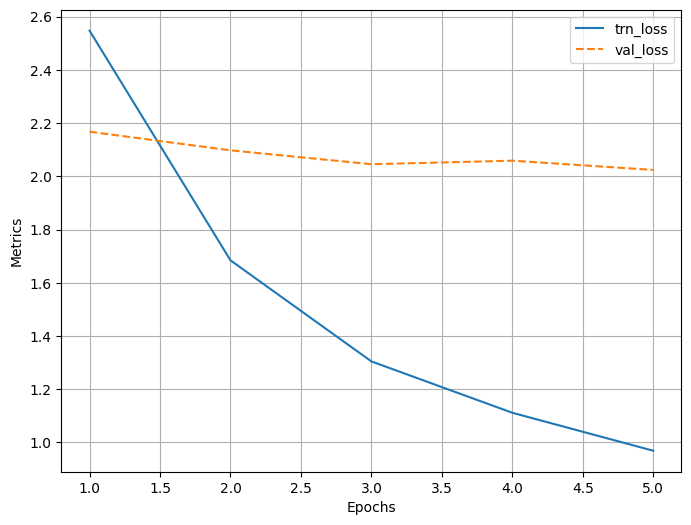

Temps d'exécution : 735.4788925647736 secondes

In [ ]:
# Enregistrez le temps de début
temps_debut = time.time()
# Loop training
for epoch in tqdm(range(n_epochs)):

    _n = len(train_loader)
    for ix, inputs in tqdm(enumerate(train_loader)):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

temps_fin = time.time()
# Calculez la durée totale
duree_execution = temps_fin - temps_debut

print(f"Temps d'exécution : {duree_execution} secondes")

## Predict on a new image

In [ ]:
# function to predict on a new image
def test_predictions(filename, show_output=True):

  # Read the image and extract candidates
  img = np.array(cv2.imread(filename, 1)[...,::-1])
  candidates = extract_candidates(img)
  candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]

  # Loop through the candidates to size and preprocess the image
  input = []
  for candidate in candidates:
    x,y,X,Y = candidate
    crop = cv2.resize(img[y:Y,x:X], (224,224))
    input.append(preprocess_image(crop/255.)[None])
  input = torch.cat(input).to(device)

  # Predict the class and offset
  with torch.no_grad():
    rcnn.eval()
    probs, deltas = rcnn(input)
    probs = torch.nn.functional.softmax(probs, -1)
    confs, clss = torch.max(probs, -1)

  # Extract the candidates that do not belong to the background class
  # and sum up the candidates with the predicted bounding box offset valeus
  candidates = np.array(candidates)
  confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

  ixs = clss!=background_class
  confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
  bbs = (candidates + deltas).astype(np.uint16)

  # Use non-max suppression nms to eliminate near-duplicate bounding boxes
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

  if len(ixs) == 1:
    confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

  # Fetch the bounding box with the highest confidence
  if len(confs) == 0 and not show_output:
    return (0,0,224,224), 'background', 0
  if len(confs) > 0:
    best_pred = np.argmax(confs)
    best_conf = np.max(confs)
    best_bb = bbs[best_pred]
    x,y,X,Y = best_bb

  # Plot the image along with the predict bounding box
  _, ax = plt.subplots(1, 2, figsize=(20,10))
  show(img, ax=ax[0])
  ax[0].grid(False)
  ax[0].set_title('Original image')
  if len(confs) == 0:
    ax[1].imshow(img)
    ax[1].set_title('No objects')
    plt.show()
    return
  ax[1].set_title(target2label[clss[best_pred]])
  show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
  plt.show()
  return (x,y,X,Y),target2label[clss[best_pred]],best_conf

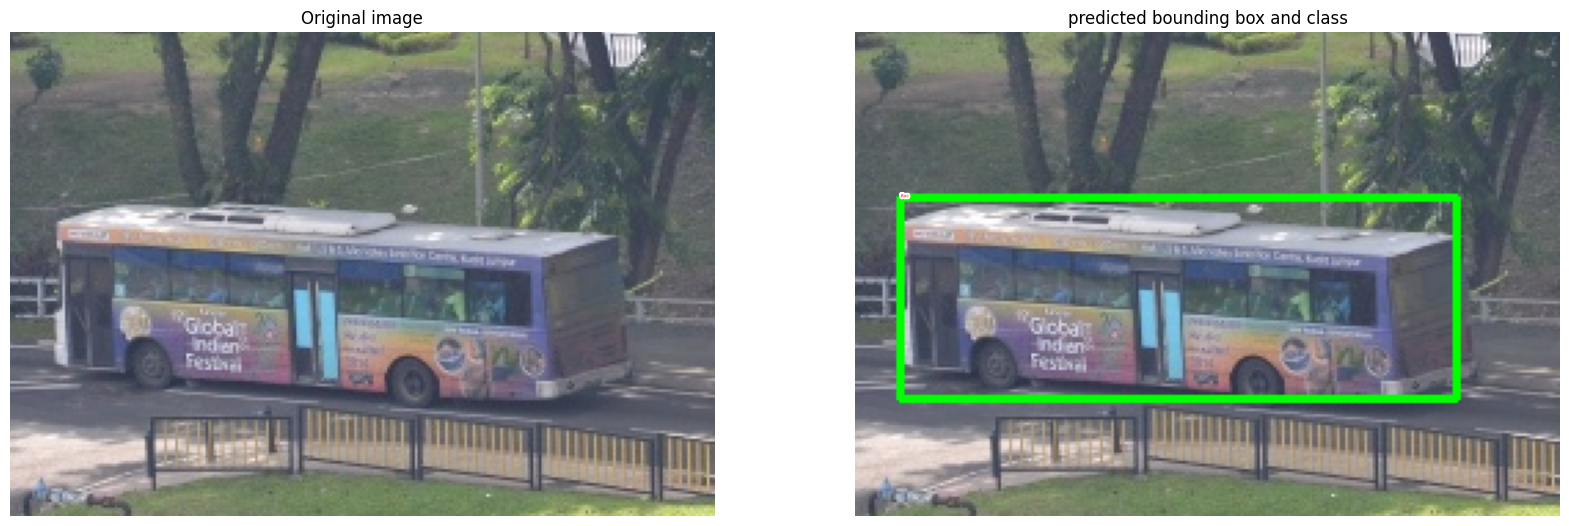

((16, 60, 218, 133), 'Bus', 0.97936213)

In [ ]:
# Test
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)

# CHAPTER II: Fast Region-based Convolutional Neural Network (Fast R-CNN)

### Definition of class to preprocess the dataset for *Fast R-CNN*

In [ ]:
class FRCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas, gtbbs):
    self.fpaths = fpaths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image = cv2.imread(fpath, 1)[...,::-1]
    gtbbs = self.gtbbs[ix]
    rois = self.rois[ix]
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
    return image, rois, labels, deltas, gtbbs, fpath

  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for ix in range(len(batch)):
      image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
      image = cv2.resize(image, (224,224))
      input.append(preprocess_image(image/255.)[None])
      rois.extend(image_rois)
      rixs.extend([ix]*len(image_rois))
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    rois = torch.Tensor(rois).float().to(device)
    rixs = torch.Tensor(rixs).float().to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, rois, rixs, labels, deltas

In [ ]:
# For Fast R-CNN
train_ds_fastrcnn = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds_fastrcnn = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

train_loader_fastrcnn = DataLoader(train_ds_fastrcnn, batch_size=2, collate_fn=train_ds_fastrcnn.collate_fn, drop_last=True)
test_loader_fastrcnn = DataLoader(test_ds_fastrcnn, batch_size=2, collate_fn=test_ds_fastrcnn.collate_fn, drop_last=True)

## Architecture of Fast Region-based Convolutional Neural Network (Fast R-CNN)

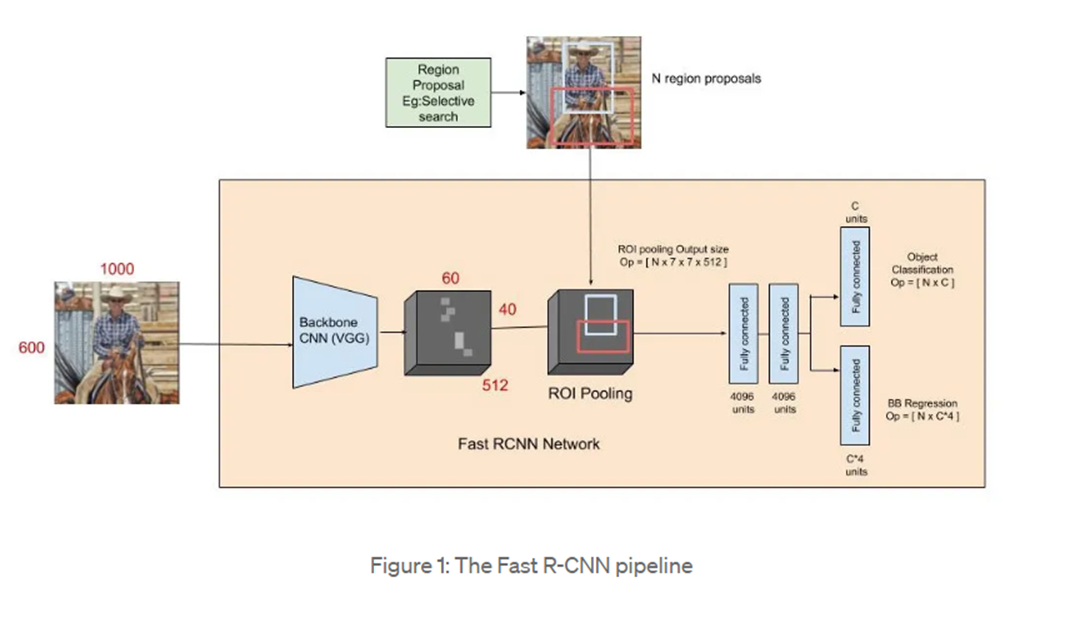

In [ ]:
from torchvision.ops import RoIPool
class FRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    rawnet = torchvision.models.vgg16_bn(pretrained=True)
    for param in rawnet.features.parameters():
      param.requires_grad = True
    self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
    self.roipool = RoIPool(7, spatial_scale=14/224)
    feature_dim = 512*7*7
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
          nn.Linear(feature_dim, 512),
          nn.ReLU(),
          nn.Linear(512, 4),
          nn.Tanh(),
        )
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()
  def forward(self, input, rois, ridx):
    res = input
    res = self.seq(res)
    rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
    res = self.roipool(res, rois)
    feat = res.view(len(res), -1)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
    return cls_score, bbox
  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cel(probs, labels)
    ixs, = torch.where(labels != background_class)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas, deltas)
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss


## Define the train and validation function

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

## Step of training of Fast RCNN

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 75.8MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0.840  val_loss: 0.946  val_loc_loss: 0.446  val_regr_loss: 0.050  val_acc: 0.779  (257.95s - 1277.46s remaining)

 20%|██        | 1/5 [00:12<00:50, 12.58s/it]

EPOCH: 1.000  trn_acc: 0.846  val_acc: 0.770  val_regr_loss: 0.077  trn_loc_loss: 0.421  val_loss: 1.364  val_loc_loss: 0.590  trn_regr_loss: 0.059  trn_loss: 1.008  (258.06s - 1032.24s remaining)
EPOCH: 1.840  val_loss: 1.013  val_loc_loss: 0.461  val_regr_loss: 0.055  val_acc: 0.779  (270.63s - 464.78s remaining)

 40%|████      | 2/5 [00:25<00:37, 12.63s/it]

EPOCH: 2.000  trn_acc: 0.880  val_acc: 0.763  val_regr_loss: 0.077  trn_loc_loss: 0.349  val_loss: 1.360  val_loc_loss: 0.589  trn_regr_loss: 0.050  trn_loss: 0.849  (270.72s - 406.08s remaining)
EPOCH: 2.920  val_loss: 1.626  val_loc_loss: 0.790  val_regr_loss: 0.084  val_acc: 0.609  (283.37s - 201.85s remaining)

 60%|██████    | 3/5 [00:37<00:25, 12.66s/it]

EPOCH: 3.000  trn_acc: 0.903  val_acc: 0.765  val_regr_loss: 0.077  trn_loc_loss: 0.297  val_loss: 1.357  val_loc_loss: 0.585  trn_regr_loss: 0.042  trn_loss: 0.722  (283.42s - 188.94s remaining)
EPOCH: 3.640  val_loss: 1.506  val_loc_loss: 0.657  val_regr_loss: 0.085  val_acc: 0.652  (295.84s - 110.53s remaining)

 80%|████████  | 4/5 [00:50<00:12, 12.65s/it]

EPOCH: 4.000  trn_acc: 0.921  val_acc: 0.764  val_regr_loss: 0.075  trn_loc_loss: 0.257  val_loss: 1.332  val_loc_loss: 0.586  trn_regr_loss: 0.039  trn_loss: 0.643  (296.04s - 74.01s remaining)
EPOCH: 4.760  val_loss: 1.204  val_loc_loss: 0.599  val_regr_loss: 0.060  val_acc: 0.802  (308.39s - 15.55s remaining)

100%|██████████| 5/5 [01:03<00:00, 12.61s/it]


EPOCH: 5.000  trn_acc: 0.931  val_acc: 0.762  val_regr_loss: 0.074  trn_loc_loss: 0.225  val_loss: 1.331  val_loc_loss: 0.587  trn_regr_loss: 0.036  trn_loss: 0.587  (308.52s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 1279.79it/s]


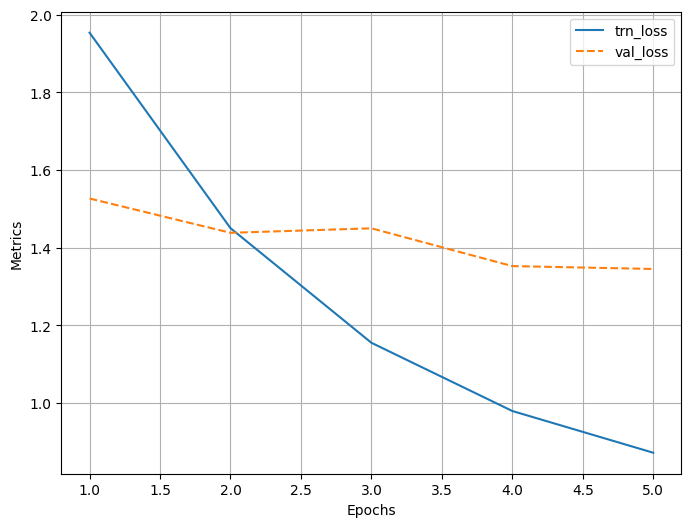

Temps d'exécution : 63.37698817253113 secondes

In [ ]:
import time

# Enregistrez le temps de début
temps_debut = time.time()
for epoch in tqdm(range(n_epochs)):

  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader_fastrcnn):
    loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn,
                                                  optimizer, criterion)
    pos = (epoch + (ix+1)/_n)
    log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                trn_regr_loss=regr_loss,
                trn_acc=accs.mean(), end='\r')

  _n = len(test_loader)
  for ix,inputs in enumerate(test_loader_fastrcnn):
    _clss, _deltas, loss, \
    loc_loss, regr_loss, accs = validate_batch(inputs,
                                            frcnn, criterion)
    pos = (epoch + (ix+1)/_n)
    log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
            val_regr_loss=regr_loss,
            val_acc=accs.mean(), end='\r')

  log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

temps_fin = time.time()
# Calculez la durée totale
duree_execution = temps_fin - temps_debut
print("\n")
print(f"\nTemps d'exécution : {duree_execution} secondes")

## Predict on a new image

In [ ]:
def test_predictions_fast(filename):
  img = cv2.resize(np.array(Image.open(filename)), (224,224))
  candidates = extract_candidates(img)
  candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
  input = preprocess_image(img/255.)[None]
  rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
  rixs = np.array([0]*len(rois))
  rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
  with torch.no_grad():
    frcnn.eval()
    probs, deltas = frcnn(input, rois, rixs)
    confs, clss = torch.max(probs, -1)
  candidates = np.array(candidates)
  confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

  ixs = clss!=background_class
  confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
  bbs = candidates + deltas
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  if len(ixs) == 1:
    confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

  bbs = bbs.astype(np.uint16)
  _, ax = plt.subplots(1, 2, figsize=(20,10))
  show(img, ax=ax[0])
  ax[0].grid(False)
  ax[0].set_title(filename.split('/')[-1])
  if len(confs) == 0:
    ax[1].imshow(img)
    ax[1].set_title('No objects')
    plt.show()
    return
  else:
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
    plt.show()

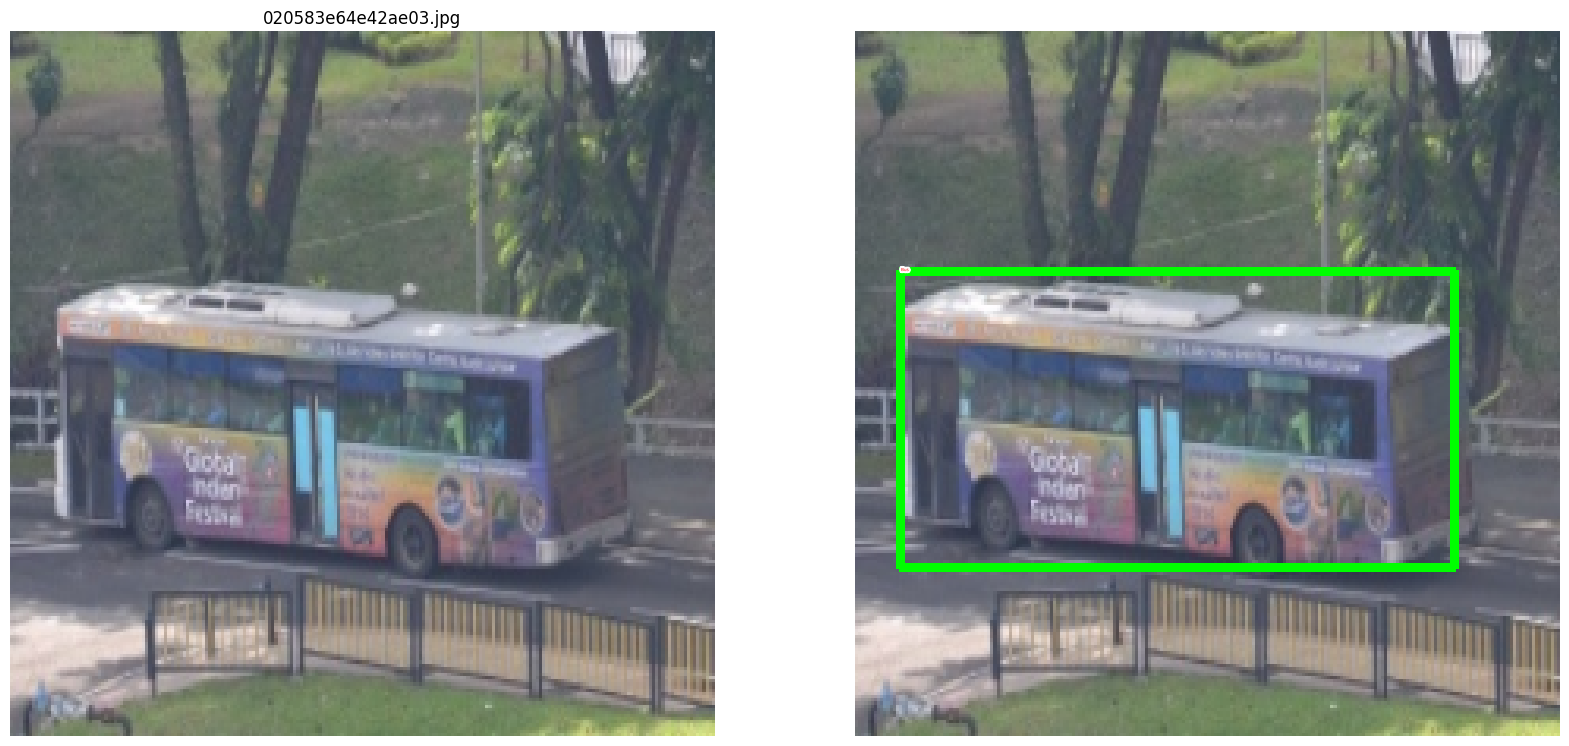

In [ ]:
test_predictions_fast(test_ds_fastrcnn[7][-1])

# CHAPTER III: Faster Region-based Convolutional Neural Network R-CNN

In [ ]:
from torch_snippets import *
from PIL import Image
IMAGE_ROOT = 'images/images'
DF_RAW = df = pd.read_csv('df.csv')
# Sélectionnez les 500 premières lignes du dataframe
df = df.head(500)

In [ ]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [ ]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.image_infos)

## Dataset Splitting and DataLoader Setup for Object Detection

In [ ]:
from sklearn.model_selection import train_test_split
import glob
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

## Faster R-CNN Model Initialization

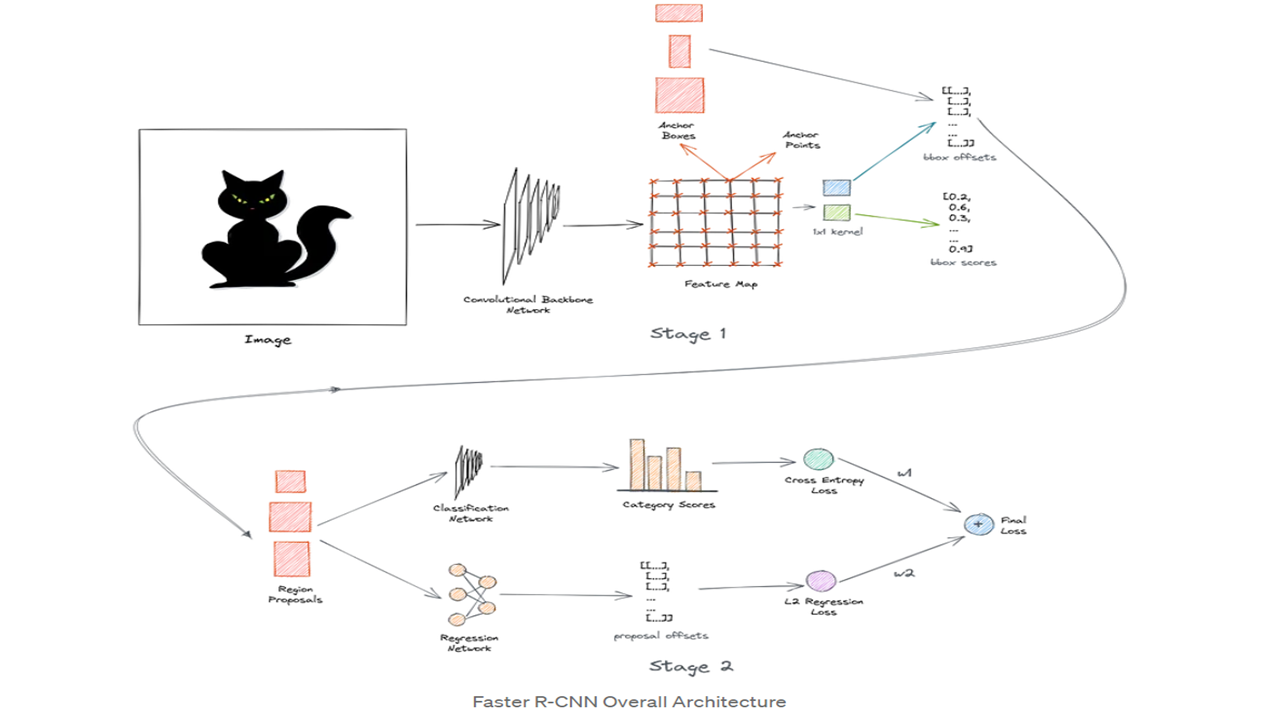


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

## Training and Validation Functions for Single Batches

In [ ]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training and Validation Loop with Logging

In [ ]:
# Enregistrez le temps de début
temps_debut = time.time()

for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

temps_fin = time.time()
# Calculez la durée totale
duree_execution = temps_fin - temps_debut

print(f"Temps d'exécution : {duree_execution} secondes")

EPOCH: 1.000  val_rpn_box_reg_loss: 0.015  val_loss: 0.347  val_regr_loss: 0.136  trn_rpn_box_reg_loss: 0.016  trn_loss: 0.381  trn_objectness_loss: 0.063  trn_loc_loss: 0.157  trn_regr_loss: 0.145  val_loc_loss: 0.114  val_objectness_loss: 0.082  (65.12s - 260.48s remaining)
EPOCH: 2.000  val_rpn_box_reg_loss: 0.013  val_loss: 0.295  val_regr_loss: 0.115  trn_rpn_box_reg_loss: 0.012  trn_loss: 0.306  trn_objectness_loss: 0.022  trn_loc_loss: 0.121  trn_regr_loss: 0.151  val_loc_loss: 0.092  val_objectness_loss: 0.074  (125.81s - 188.71s remaining)
EPOCH: 3.000  val_rpn_box_reg_loss: 0.012  val_loss: 0.295  val_regr_loss: 0.096  trn_rpn_box_reg_loss: 0.010  trn_loss: 0.250  trn_objectness_loss: 0.012  trn_loc_loss: 0.109  trn_regr_loss: 0.120  val_loc_loss: 0.084  val_objectness_loss: 0.103  (186.28s - 124.19s remaining)
EPOCH: 4.000  val_rpn_box_reg_loss: 0.012  val_loss: 0.294  val_regr_loss: 0.084  trn_rpn_box_reg_loss: 0.008  trn_loss: 0.199  trn_objectness_loss: 0.006  trn_loc_los

Temps d'exécution : 304.45501589775085 secondes

## Plotting Training and Validation Losses Over Epochs

100%|██████████| 106/106 [00:00<00:00, 5726.23it/s]


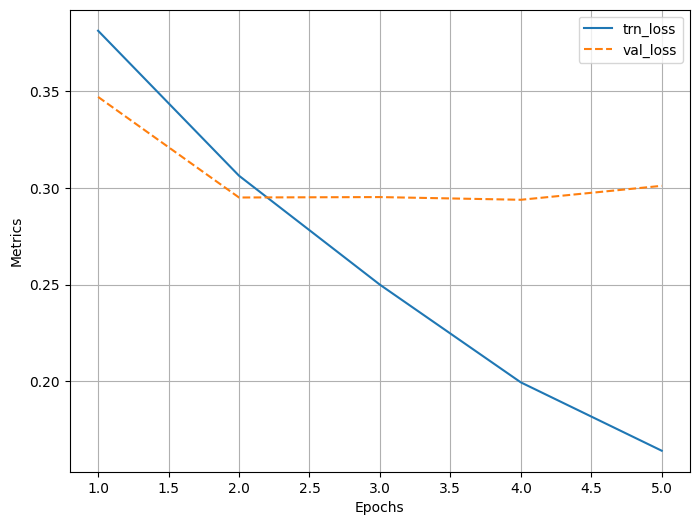

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

## Post-processing Function for Decoding Model Output

In [ ]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

## Model Evaluation and Visualization on Test Data

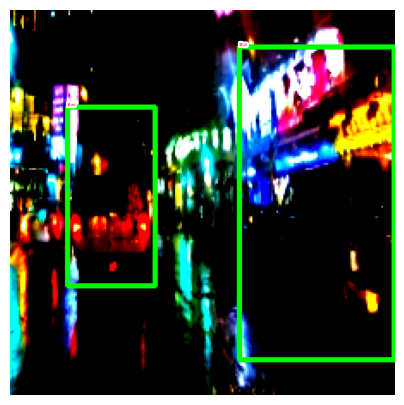

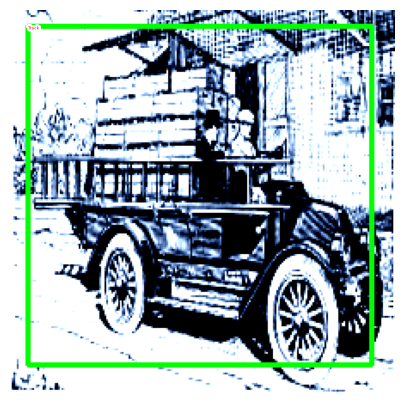

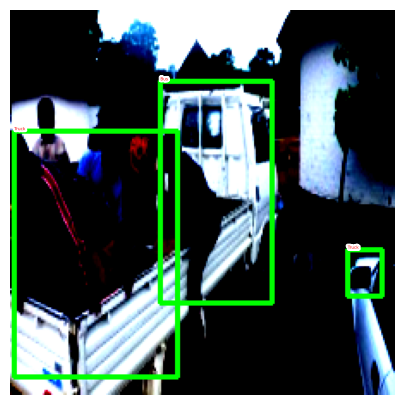

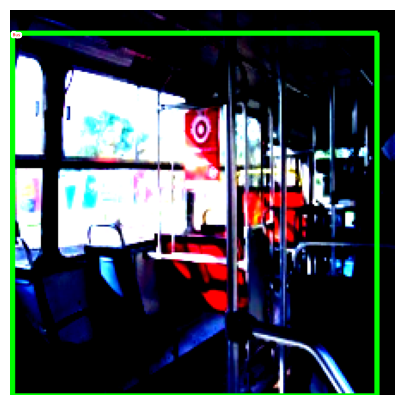

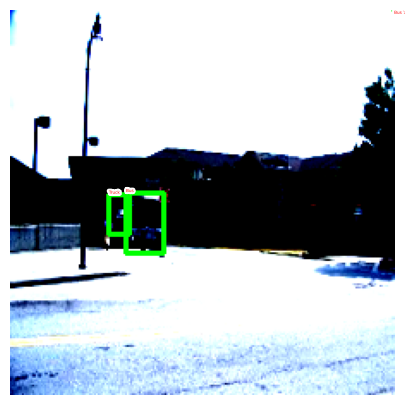

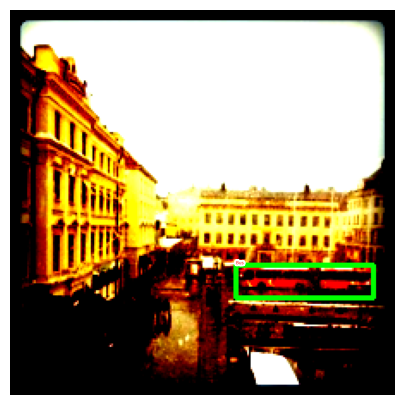

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)